In [293]:
%matplotlib inline
import re
import os
import sys
#for plotting
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import random as r
datafiles = ['ycsb_readonly_wl_2.5Mtxn_1Mrecs.out',
             'ycsb_50pwrite_th0.6_wl_2.5Mtxn_1Mrecs.out',
             'ycsb_50pwrite_th0.7_wl_2.5Mtxn_1Mrecs.out']

fname ='ycsb_50pwrite_th0.7_wl_2.5Mtxn_1Mrecs.out'
# fname ='ycsb_50pwrite_th0.7_wl_2.5Mtxn_1Mrecs.out'
# fname = 'ycsb_readonly_wl_2.5Mtxn_1Mrecs.out'
fname ='/Users/qadahtm/Dev/halstead/ycsb_wl/ycsb_wl_16_single.txt'
fname ='/Users/qadahtm/Dev/halstead/ycsb_wl/ycsb_wl_16_mpt50.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_zt9/ycsb_wl_16_single_zt9.txt'
# fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_zt9/ycsb_wl_16_mpt50_zt9.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_mpt_zt9.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_mpt50_zt99.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_mpt100_zt99.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_spt_zt99_1Kdb.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_mpt100_zt99_1Kdb.txt'

# fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8.txt'
# fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb.txt'

# fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt0_strict_1part_partzipf.txt'

# fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt0_strict_1part_reczipf2.txt'

# fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt9_strict_1part_reczipf.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt9_strict_mpt100_reczipf.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt0_strict_mpt100_reczipf.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt0_strict_1part_reczipf.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt9_strict_1part_reczipf.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt9_nostrict_mpt100_reczipf.txt'

fname ='/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/txn_files/2Kdb_tpp100_theta0_1.txt'
fname ='/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/txn_files/2Kdb_tpp100_thetapt99.txt'
# fname ='/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/txn_files/2Kdb_tpp100_thetapt99_1.txt'
fname ='/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/txn_files/2Kdb_theta99_zipfwithinpart.txt' 
fname ='/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/txn_files/2Kdb_tpp100_thetapt8_zipfwithinpart.txt' 
# fname ='/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/txn_files/2Kdb_tpp100_thetapt6_zipfwithinpart.txt' 
# fname ='/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/txn_files/2Kdb_tpp100_thetapt2_zipfwithinpart.txt' 
# fname ='/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/txn_files/2Kdb_tpp100_thetapt0_zipfwithinpart.txt' 

fname ='/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/txn_files/2Kdb_tpp100_thetapt8_zipfwithinpart_mprpt1_req10.txt' 
# fname ='/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/txn_files/2Kdb_tpp100_thetapt8_zipfwithinpart_mpr0_req10.txt' 
fname ='/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/txn_files/2Kdb_tpp100_thetapt0_zipfwithinpart.txt' 

i = 0
g_max = -1
g_min = -1
PLANNER_CNT = 1

table_size = 16783200
table_size = 65536 #small table for testing
table_size = 1024*2 #tiny table
no_buckets = 1024*2
# no_buckets = 32

print("Bucket size = {:d}".format(bucket_size))

# print(buckets)

def hashKeyToBucket(key, no_buckets, bucket_size):
    for i in range(no_buckets):
#         print(i)
        if (key >= i*bucket_size and key < (i+1)*bucket_size):
            return i
#     if does not fall into any of the buckets (should not happen), assign to bucket 0

    return 0

def hashKeyToBucket2(key):
    return key % no_buckets;

def hashKeyToBucket3(key):
    return (int(key / bucket_size)) % no_buckets;

# print(hashKeyToBucket(bucket_size*4))
# print(hashKeyToBucket(173648))
# print(hashKeyToBucket(1013625))
# print(hashKeyToBucket(1048576))
# print(hashKeyToBucket(1))
# print(hashKeyToBucket(2))
# print(hashKeyToBucket(3))

# print(hashKeyToBucket2(bucket_size*4))
# print(hashKeyToBucket2(173648))
# print(hashKeyToBucket2(1013625))
# print(hashKeyToBucket2(1048576))
# print(hashKeyToBucket2(1))
# print(hashKeyToBucket2(2))
# print(hashKeyToBucket2(3))


#initialize planners
planners = []
for i in range(PLANNER_CNT):
    planners.append([0]*no_buckets)
# print(planners)

plt_buckets_keys = []
for i in range(no_buckets):
    plt_buckets_keys.append("[{:d}-{:d})".format(i*bucket_size,bucket_size*(i+1)))
    
# plt_buckets_keys.append("[{:d}-{:d})".format(0,bucket_size))
# plt_buckets_keys.append("[{:d}-{:d})".format(bucket_size,bucket_size*2))
# plt_buckets_keys.append("[{:d}-{:d})".format(bucket_size*2,bucket_size*3))
# plt_buckets_keys.append("[{:d}-{:d})".format(bucket_size*3,bucket_size*4))

plot_data = [];
buckets_2 = [16409900, 3856648, 2650184, 2083308]
batch_size = 100*1000

def plot_figure(plt_buckets_keys, _buckets, _planners, splot):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(splot)
    pcolors = ['r','b','g','gray']
    pln_d = {};
    for i, pln in enumerate(_planners, start=0):
#         print(pln)
        for j, bkt in enumerate(_buckets, start=0):
            pln_d[plt_buckets_keys[j]] = pln[j]

#         print(pln_d)    
        x = np.arange(len(pln_d))
#         ax.bar(x+(w*(i+1)), pln_d.values(),width=w, color=pcolors[i],align='center')
        ax.bar(x, pln_d.values(), color=pcolors[i],align='center')
    
    ax.set_xticks(x)
#     ax.set_xticklabels(plt_buckets_keys, rotation=30)
    ax.set_xticklabels(x, rotation=30)
    
    ax.set_ylabel('Access Count')
    ax.set_xlabel('Key Ranges')
#     ax.autoscale(tight=True)

def parseFileForStats(_fname, planners):
    txn_cnt = 0
    _buckets = [0]*no_buckets
    
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('YCSB_TXN\{(.*)\}', cline)
            if m: #line is a transaction
                txn_str = m.group(1)
                txn_cnt = txn_cnt + 1
                keys = list(map(lambda x: int(x.split(',')[1]), txn_str.split(':')))
                for k in keys:
                    index = hashKeyToBucket3(k)
                    if (txn_cnt % 100000) == 0:
                        print("key {} is assigned to part {}".format(k, index))
                    _buckets[index] = _buckets[index] + 1                    
#     print("Txn_cnt = {:d}".format(txn_cnt))
#     print("Buckets:")
#     print(_buckets)
                
def parseFile(_fname, planners, no_buckets, table_size):
    bi = 0
    plot_more = True
    plot_count = 0
    buckets = [0]*no_buckets    
    bucket_size = int(table_size/no_buckets)
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('YCSB_TXN\{(.*)\}', cline)
    #         if i < 10:
            if m: #line is a transaction
                txn_str = m.group(1)                
    #                 print(txn_str)
                pli = r.randrange(len(planners))
                keys = list(map(lambda x: int(x.split(',')[1]), txn_str.split(':')))
                for k in keys:
                    index = hashKeyToBucket(k, no_buckets, bucket_size)
#                     index = hashKeyToBucket2(k)
                    planners[pli][index] = planners[pli][index] + 1
                    buckets[index] = buckets[index] + 1        
                # increment batch
                bi = bi + 1
                if (bi == batch_size and plot_more):
                    bi = 0
                    splot = 111
#                     plot_figure(plt_buckets_keys,buckets, planners, splot)
                    planners = []
                    for i in range(PLANNER_CNT):
                        planners.append([0]*no_buckets)
                    plot_count = plot_count + 1
                if (plot_count == 1):
                    plot_more = False
                if not plot_more:
                    break
    return buckets
                


def plot_figure_oneset(plt_buckets_keys, _buckets):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)    
    x = np.arange(no_buckets)
    ax.bar(x, _buckets,width=w, color='gray',align='center')

    ax.set_xticks(x)
#     ax.set_xticklabels(plt_buckets_keys, rotation=30)
    ax.set_xticklabels(x, rotation=30)
    
    ax.set_ylabel('Access Count')
    ax.set_xlabel('Key Ranges')
#     ax.autoscale(tight=True)



Bucket size = 1


In [294]:
# Function defs
def extract_from_file(_fname):
    res = {}
    with open(_fname,'r') as of:
        res['has_data_fixed_mode'] = False
        res['has_data_normal_mode'] = False
        for line in of:
            
            cline = line.strip()
            #extract thread_cnt
            m = re.search('g_thread_cnt\s+(\d+)', cline)
            if m:
                res['g_thread_cnt'] = m.group(1)
            #extraxct zipf_theta
            m = re.search('g_zipf_theta\s+(\d+\.\d+)', cline)
            if m:
                res['g_zipf_theta'] = m.group(1)      
                
            m = re.search('g_req_per_query\s+(\d+)', cline)
            if m:
                res['g_req_per_query'] = m.group(1)    

            m = re.search('g_txn_write_perc\s+(\d+.\d+)', cline)
            if m:
                res['g_txn_write_perc'] = m.group(1)    

            m = re.search('g_mpr\s+(\d+.\d+)', cline)
            if m:
                res['g_mpr'] = m.group(1)    
                
            m = re.search('g_max_txn_per_part\s+(\d+)', cline)
            if m:
                res['g_max_txn_per_part'] = m.group(1)    
                
            m = re.search('g_part_cnt\s+(\d+)', cline)
            if m:
                res['g_part_cnt'] = m.group(1)    
                

            #extract from Pass
            m = re.search('PASS!,(.+)', cline)
#             SimTime=26.737377,total_time=26.737377,pt_time=13.400466,et_time=13.336911,
#             total_tput=625030.625000,pt_tput=1247096.875000,et_tput=1253039.750000, 
#             txn_cnt=16711680
            if m:        
#                 print(m.group(1))
                res['has_data_fixed_mode'] = True
                sline = m.group(1).split(',')
                for a in sline:
                    asline = a.strip().split('=')
#                     if asline[0] == 'SimTime':                        
#                         print(asline[1])
                    if asline[0] == 'total_time':
#                         print('====='+asline[0]+'='+asline[1])
                        res['total_time'] = asline[1];
                    if asline[0] == 'pt_time':
                        res[asline[0]] = asline[1];
                    if asline[0] == 'et_time':
                        res[asline[0]] = asline[1];
                    if asline[0] == 'total_tput':
                        res[asline[0]] = asline[1];
                    if asline[0] == 'pt_tput':
                        res[asline[0]] = asline[1];
                    if asline[0] == 'et_tput':
                        res[asline[0]] = asline[1];
                    if asline[0] == 'txn_cnt':
                        res[asline[0]] = asline[1];
            
            #extract from summary
            m = re.search('(\[summary\]) (.+)', cline)
            if m:
                res['has_data_normal_mode'] = True
                sline = m.group(2).split(',')
                for i, a in enumerate(sline):
#                     print(i,a)
                    asline = a.split('=')
                    if asline[0] == 'total_runtime':
                        res[asline[0]] = asline[1]
                    if asline[0] == 'tput':
                        res[asline[0]] = asline[1]
                    if asline[0] == 'virt_mem_usage':
                        res[asline[0]] = asline[1]
                    if asline[0] == 'phys_mem_usage':
                        res[asline[0]] = asline[1]
                    if asline[0] == 'fscl_avg':
                        res[asline[0]] = asline[1]                         
                    ms= re.search('fscl\d+', asline[0])
                    if ms:
                        res[asline[0]] = asline[1]  
                        
#                         print(a)
#                 print(sline[0])
#                 print(sline[1])
#                 print(sline[2])
#     print(res)
    if not res['has_data_fixed_mode']:
        res['total_time'] = '0.0';
        res['pt_time'] = '0.0';
        res['et_time'] = '0.0';
        res['total_tput'] = '0.0';
        res['pt_tput'] = '0.0';
        res['et_tput'] = '0.0';
        res['txn_cnt'] = '0';        
    if not res['has_data_normal_mode']:
        res['total_runtime'] = '0.0';
        res['tput'] = '0';
        res['virt_mem_usage'] = '0';
        res['phys_mem_usage'] = '0';
        
        
    return res;


def parse_directory(directory):
    resFiles = os.listdir(directory)
    data = {
            'cc_alg':[],
            'vm':[],
            'worker_cnt':[],
            'tput':[],
            'pa_cnt':[],
            'pa_strict':[],
            'total_tput':[],
            'commit_strategy':[],
            'batch_size':[],
            'req_cnt':[],
            'mpr':[],
            'total_txn_cnt':[],
            'txn_per_part':[],
            'part_cnt':[],
            'rec_size':[],
            'write_perc':[],
            'pt_perc':[],
            'pt_cnt':[],
            'pt_time':[],
            'pt_tput':[],
            'et_cnt':[],
            'et_tput':[],
            'et_time':[],
            'total_runtime':[],
            'total_time':[],
            'trial_no':[],
            'seq_no':[],            
            'virt_mem_usage':[],
            'phys_mem_usage':[],
            'fscl10':[],
            'fscl25':[],
            'fscl50':[],
            'fscl75':[],
            'fscl90':[],
            'fscl95':[],
            'fscl99':[],
            'fscl100':[],
            'fscl_avg':[],
            'zipf_theta':[]
           }
    # dfcols = ['cc_alg', 'w_cnt', 'tput', 'trial_no', 'seq_no', 'zipf_theta']
    for fname in resFiles:
    #     m = re.search("(pt6_)?([A-Za-z]+)_(c|s)_t(\d+)_(\d+)(_(\d+))?.txt",fname)
#         regex = "pa?(\d+)_?([A-Za-z]+)_pt(\d+)_et(\d+)_(\d+)_([A-Za-z]+)_(c|s)_t(\d+)_(\d+)(_(\d+))?.txt"
#         regex = "(pa(\d+)_)?([A-Za-z]+)_pt(\d+)_et(\d+)_(\d+)_?(pptstrict|pptnonstrict)_([A-Za-z]+)_(c|s)_t(\d+)_(\d+)(_(\d+))?.txt"
#         regex = "(pa?(\d+)_)?([A-Za-z]+|\d+)_pt(\d+)_et(\d+)_(\d+)_?(pptstrict|pptnonstrict)?_([A-Za-z]+)_(c|s)_t(\d+)_(\d+)(_(\d+))?.txt"
        regex = "(pa(\d+)_)([A-Za-z]+|\d+)_pt(\d+)_et(\d+)_(\d+)_?(pptstrict|pptnonstrict)?_([A-Za-z]+)_(c|s)_t(\d+)_(\d+)(_(\d+))?.txt"
        rsize_re = "(\d+)Brec_.+"
        rsize_m = re.search(rsize_re,fname)
        m = re.search(regex,fname)
        wthd_cnt = 0
        extracted_data = {}
        cc_alg = ''
        trial_num = 0
        seq_num = 0
        theta = 0.0
        pt_prec = 0
        pa_cnt = 0
        pa_s = False
#         print(fname)
        if m:
            try:
#                 print(fname)
                pa_cnt = int(m.group(2)) if m.group(2) else 0
                comm_strat = m.group(3)
                pt_cnt = int(m.group(4))
                et_cnt = int(m.group(5))
                pt_perc = int(m.group(6))
                if m.group(7) == 'pptstrict':
                    pa_s = True
                cc_alg = m.group(8)
                trial_num = m.group(10)
                seq_num = m.group(11)  
                core_cnt = int(m.group(13))
                e_data = extract_from_file(directory+'/'+fname)
                w_thd = int(e_data['g_thread_cnt'])
                if rsize_m:
                    rec_size = int(rsize_m.group(1))
                else: 
                    rec_size = 0
                data['rec_size'].append(rec_size)

        #         nodemal mode
                if (comm_strat == 'NOCOMSTRAT'):        
                    if (cc_alg == 'QUECC' and q_pipelined):
                        data['worker_cnt'].append(int(e_data['g_thread_cnt'])*2)
                    else:
                        data['worker_cnt'].append(int(e_data['g_thread_cnt']))

                if (cc_alg == 'QUECC' and q_pipelined):
                    data['worker_cnt'].append(pt_cnt+et_cnt)
                else:
                    data['worker_cnt'].append(int(e_data['g_thread_cnt']))


                #fixed-mode

        #         if (pt_perc == 100):
        #             data['worker_cnt'].append(pt_cnt)
        #         else:
        #             data['worker_cnt'].append(pt_cnt+et_cnt)
        #         data['worker_cnt'].append(int(e_data['g_thread_cnt']))
                data['cc_alg'].append(cc_alg)
                data['vm'].append(core_cnt)
                data['commit_strategy'].append(comm_strat)  
                try:
                    data['batch_size'].append(int(comm_strat))
                except ValueError:
                    data['batch_size'].append(0)
                        

                if (e_data['has_data_fixed_mode']):
                    data['total_time'].append(float(e_data['total_time']))
                    data['total_tput'].append(float(e_data['total_tput']))
                    data['total_runtime'].append(float(0))
                    data['tput'].append(float(0))
                else:
                    data['total_runtime'].append(float(e_data['total_runtime']))
                    data['tput'].append(float(e_data['tput']))
                    data['total_time'].append(float(0))
                    data['total_tput'].append(float(0))            

                data['virt_mem_usage'].append(int(e_data['virt_mem_usage']))
                data['phys_mem_usage'].append(int(e_data['virt_mem_usage']))
                data['pa_cnt'].append(int(pa_cnt))
                data['pa_strict'].append(pa_s)
                data['pt_perc'].append(pt_perc)
                data['pt_cnt'].append(pt_cnt)
                data['pt_time'].append(float(e_data['pt_time']))
                data['pt_tput'].append(float(e_data['pt_tput']))
                data['et_cnt'].append(et_cnt)
                data['et_time'].append(float(e_data['et_time']))
                data['et_tput'].append(float(e_data['et_tput']))
                data['trial_no'].append(int(trial_num))
                pcnt = int(e_data['g_part_cnt']);
                tpp = int(e_data['g_max_txn_per_part'])
                data['total_txn_cnt'].append(pcnt*tpp)
                data['part_cnt'].append(pcnt)
                data['txn_per_part'].append(tpp)
                data['seq_no'].append(int(seq_num))
                data['req_cnt'].append(int(e_data['g_req_per_query']))
                data['mpr'].append(float(e_data['g_mpr']))
                data['write_perc'].append(float(e_data['g_txn_write_perc']))                
                data['zipf_theta'].append('{:.2f}'.format(float(e_data['g_zipf_theta'])))
                data['fscl10'].append(float(e_data['fscl10']))  
                data['fscl25'].append(float(e_data['fscl25']))  
                data['fscl50'].append(float(e_data['fscl50']))  
                data['fscl75'].append(float(e_data['fscl75']))  
                data['fscl90'].append(float(e_data['fscl90']))  
                data['fscl95'].append(float(e_data['fscl95']))  
                data['fscl99'].append(float(e_data['fscl99']))  
                data['fscl100'].append(float(e_data['fscl100']))  
                data['fscl_avg'].append(float(e_data['fscl_avg'])) 
                
            except KeyError:
                print(fname)
    return data
                
def view_planner_from_file(_fname):
    res = {}
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('(\[summary\]) (.+)', cline)
            if m:
                sline = m.group(2).split(',')
                for i, a in enumerate(sline):
                    mq = re.search('quecc\_plan(\d+)\_(\w+)=(-?\d+\.?\d*)', a)
                    if mq:
                        row = [mq.group(1), mq.group(2), mq.group(3)]
                        key = mq.group(2)
                        if key in res.keys():
                            res[mq.group(2)].append(float(mq.group(3)))
                        else:
                            res[mq.group(2)] =[float(mq.group(3))]
#                         print(row)
#                         print(a)
#                 print(sline[0])
#                 print(sline[1])
#                 print(sline[2])
#     print(res)
    return res;

def plot_planner_times(df):
    # Create the general blog and the "subplots" i.e. the bars
    f, ax1 = plt.subplots(1, figsize=(16,5))

    # Set the bar width
    bar_width = 0.40

    colors = ['#d7191c','#fdae61','#abdda4','#2b83ba']


    # positions of the left bar-boundaries
    bar_l = [i-(bar_width) for i in range(len(df['idle_time']))]

    # positions of the x-axis ticks (center of the bars as bar labels)
    # tick_pos = [(i-1)+(bar_width/2) for i in bar_l]

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            df['idle_time'],
            # set the width
            width=bar_width,
            # with the label pre score
            label='Idle time',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colors[0])

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            # using the mid_score data
            df['queue_dequeue_time'],
            # set the width
            width=bar_width,
            # with pre_score on the bottom
            bottom=df['idle_time'],
            # with the label mid score
            label='Deq. time',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colors[1])

    # Create a bar plot, in position bar_1
    all_df = (df['idle_time'],df['queue_dequeue_time'])
    ax1.bar(bar_l,
            # using the post_score data
            df['txn_proc_time'],
            # set the width
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=all_df,
            # with the label post score
            label='Txn proc. time',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colors[2])
    all_df = (df['idle_time'],df['queue_dequeue_time'], df['txn_proc_time'])
    ax1.bar(bar_l,
            # using the post_score data
            [60-(i+j+k) for i,j,k in zip(df['idle_time'],df['queue_dequeue_time'], df['txn_proc_time'])],
            # set the width
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=all_df,
            # with the label post score
            label='Other times',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#000000')

    # set the x ticks with names
    plt.xticks(bar_l,['Planner_'+str(i) for i in range(len(df['idle_time']))], rotation=45)

    # Set the label and legends
    ax1.set_ylabel("Run Time")
    ax1.set_xlabel("Planner threads")
    # plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.)
## end -- def plot_planner_times(df):


In [295]:
def plot_exec_times_hl_pip(df):
    f, ax1 = plt.subplots(1, figsize=(15,5))

    # Set the bar width
    bar_width = 0.75

    colors = ['#CCCCCC','#fc8d59','#fee08b','#e6f598','#99d594','#d53e4f', '#3288bd']

    # positions of the left bar-boundaries

    bar_l = [i-(0.75) for i in range(len(df['wt_hl_exec_time']))]    
    # wt_hl_plan_time
#     ax1.bar(bar_l,
#             df['wt_hl_plan_time'],
#             width=bar_width,
#             label='Batch Planning time',
#             color=colors[0], hatch='//')

#     # sync plan
#     ax1.bar(bar_l,
#             df['wt_hl_sync_plan_time'],
#             width=bar_width,
#             bottom=df['wt_hl_plan_time'],
#             label='Sync after planning stage',
#             color=colors[1])

    # exec time
    plan_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time'])
    ax1.bar(bar_l,
            df['wt_hl_exec_time'],
            width=bar_width,
            label='Batch exec time',
            color=colors[2], hatch='\\')
    
    # sync_exec
    all_df = (df['wt_hl_exec_time'])
    ax1.bar(bar_l,
            df['wt_hl_sync_exec_time'],
            width=bar_width,
            bottom=all_df,
            label='Sync after exec. stage',
            color=colors[3])
    
    # txn_commit_time
    all_df = (df['wt_hl_exec_time']+df['wt_hl_sync_exec_time'])
    ax1.bar(bar_l,
            df['wt_hl_commit_time'],
            width=bar_width,
            bottom=all_df,
            label='Batch Commit time',
            color=colors[4], hatch='|')
    
    all_df = (df['wt_hl_exec_time']+df['wt_hl_sync_exec_time']+
              df['wt_hl_commit_time'])
    ax1.bar(bar_l,
            df['wt_hl_sync_commit_time'],
            width=bar_width,
            bottom=all_df,
            label='Sync after commit stage',
            color=colors[5])
    all_df = (df['wt_hl_exec_time']+df['wt_hl_sync_exec_time']+
              df['wt_hl_commit_time']+df['wt_hl_sync_commit_time'])
    ax1.bar(bar_l,
        df['wt_hl_cleanup_time'],
        width=bar_width,
        bottom=all_df,
        label='Cleanup time',
        color=colors[0], hatch='**')
        
    all_df = (df['wt_hl_exec_time']+df['wt_hl_sync_exec_time']+
              df['wt_hl_commit_time']+df['wt_hl_sync_commit_time']+
              df['wt_hl_cleanup_time'])

#     ax1.bar(bar_l,
#             (df['exec_batch_proc_time']-all_df),
#             width=bar_width,
#             # with pre_score and mid_score on the bottom
#             bottom=all_df,
#             label='Other unmeasured times',
#             color=colors[6], hatch='++')

    # set the x ticks with names
    plt.xticks(bar_l,['ET_'+str(i) for i in range(len(df['wt_hl_plan_time']))], rotation=45)

    # Set the label and legends
    ax1.set_ylabel("Run Time")
    ax1.set_xlabel("Execution threads")
    # plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.)

def plot_exec_times_hl_unpip(df):
    f, ax1 = plt.subplots(1, figsize=(15,5))

    # Set the bar width
    bar_width = 0.75

    colors = ['#CCCCCC','#fc8d59','#fee08b','#e6f598','#99d594','#d53e4f', '#3288bd']

    # positions of the left bar-boundaries

    bar_l = [i-(0.75) for i in range(len(df['wt_hl_plan_time']))]    
    # wt_hl_plan_time
    ax1.bar(bar_l,
            df['wt_hl_plan_time'],
            width=bar_width,
            label='Batch Planning time',
            color=colors[0], hatch='//')

    # sync plan
    ax1.bar(bar_l,
            df['wt_hl_sync_plan_time'],
            width=bar_width,
            bottom=df['wt_hl_plan_time'],
            label='Sync after planning stage',
            color=colors[1])

    # exec time
    all_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time'])
    ax1.bar(bar_l,
            df['wt_hl_exec_time'],
            width=bar_width,
            bottom=all_df,
            label='Batch exec time',
            color=colors[2], hatch='\\')
    
    # sync_exec
    all_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time']+
          df['wt_hl_exec_time'])
    ax1.bar(bar_l,
            df['wt_hl_sync_exec_time'],
            width=bar_width,
            bottom=all_df,
            label='Sync after exec. stage',
            color=colors[3])
    
    # txn_commit_time
    all_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time']+
          df['wt_hl_exec_time']+df['wt_hl_sync_exec_time'])
    ax1.bar(bar_l,
            df['wt_hl_commit_time'],
            width=bar_width,
            bottom=all_df,
            label='Batch Commit time',
            color=colors[4], hatch='|')
    
    all_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time']+
              df['wt_hl_exec_time']+df['wt_hl_sync_exec_time']+
              df['wt_hl_commit_time'])
    ax1.bar(bar_l,
            df['wt_hl_sync_commit_time'],
            width=bar_width,
            bottom=all_df,
            label='Sync after commit stage',
            color=colors[5])
    all_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time']+
              df['wt_hl_exec_time']+df['wt_hl_sync_exec_time']+
              df['wt_hl_commit_time']+df['wt_hl_sync_commit_time'])
    ax1.bar(bar_l,
        df['wt_hl_cleanup_time'],
        width=bar_width,
        bottom=all_df,
        label='Cleanup time',
        color=colors[0], hatch='**')
        
    all_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time']+
              df['wt_hl_exec_time']+df['wt_hl_sync_exec_time']+
              df['wt_hl_commit_time']+df['wt_hl_sync_commit_time']+
              df['wt_hl_cleanup_time'])

    ax1.bar(bar_l,
            (df['exec_batch_proc_time']-all_df),
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=all_df,
            label='Other unmeasured times',
            color=colors[6], hatch='++')

    # set the x ticks with names
    plt.xticks(bar_l,['ET_'+str(i) for i in range(len(df['wt_hl_plan_time']))], rotation=45)

    # Set the label and legends
    ax1.set_ylabel("Run Time")
    ax1.set_xlabel("Execution threads")
    # plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.)

pa5_40320_pt16_et16_100_pptstrict_QUECC_s_t0_10_32.txt
pa5_40320_pt16_et16_100_pptstrict_QUECC_s_t0_8_32.txt
pa5_40320_pt16_et16_100_pptstrict_QUECC_s_t1_11_32.txt
pa5_40320_pt16_et16_100_pptstrict_QUECC_s_t1_9_32.txt
pa5_40320_pt24_et24_100_pptstrict_QUECC_s_t0_12_32.txt
pa5_40320_pt24_et24_100_pptstrict_QUECC_s_t0_14_32.txt
pa5_40320_pt24_et24_100_pptstrict_QUECC_s_t1_13_32.txt
pa5_40320_pt24_et24_100_pptstrict_QUECC_s_t1_15_32.txt
pa5_40320_pt32_et32_100_pptstrict_QUECC_s_t0_16_32.txt
pa5_40320_pt32_et32_100_pptstrict_QUECC_s_t0_18_32.txt
pa5_40320_pt32_et32_100_pptstrict_QUECC_s_t1_17_32.txt
pa5_40320_pt32_et32_100_pptstrict_QUECC_s_t1_19_32.txt
pa5_40320_pt4_et4_100_pptstrict_QUECC_s_t0_0_32.txt
pa5_40320_pt4_et4_100_pptstrict_QUECC_s_t0_2_32.txt
pa5_40320_pt4_et4_100_pptstrict_QUECC_s_t1_1_32.txt
pa5_40320_pt4_et4_100_pptstrict_QUECC_s_t1_3_32.txt
pa5_40320_pt8_et8_100_pptstrict_QUECC_s_t0_4_32.txt
pa5_40320_pt8_et8_100_pptstrict_QUECC_s_t0_6_32.txt
pa5_40320_pt8_et8_100_pptstric

,wt_hl_plan_time,wt_hl_sync_plan_time,wt_hl_exec_time,wt_hl_sync_exec_time,wt_hl_commit_time,wt_hl_sync_commit_time,wt_hl_cleanup_time,exec_batch_proc_time,tput
g_thread_cnt,,,,,,,,,
4,31.33,0.37,24.76,0.79,1.97,0.23,0.54,59.84,"256,060.06"
8,30.41,0.81,25.31,0.87,2.00,0.18,0.41,59.93,"445,342.20"
16,27.55,1.38,26.50,1.83,2.30,0.14,0.28,59.94,"730,398.46"
24,25.95,1.95,26.33,2.41,2.63,0.44,0.27,59.95,"978,788.66"
32,23.81,3.61,25.31,3.53,3.17,0.33,0.22,59.97,"1,124,177.47"


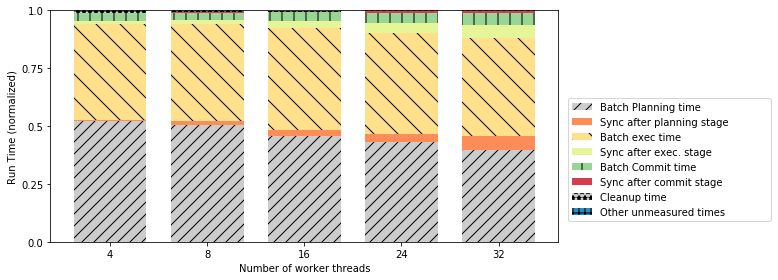

In [296]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

agg_params = {'wt_hl_plan_time':'mean',
            'wt_hl_sync_plan_time':'mean',
            'wt_hl_exec_time':'mean',
            'wt_hl_sync_exec_time':'mean',
            'wt_hl_commit_time':'mean',
            'wt_hl_sync_commit_time':'mean',
            'wt_hl_cleanup_time':'mean',
            'exec_batch_proc_time':'mean',
            'tput':'mean'
           }
    
def exetract_breakdown_from_file(_fname):
    res = {}
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('g_thread_cnt\s+(\d+)', cline)
            if m:
                res['g_thread_cnt'] = int(m.group(1))
            m = re.search('(\[summary\]) (.+)', cline)
            if m:
                sline = m.group(2).split(',')
                for i, a in enumerate(sline):
                    asline = a.split('=')
                    if asline[0] == 'tput':
                        res[asline[0]] = float(asline[1])
                    if asline[0] == 'fscl_avg':
                        res[asline[0]] = float(asline[1])
#                     print(i,a)
#                     if i == 1:
#                         asline = a.split('=')
#                         res[asline[0]] = asline[1]
#                     mq = re.search('quecc\_exec(\d)\_(\w+)=(\d+\.?\d*)', a)
                    mq = re.search('quecc\_?(exec|plan|wt)(\d+)\_(\w+)=(\d+\.?\d*)', a)
                    if mq:
#                         res['index'].append(int(i))
                        key = "{}_{}".format(mq.group(1),mq.group(3))
                        
                        row = [mq.group(2), key, mq.group(4)]
                        if key in res.keys():
                            res[key].append(float(mq.group(4)))
                        else:
                            res[key] =[float(mq.group(4))]
#                         print(row)
#                         print(a)
#                 print(sline[0])
#                 print(sline[1])
#                 print(sline[2])
#     print(res)
    return res;
dir1 = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_wtvar_lat_quecc_GS32'
resFiles = os.listdir(dir1)
i = 0
for fn1 in resFiles:    
    regex = "(pa(\d+)_)([A-Za-z]+|\d+)_pt(\d+)_et(\d+)_(\d+)_?(pptstrict|pptnonstrict)?_([A-Za-z]+)_(c|s)_t(\d+)_(\d+)(_(\d+))?.txt"
    rsize_re = "(\d+)Brec_.+"
    
    m = re.search(regex,fn1)
    if m:
        print(fn1)
        time_data = exetract_breakdown_from_file(dir1+"/"+fn1)
        df = pd.DataFrame(time_data)
    #     print(df)
    #     print(df['g_thread_cnt'])
        
        df = df.groupby('g_thread_cnt').agg(agg_params)
        if i == 0:
            combined = df
        else:
            combined = pd.concat([combined,df])
        i = i + 1
        
        
def plot_exec_times_hl_wt_agg(df):
    f, ax1 = plt.subplots(1, figsize=(8,4))
#     f, ax1 = plt.subplots(1)

    # Set the bar width
    bar_width = 0.75

    colors = ['#CCCCCC','#fc8d59','#fee08b','#e6f598','#99d594','#d53e4f', '#3288bd']

    # positions of the left bar-boundaries

    bar_l = [i-(0.75) for i in range(len(df['wt_hl_plan_time']))]    
    # wt_hl_plan_time
    ax1.bar(bar_l,
            df['wt_hl_plan_time'],
            width=bar_width,
            label='Batch Planning time',
            color=colors[0], hatch='//')

    # sync plan
    ax1.bar(bar_l,
            df['wt_hl_sync_plan_time'],
            width=bar_width,
            bottom=df['wt_hl_plan_time'],
            label='Sync after planning stage',
            color=colors[1])

    # exec time
    all_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time'])
    ax1.bar(bar_l,
            df['wt_hl_exec_time'],
            width=bar_width,
            bottom=all_df,
            label='Batch exec time',
            color=colors[2], hatch='\\')
    
    # sync_exec
    all_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time']+
          df['wt_hl_exec_time'])
    ax1.bar(bar_l,
            df['wt_hl_sync_exec_time'],
            width=bar_width,
            bottom=all_df,
            label='Sync after exec. stage',
            color=colors[3])
    
    # txn_commit_time
    all_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time']+
          df['wt_hl_exec_time']+df['wt_hl_sync_exec_time'])
    ax1.bar(bar_l,
            df['wt_hl_commit_time'],
            width=bar_width,
            bottom=all_df,
            label='Batch Commit time',
            color=colors[4], hatch='|')
    
    all_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time']+
              df['wt_hl_exec_time']+df['wt_hl_sync_exec_time']+
              df['wt_hl_commit_time'])
    ax1.bar(bar_l,
            df['wt_hl_sync_commit_time'],
            width=bar_width,
            bottom=all_df,
            label='Sync after commit stage',
            color=colors[5])
    all_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time']+
              df['wt_hl_exec_time']+df['wt_hl_sync_exec_time']+
              df['wt_hl_commit_time']+df['wt_hl_sync_commit_time'])
    ax1.bar(bar_l,
        df['wt_hl_cleanup_time'],
        width=bar_width,
        bottom=all_df,
        label='Cleanup time',
        color=colors[0], hatch='**')
        
    all_df = (df['wt_hl_plan_time']+df['wt_hl_sync_plan_time']+
              df['wt_hl_exec_time']+df['wt_hl_sync_exec_time']+
              df['wt_hl_commit_time']+df['wt_hl_sync_commit_time']+
              df['wt_hl_cleanup_time'])

    ax1.bar(bar_l,
            (df['exec_batch_proc_time']-all_df)/60,
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=all_df,
            label='Other unmeasured times',
            color=colors[6], hatch='++')

    # set the x ticks with names
#     plt.xticks(bar_l,['ET_'+str(i) for i in range(len(df['wt_hl_plan_time']))], rotation=45)
    plt.xticks(bar_l,combined.index.get_level_values(0))
    print(bar_l)
    ylabels = []
    ylabelvs = []
    for v in bar_l:
        l = (v + 0.75)/4.0
        ylabels.append(l)
        ylabelvs.append(l*60)
#     print(ylabels)
    plt.yticks(ylabelvs,ylabels)
    # Set the label and legends
    ax1.set_ylabel("Run Time (normalized)")
    ax1.set_xlabel("Number of worker threads")
    # plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1.02, 1.02, 0.4, -.4), loc=2,
               ncol=1, mode="expand", borderaxespad=0.)
    plt.tight_layout()

    figoutdir = '/Users/qadahtm/Google Drive/MBP2/PhDResearch/QueCC/paper_figs/'
    outfname = '{}ycsb-wtvar-tbreak-GS32.pdf'.format(figoutdir)
    plt.savefig(outfname,format='pdf')

combined = combined.groupby('g_thread_cnt').agg(agg_params)
plot_exec_times_hl_wt_agg(combined)
combined

In [301]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 18}

# matplotlib.rc('font', **font)    
# w = 0.19    



print("Parsing file ...")
# parseFile(datafiles[2], planners)
# fname = '/Users/qadahtm/Dev/halstead/ycsb_txns_theta0_wp100_1part_bsize100.txt'
# last_bb = parseFile(fname, planners,(1024*2),(1024*2))
# parseFileForStats(datafiles[2], planners)
# parseFileForStats(fname, planners)
print("Parsing Finished!")
# print(planners)
# print(buckets)

# Precomputed data

buckets_0 = [6255320, 6257435, 6258752, 6228533]
buckets_1 = [14344454, 4601588, 3336508, 2717490]
buckets_2 = [16409900, 3856648, 2650184, 2083308]

planners_0 = [[3129536, 3131653, 3128575, 3118406], [3125784, 3125782, 3130177, 3110127]]
planners_1 = [[7169667, 2300193, 1667773, 1358967], [7174787, 2301395, 1668735, 1358523]]
planners_11 = [[7167936, 2299492, 1668671, 1357141], [7176518, 2302096, 1667837, 1360349]]
planners_2 = [[8209417, 1928131, 1326439, 1040283], [8200483, 1928517, 1323745, 1043025]]
planners_21 = [[8202535, 1928081, 1324651, 1040663], [8207365, 1928567, 1325533, 1042645]]

# planners = [[4103191, 964295, 661774, 519860], [4102256, 965006, 663124, 520354], [4098977, 962325, 662525, 520943],
#             [4105476, 965022, 662761, 522151]]
# plot_figure(plt_buckets_keys,buckets_0, planners_0)
# plot_figure(plt_buckets_keys,buckets_1, planners_1)
# plot_figure(plt_buckets_keys,buckets_1, planners_2)
# plot_figure_oneset(plt_buckets_keys,buckets)

Parsing file ...
Parsing Finished!


In [302]:
buckets

[0,
 530,
 529,
 537,
 543,
 483,
 542,
 569,
 544,
 541,
 533,
 530,
 530,
 565,
 505,
 573,
 539,
 574,
 463,
 519,
 492,
 531,
 531,
 558,
 557,
 527,
 549,
 543,
 547,
 536,
 571,
 528,
 574,
 543,
 564,
 609,
 535,
 571,
 511,
 543,
 580,
 528,
 519,
 606,
 551,
 557,
 556,
 561,
 516,
 537,
 573,
 522,
 538,
 557,
 517,
 539,
 547,
 524,
 523,
 537,
 592,
 601,
 579,
 494,
 475,
 546,
 570,
 505,
 587,
 523,
 548,
 521,
 539,
 555,
 530,
 509,
 523,
 562,
 565,
 534,
 530,
 542,
 533,
 521,
 517,
 580,
 550,
 552,
 527,
 529,
 561,
 516,
 539,
 543,
 558,
 518,
 520,
 521,
 538,
 541,
 545,
 518,
 499,
 526,
 556,
 554,
 556,
 568,
 528,
 538,
 548,
 551,
 540,
 525,
 543,
 539,
 500,
 517,
 515,
 533,
 556,
 523,
 570,
 577,
 567,
 522,
 498,
 552,
 554,
 546,
 544,
 540,
 553,
 573,
 547,
 564,
 581,
 507,
 544,
 549,
 521,
 538,
 523,
 577,
 553,
 567,
 565,
 572,
 513,
 562,
 577,
 555,
 594,
 522,
 520,
 581,
 541,
 517,
 501,
 590,
 526,
 542,
 529,
 556,
 580,
 550,
 536,


In [303]:
import math
int(math.ceil(10*0.25))

3

1024


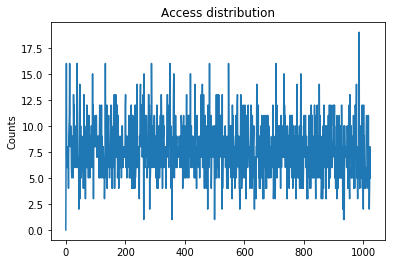

In [312]:
bb= [0, 1965, 1980, 1950, 2018, 1958, 1945, 1944, 1958, 2010, 1947, 2005, 1961, 1936, 1925, 2006, 1952, 2031, 1955, 1937, 1986, 2015, 2011, 1953, 2004, 2050, 1958, 1976, 1908, 1997, 1927, 1929, 1974, 1952, 1933, 2009, 1976, 1953, 1965, 1966, 1985, 1950, 1939, 1981, 2026, 1883, 2046, 2015, 1969, 1890, 2017, 1955, 2042, 1925, 1993, 1974, 1925, 1977, 2026, 1918, 1978, 1978, 2005, 1882, 1923, 1954, 1925, 1930, 1999, 1974, 1908, 1995, 1962, 1976, 1999, 2037, 1894, 1934, 1957, 1990, 1894, 1937, 1973, 1967, 1873, 1971, 1903, 1922, 1943, 2014, 1996, 1991, 1918, 1936, 1984, 1966, 1917, 1933, 1908, 1851, 2036, 1989, 1986, 1998, 1901, 1942, 1999, 1884, 1975, 1988, 1936, 1975, 1951, 2015, 1960, 1945, 2008, 1972, 2015, 2001, 2029, 1924, 1915, 1984, 1993, 1935, 1937, 1991, 854, 861, 855, 808, 845, 829, 817, 836, 886, 847, 804, 848, 834, 820, 861, 784, 813, 820, 902, 834, 879, 797, 811, 856, 857, 902, 846, 822, 839, 852, 825, 849, 883, 825, 842, 810, 834, 852, 807, 856, 798, 793, 810, 805, 834, 863, 824, 816, 826, 788, 848, 869, 817, 816, 860, 823, 843, 857, 843, 840, 813, 854, 846, 832, 805, 912, 874, 889, 862, 851, 788, 874, 845, 872, 847, 811, 887, 867, 825, 931, 861, 797, 851, 834, 848, 840, 848, 903, 864, 827, 823, 859, 820, 839, 846, 854, 823, 796, 802, 839, 842, 845, 853, 829, 873, 846, 851, 899, 888, 830, 781, 796, 865, 828, 826, 867, 819, 816, 832, 833, 883, 848, 834, 921, 790, 851, 804, 868, 833, 806, 854, 825, 851, 855, 817, 811, 849, 912, 867, 791, 828, 840, 920, 862, 797, 785, 855, 845, 829, 855, 898, 818, 885, 880, 820, 827, 874, 854, 831, 821, 897, 828, 812, 821, 815, 891, 840, 856, 838, 835, 792, 858, 844, 794, 859, 819, 827, 860, 816, 854, 810, 821, 829, 851, 870, 835, 822, 809, 811, 838, 848, 893, 858, 865, 848, 844, 838, 841, 837, 823, 832, 844, 827, 805, 793, 869, 841, 854, 856, 822, 826, 855, 833, 869, 847, 856, 796, 756, 852, 851, 884, 844, 811, 922, 862, 868, 860, 821, 813, 811, 874, 842, 853, 863, 842, 844, 817, 824, 849, 882, 888, 862, 850, 888, 848, 890, 839, 821, 776, 846, 838, 825, 874, 827, 880, 871, 864, 805, 818, 774, 820, 835, 816, 853, 809, 805, 863, 841, 828, 869, 834, 896, 822, 834, 847, 811, 837, 823, 831, 822, 848, 812, 815, 873, 821, 854, 820, 847, 815, 845, 844, 821, 825, 838, 822, 783, 839, 843, 838, 824, 832, 817, 882, 816, 863, 897, 823, 800, 864, 813, 844, 841, 837, 807, 820, 824, 829, 757, 892, 881, 922, 880, 817, 809, 805, 880, 847, 778, 866, 807, 885, 883, 872, 849, 850, 850, 861, 780, 837, 814, 867, 827, 849, 880, 865, 819, 839, 786, 883, 858, 829, 871, 838, 868, 878, 800, 793, 847, 874, 873, 801, 885, 857, 821, 852, 842, 840, 849, 776, 923, 825, 798, 866, 876, 867, 901, 789, 814, 853, 829, 851, 867, 883, 839, 792, 844, 853, 797, 827, 842, 877, 837, 873, 839, 835, 868, 840, 893, 834, 840, 836, 841, 805, 796, 851, 872, 874, 831, 836, 815, 807, 808, 789, 896, 832, 829, 860, 825, 818, 842, 907, 826, 867, 837, 838, 830, 812, 813, 802, 841, 812, 846, 865, 816, 853, 762, 839, 813, 808, 844, 805, 800, 792, 861, 846, 836, 824, 841, 857, 817, 844, 823, 776, 811, 819, 876, 837, 869, 817, 851, 804, 877, 789, 856, 798, 842, 851, 804, 838, 816, 870, 838, 899, 850, 847, 844, 813, 764, 869, 791, 853, 872, 823, 837, 784, 862, 813, 807, 837, 863, 837, 831, 871, 787, 801, 838, 847, 840, 864, 856, 825, 837, 818, 847, 874, 838, 867, 859, 822, 854, 811, 837, 782, 857, 817, 835, 869, 865, 886, 870, 854, 825, 834, 823, 901, 817, 853, 804, 851, 831, 851, 822, 866, 811, 822, 813, 837, 907, 808, 860, 826, 814, 818, 820, 796, 777, 829, 869, 830, 802, 854, 831, 841, 831, 815, 876, 815, 874, 812, 839, 800, 852, 827, 842, 853, 802, 865, 866, 851, 834, 817, 838, 839, 787, 818, 862, 859, 807, 844, 830, 884, 826, 812, 839, 824, 813, 800, 848, 853, 825, 870, 816, 880, 865, 852, 804, 864, 835, 871, 803, 871, 863, 801, 855, 822, 835, 830, 826, 878, 858, 827, 863, 884, 869, 796, 791, 878, 829, 808, 826, 869, 807, 815, 843, 802, 833, 900, 892, 799, 829, 833, 879, 874, 793, 871, 852, 846, 840, 822, 857, 795, 861, 836, 774, 830, 810, 842, 827, 836, 835, 795, 879, 821, 833, 868, 791, 805, 863, 875, 842, 877, 895, 833, 828, 861, 821, 871, 862, 879, 818, 792, 833, 858, 801, 855, 827, 837, 785, 857, 873, 855, 845, 834, 842, 852, 807, 839, 865, 856, 846, 853, 816, 838, 825, 792, 832, 823, 829, 821, 807, 826, 815, 870, 776, 829, 806, 815, 798, 861, 856, 809, 782, 887, 806, 808, 879, 858, 865, 800, 824, 859, 795, 814, 831, 855, 857, 820, 825, 843, 820, 820, 836, 857, 769, 853, 839, 820, 818, 768, 819, 836, 816, 815, 803, 824, 849, 839, 834, 816, 847, 811, 802, 797, 807, 850, 881, 820, 843, 852, 783, 795, 831, 816, 804, 793, 805, 839, 841, 809, 828, 779, 834, 812, 826, 832, 848, 853, 808, 820, 883, 865, 835, 813, 865, 834, 884, 894, 861, 800, 855, 851, 801, 898, 832, 890, 840, 795, 831, 884, 836, 849, 834, 883, 878, 809, 848, 880, 875, 851, 817, 828, 809, 842, 827, 843, 789, 837, 826, 828, 844, 846, 845, 836, 841, 822, 808, 823, 774, 846, 820, 805, 837, 838, 780, 804, 835, 846, 836, 809, 829, 844, 856, 796, 797, 841, 862, 819, 773, 813, 800, 871, 858, 855, 831, 843, 862, 833, 786, 832, 857, 848, 855, 835, 836, 818, 844, 852, 829, 868, 857, 876, 843, 845, 888, 847, 761, 923, 825, 840, 798, 875, 832, 807, 850, 824, 869, 839, 875, 839, 849, 858, 821, 867, 838, 804, 834]
bb = [0, 3994, 3939, 3938, 3937, 3957, 3895, 4034, 3951, 3954, 3992, 3955, 3934, 3913, 3845, 3954, 3961, 3769, 3996, 3833, 3910, 3882, 4014, 3913, 3828, 3924, 4022, 3947, 3874, 3953, 3871, 4030, 3923, 4036, 4004, 4038, 3931, 3943, 3981, 3973, 3926, 3842, 3832, 4000, 3887, 3918, 3879, 3968, 3857, 3980, 3909, 4032, 3913, 4003, 3962, 4025, 3966, 4050, 3948, 4014, 3868, 3978, 3844, 3884, 3849, 3995, 3997, 3921, 3913, 3921, 3815, 3952, 3861, 3949, 4006, 3986, 3997, 3914, 4041, 3894, 3877, 3908, 3858, 3942, 3971, 3946, 3837, 3884, 3939, 3941, 3959, 3915, 3983, 3969, 3938, 3911, 4086, 3839, 3874, 3904, 3896, 3869, 3929, 3811, 3909, 4013, 3898, 3992, 3959, 3886, 3868, 3939, 3954, 3815, 3931, 3939, 3921, 3955, 3951, 3964, 3937, 3972, 3817, 3893, 3847, 3909, 3874, 3952, 0, 570, 559, 575, 583, 566, 571, 542, 537, 583, 554, 574, 526, 590, 582, 556, 596, 589, 574, 542, 592, 568, 571, 564, 574, 595, 540, 560, 531, 561, 572, 558, 561, 524, 523, 553, 545, 519, 617, 570, 584, 556, 527, 591, 555, 591, 601, 583, 575, 554, 569, 571, 567, 597, 565, 544, 560, 562, 529, 594, 556, 616, 562, 586, 538, 530, 563, 594, 577, 522, 545, 584, 557, 550, 585, 549, 577, 560, 535, 591, 579, 564, 532, 521, 548, 570, 569, 570, 551, 580, 566, 570, 544, 555, 568, 627, 531, 571, 530, 558, 567, 570, 554, 562, 548, 551, 596, 556, 546, 605, 576, 518, 539, 565, 545, 559, 575, 560, 550, 567, 566, 570, 567, 560, 592, 542, 549, 598, 0, 602, 556, 531, 545, 554, 574, 559, 559, 593, 608, 554, 588, 541, 549, 556, 628, 601, 566, 602, 560, 540, 577, 544, 579, 582, 542, 547, 546, 559, 589, 582, 565, 564, 543, 574, 564, 551, 579, 539, 542, 595, 549, 550, 555, 562, 548, 573, 557, 569, 559, 562, 563, 586, 605, 536, 592, 591, 538, 573, 546, 581, 559, 584, 554, 572, 580, 573, 561, 585, 590, 595, 556, 577, 526, 515, 573, 524, 586, 570, 590, 552, 567, 562, 538, 597, 563, 606, 558, 575, 609, 527, 589, 636, 529, 549, 540, 557, 570, 569, 559, 586, 581, 593, 569, 569, 553, 545, 577, 562, 578, 560, 555, 566, 552, 552, 551, 587, 521, 555, 544, 578, 606, 591, 578, 556, 571, 598, 0, 570, 563, 578, 516, 570, 530, 573, 534, 588, 593, 591, 569, 561, 576, 576, 573, 576, 599, 595, 577, 557, 543, 564, 584, 613, 603, 595, 587, 541, 557, 553, 601, 592, 577, 594, 571, 544, 567, 568, 570, 599, 582, 560, 609, 597, 540, 556, 555, 566, 567, 595, 553, 591, 573, 581, 533, 547, 562, 560, 553, 569, 552, 545, 577, 568, 559, 540, 564, 574, 604, 563, 558, 533, 608, 570, 563, 574, 563, 591, 536, 575, 574, 594, 580, 581, 617, 545, 581, 611, 563, 568, 573, 564, 541, 605, 569, 529, 583, 543, 542, 580, 563, 591, 527, 540, 548, 604, 583, 563, 566, 548, 528, 530, 592, 528, 536, 563, 573, 518, 557, 534, 577, 600, 578, 549, 549, 559, 0, 571, 523, 541, 530, 584, 543, 512, 534, 564, 533, 598, 540, 572, 573, 516, 580, 538, 555, 558, 556, 536, 597, 523, 553, 549, 570, 547, 538, 558, 524, 569, 555, 559, 543, 529, 572, 566, 530, 576, 549, 546, 524, 569, 543, 539, 540, 590, 591, 548, 555, 592, 587, 525, 538, 566, 592, 586, 594, 610, 593, 555, 544, 525, 551, 539, 549, 554, 529, 536, 531, 566, 538, 542, 525, 543, 618, 576, 598, 541, 594, 575, 523, 514, 559, 524, 567, 589, 545, 575, 576, 595, 550, 575, 561, 540, 585, 592, 529, 548, 550, 558, 533, 564, 528, 543, 549, 547, 518, 561, 561, 590, 565, 595, 584, 535, 550, 583, 540, 590, 546, 476, 582, 583, 544, 620, 555, 571, 0, 603, 558, 531, 558, 567, 518, 570, 551, 574, 553, 623, 534, 580, 551, 583, 523, 571, 536, 514, 555, 536, 505, 569, 554, 521, 585, 556, 556, 561, 563, 544, 555, 578, 550, 604, 584, 572, 553, 583, 613, 555, 571, 519, 539, 498, 571, 585, 583, 541, 535, 563, 569, 553, 551, 565, 569, 568, 575, 552, 553, 537, 581, 552, 532, 593, 620, 557, 590, 549, 557, 521, 595, 579, 524, 575, 556, 569, 565, 580, 550, 531, 560, 577, 566, 577, 537, 567, 576, 547, 633, 565, 605, 591, 519, 579, 581, 533, 529, 541, 535, 549, 527, 544, 540, 568, 559, 575, 572, 580, 533, 518, 578, 560, 579, 514, 517, 579, 581, 577, 583, 603, 531, 554, 558, 539, 601, 584, 0, 565, 574, 544, 527, 606, 579, 592, 548, 592, 605, 543, 543, 577, 568, 579, 566, 573, 556, 601, 564, 533, 563, 559, 563, 551, 576, 545, 558, 558, 520, 574, 606, 566, 597, 548, 552, 576, 539, 540, 564, 558, 596, 583, 565, 560, 586, 569, 586, 565, 598, 589, 618, 576, 567, 552, 583, 578, 563, 565, 589, 588, 568, 547, 543, 555, 566, 574, 561, 581, 547, 597, 568, 550, 556, 547, 570, 593, 550, 605, 552, 560, 567, 580, 555, 547, 534, 598, 580, 586, 591, 551, 577, 563, 604, 547, 580, 584, 578, 592, 566, 551, 570, 544, 529, 600, 546, 516, 545, 570, 594, 554, 579, 549, 577, 609, 568, 557, 559, 548, 585, 589, 568, 563, 565, 536, 577, 545, 0, 564, 549, 571, 528, 549, 542, 558, 520, 537, 543, 564, 553, 540, 526, 544, 550, 588, 547, 590, 538, 527, 567, 572, 577, 551, 591, 591, 538, 606, 550, 555, 534, 536, 552, 591, 561, 592, 493, 581, 569, 573, 583, 542, 542, 573, 559, 549, 568, 554, 562, 626, 556, 544, 544, 549, 570, 600, 535, 572, 550, 574, 600, 565, 541, 548, 572, 606, 562, 560, 582, 570, 561, 547, 571, 574, 520, 540, 552, 561, 538, 535, 544, 534, 553, 560, 530, 589, 601, 565, 575, 566, 557, 569, 578, 591, 581, 557, 583, 540, 590, 550, 550, 536, 568, 577, 569, 516, 579, 549, 528, 564, 550, 570, 558, 546, 552, 574, 581, 537, 561, 585, 545, 570, 534, 571, 554, 596]
bb = [0, 1692, 1633, 1635, 1609, 1632, 1627, 1592, 1726, 1638, 1675, 1706, 1728, 1658, 1646, 1631, 1649, 1710, 1621, 1636, 1720, 1667, 1698, 1684, 1640, 1638, 1662, 1664, 1686, 1582, 1712, 1662, 1677, 1669, 1735, 1713, 1679, 1740, 1731, 1737, 1678, 1649, 1603, 1618, 1667, 1709, 1707, 1613, 1724, 1785, 1666, 1713, 1672, 1639, 1629, 1666, 1686, 1664, 1656, 1636, 1674, 1680, 1653, 1664, 1634, 1675, 1583, 1742, 1684, 1704, 1648, 1693, 1693, 1615, 1598, 1664, 1601, 1737, 1628, 1720, 1654, 1651, 1703, 1621, 1725, 1744, 1711, 1692, 1650, 1652, 1693, 1684, 1677, 1717, 1652, 1677, 1616, 1624, 1647, 1711, 1660, 1650, 1675, 1638, 1657, 1694, 1668, 1641, 1711, 1606, 1672, 1642, 1661, 1650, 1600, 1594, 1670, 1674, 1673, 1716, 1635, 1674, 1672, 1686, 1607, 1669, 1679, 1648, 0, 857, 853, 877, 895, 930, 860, 897, 858, 865, 886, 903, 898, 907, 885, 945, 890, 920, 928, 844, 905, 890, 910, 924, 896, 907, 923, 852, 865, 928, 878, 862, 853, 904, 851, 879, 883, 888, 895, 903, 874, 924, 904, 903, 893, 842, 849, 915, 894, 831, 896, 859, 910, 914, 872, 857, 922, 872, 939, 899, 837, 906, 867, 873, 889, 933, 918, 865, 910, 932, 858, 869, 903, 856, 889, 864, 878, 922, 834, 918, 847, 934, 904, 916, 870, 910, 913, 894, 867, 874, 925, 876, 881, 864, 917, 882, 886, 871, 813, 902, 846, 879, 880, 914, 933, 874, 876, 849, 903, 845, 848, 868, 879, 866, 877, 900, 890, 903, 891, 859, 835, 877, 885, 883, 824, 846, 890, 863, 0, 925, 903, 900, 899, 834, 872, 862, 939, 916, 884, 902, 875, 950, 881, 896, 880, 915, 892, 913, 899, 835, 865, 874, 888, 899, 872, 947, 883, 922, 912, 858, 897, 883, 904, 886, 824, 920, 884, 870, 867, 851, 895, 970, 915, 884, 949, 884, 910, 853, 885, 896, 917, 883, 898, 890, 926, 862, 908, 927, 916, 878, 952, 905, 925, 850, 938, 817, 885, 868, 871, 914, 834, 860, 884, 919, 885, 826, 889, 887, 917, 898, 900, 891, 855, 881, 857, 898, 873, 832, 864, 893, 888, 875, 902, 896, 820, 893, 899, 892, 862, 894, 893, 932, 894, 875, 906, 854, 902, 903, 864, 873, 851, 934, 922, 892, 877, 868, 861, 831, 932, 936, 890, 936, 909, 877, 862, 866, 0, 947, 927, 897, 871, 893, 884, 846, 860, 858, 892, 921, 874, 888, 945, 864, 926, 914, 887, 909, 875, 899, 857, 865, 869, 916, 879, 915, 888, 851, 895, 871, 915, 848, 908, 899, 882, 928, 940, 901, 885, 891, 909, 845, 857, 898, 873, 907, 890, 869, 901, 884, 935, 870, 875, 863, 876, 878, 885, 864, 904, 919, 936, 871, 891, 879, 928, 908, 875, 889, 912, 850, 864, 907, 900, 909, 924, 840, 896, 903, 866, 850, 907, 898, 874, 915, 929, 882, 887, 852, 868, 875, 855, 812, 923, 950, 922, 863, 874, 854, 866, 899, 902, 832, 864, 830, 920, 883, 891, 915, 903, 911, 910, 864, 851, 877, 849, 868, 877, 859, 792, 911, 922, 931, 896, 914, 888, 855, 0, 888, 874, 866, 888, 951, 884, 912, 837, 886, 945, 862, 937, 932, 911, 851, 892, 920, 892, 862, 860, 878, 866, 890, 779, 860, 869, 853, 914, 957, 876, 919, 912, 886, 934, 915, 904, 869, 884, 892, 879, 880, 864, 834, 921, 865, 895, 856, 933, 864, 917, 893, 837, 869, 857, 936, 850, 892, 885, 862, 942, 857, 942, 919, 870, 877, 846, 911, 883, 847, 900, 957, 853, 854, 906, 873, 919, 824, 852, 906, 918, 865, 883, 914, 921, 901, 859, 906, 903, 871, 899, 923, 890, 924, 860, 882, 919, 905, 850, 930, 903, 872, 908, 883, 848, 900, 930, 841, 859, 879, 850, 891, 882, 900, 883, 850, 833, 884, 913, 855, 908, 881, 896, 894, 912, 855, 933, 926, 0, 853, 899, 844, 901, 982, 880, 839, 917, 884, 916, 921, 881, 862, 860, 886, 872, 884, 913, 870, 908, 906, 844, 941, 873, 883, 878, 882, 886, 905, 991, 907, 896, 885, 859, 891, 868, 871, 972, 842, 917, 894, 859, 851, 942, 889, 911, 889, 925, 881, 874, 902, 889, 861, 921, 928, 857, 865, 922, 924, 900, 890, 927, 920, 867, 905, 856, 888, 934, 854, 936, 860, 902, 904, 858, 915, 907, 929, 884, 917, 869, 906, 963, 885, 841, 862, 864, 889, 918, 846, 819, 856, 899, 837, 917, 896, 839, 857, 885, 852, 828, 869, 865, 884, 869, 884, 939, 884, 911, 895, 878, 913, 860, 908, 897, 888, 871, 866, 882, 925, 920, 912, 871, 836, 949, 892, 863, 945, 0, 882, 879, 925, 901, 898, 877, 930, 852, 872, 829, 915, 829, 863, 903, 901, 863, 930, 967, 852, 903, 853, 913, 894, 899, 884, 860, 880, 842, 896, 918, 870, 788, 895, 877, 962, 843, 856, 898, 921, 876, 900, 947, 930, 878, 902, 855, 886, 867, 865, 880, 893, 892, 882, 865, 891, 834, 889, 883, 813, 942, 900, 951, 893, 827, 857, 874, 865, 898, 880, 883, 852, 874, 938, 894, 911, 885, 854, 892, 850, 889, 840, 887, 898, 962, 928, 910, 887, 888, 863, 879, 900, 873, 904, 867, 905, 902, 918, 819, 888, 858, 871, 876, 887, 908, 881, 822, 912, 870, 909, 868, 922, 889, 880, 903, 927, 868, 856, 871, 890, 917, 870, 896, 863, 921, 887, 893, 817, 0, 850, 824, 874, 868, 865, 914, 825, 913, 849, 902, 882, 883, 832, 905, 892, 880, 965, 833, 900, 841, 894, 882, 871, 907, 864, 908, 898, 877, 921, 905, 853, 874, 943, 874, 921, 879, 924, 934, 858, 888, 813, 879, 884, 912, 923, 906, 888, 864, 889, 858, 908, 902, 892, 895, 862, 908, 873, 793, 841, 807, 905, 926, 841, 887, 899, 888, 857, 922, 937, 812, 897, 878, 883, 850, 854, 844, 851, 921, 847, 883, 883, 894, 877, 864, 892, 891, 876, 850, 895, 885, 824, 893, 896, 847, 892, 875, 876, 890, 893, 866, 879, 915, 924, 906, 863, 871, 911, 883, 884, 815, 851, 939, 914, 903, 910, 863, 914, 901, 904, 902, 948, 880, 852, 855, 903, 858, 900]
bb= [125040, 125040, 125040, 125040, 125040, 125040, 125040, 125040]
bb = [0, 10362, 7565, 6701, 5474, 4595, 3843, 3459, 3221, 2760, 2487, 2413, 2132, 2038, 1869, 1739, 1722, 1555, 1533, 1474, 1436, 1378, 1245, 1248, 1199, 1184, 1098, 1180, 996, 972, 983, 966, 908, 924, 892, 833, 811, 769, 793, 773, 798, 745, 723, 734, 701, 678, 646, 658, 622, 675, 624, 607, 609, 550, 559, 543, 556, 549, 519, 552, 520, 540, 486, 529, 503, 480, 439, 491, 439, 473, 438, 416, 470, 451, 467, 356, 410, 391, 407, 422, 381, 389, 410, 394, 380, 425, 337, 395, 345, 374, 358, 343, 410, 344, 346, 385, 331, 367, 352, 345, 320, 274, 341, 363, 327, 304, 309, 291, 319, 309, 292, 328, 306, 295, 293, 311, 316, 311, 291, 278, 271, 295, 262, 259, 268, 269, 270, 251, 1226, 2836, 2057, 1917, 1663, 1574, 1502, 1411, 1435, 1401, 1370, 1281, 1289, 1259, 1351, 1248, 1266, 1230, 1221, 1250, 1172, 1166, 1138, 1176, 1116, 1200, 1139, 1131, 1089, 1113, 1072, 1065, 1096, 1078, 1058, 1009, 1044, 1008, 1042, 1035, 1015, 1067, 974, 987, 980, 1021, 988, 992, 976, 990, 975, 1007, 1021, 934, 1010, 928, 891, 908, 927, 849, 892, 887, 940, 928, 895, 877, 896, 852, 874, 894, 837, 808, 882, 868, 839, 880, 853, 872, 848, 827, 867, 818, 846, 825, 794, 778, 812, 805, 782, 805, 731, 777, 792, 841, 768, 799, 775, 781, 785, 806, 784, 761, 759, 751, 738, 768, 727, 738, 750, 729, 735, 763, 748, 694, 673, 740, 693, 707, 715, 727, 724, 732, 670, 686, 798, 717, 715, 688, 1101, 2786, 1917, 1767, 1538, 1463, 1395, 1360, 1333, 1322, 1262, 1277, 1195, 1146, 1135, 1140, 1145, 1067, 1135, 1115, 1075, 1118, 1075, 1073, 1087, 1075, 1101, 1089, 1031, 1043, 1035, 1064, 1031, 1080, 1032, 1056, 1034, 1045, 1000, 975, 970, 1021, 972, 970, 979, 1012, 979, 1001, 960, 937, 949, 941, 961, 981, 944, 1006, 960, 950, 905, 885, 933, 948, 882, 931, 880, 918, 899, 896, 881, 869, 871, 917, 879, 878, 873, 908, 845, 847, 941, 876, 920, 885, 840, 850, 859, 833, 839, 886, 805, 893, 889, 820, 805, 862, 820, 854, 875, 797, 785, 845, 795, 814, 783, 796, 798, 791, 818, 814, 781, 886, 806, 793, 816, 838, 770, 788, 843, 751, 775, 752, 809, 770, 823, 721, 770, 776, 746, 782, 1046, 2714, 1950, 1715, 1568, 1352, 1254, 1335, 1218, 1225, 1248, 1157, 1234, 1107, 1209, 1115, 1073, 1132, 1093, 1052, 1043, 1050, 1058, 1062, 1042, 1039, 1029, 1031, 1025, 1002, 1034, 1003, 1019, 1019, 995, 1000, 992, 970, 1001, 984, 1044, 989, 969, 938, 953, 950, 953, 927, 935, 951, 901, 966, 979, 914, 938, 914, 862, 941, 943, 945, 956, 930, 909, 963, 1006, 897, 918, 945, 921, 975, 868, 887, 894, 921, 874, 965, 874, 854, 882, 872, 895, 864, 914, 911, 901, 886, 843, 840, 891, 888, 890, 825, 858, 823, 872, 890, 843, 878, 839, 844, 860, 865, 889, 847, 843, 812, 821, 858, 836, 859, 802, 850, 872, 794, 803, 817, 835, 809, 816, 852, 816, 809, 766, 837, 842, 788, 797, 832, 976, 2661, 1884, 1641, 1465, 1393, 1306, 1241, 1262, 1187, 1146, 1143, 1159, 1183, 1166, 1126, 1148, 1123, 1048, 1017, 1049, 1073, 1047, 1053, 1063, 1016, 1012, 1030, 991, 975, 1015, 1008, 1010, 1008, 988, 1017, 958, 1037, 1009, 1011, 1032, 980, 977, 997, 964, 963, 855, 891, 924, 1006, 935, 987, 949, 1005, 1001, 936, 895, 932, 990, 940, 940, 937, 874, 913, 882, 918, 949, 881, 919, 948, 923, 882, 940, 917, 907, 934, 909, 901, 872, 910, 893, 908, 880, 906, 858, 832, 874, 869, 847, 900, 861, 870, 849, 894, 865, 851, 858, 800, 860, 892, 892, 887, 857, 883, 854, 855, 896, 849, 850, 829, 845, 814, 879, 894, 781, 848, 865, 906, 784, 803, 789, 804, 813, 839, 836, 799, 816, 846, 972, 2618, 1866, 1755, 1502, 1403, 1306, 1253, 1191, 1185, 1168, 1175, 1080, 1168, 1082, 1138, 1120, 1046, 1055, 1096, 1028, 1072, 1009, 1051, 1044, 1030, 1015, 995, 991, 927, 1013, 1018, 960, 963, 997, 1003, 986, 943, 1015, 997, 954, 956, 947, 994, 950, 947, 968, 935, 973, 955, 914, 922, 954, 936, 974, 945, 938, 910, 942, 944, 897, 966, 888, 930, 859, 874, 848, 881, 893, 938, 901, 872, 940, 940, 901, 904, 912, 932, 868, 911, 880, 869, 948, 894, 892, 875, 909, 920, 898, 892, 878, 896, 903, 857, 871, 894, 829, 907, 820, 856, 870, 904, 830, 891, 853, 866, 830, 906, 824, 835, 875, 858, 882, 851, 867, 933, 862, 830, 822, 864, 886, 866, 824, 870, 832, 883, 842, 847, 1003, 2695, 1813, 1654, 1444, 1386, 1339, 1274, 1213, 1198, 1182, 1150, 1060, 1080, 1110, 1136, 1029, 1081, 1023, 1051, 1035, 1065, 1018, 1040, 1043, 1016, 995, 990, 961, 998, 1010, 1026, 945, 1013, 1025, 948, 986, 976, 974, 902, 951, 954, 960, 973, 957, 955, 948, 936, 920, 899, 921, 954, 921, 981, 931, 959, 918, 922, 943, 996, 889, 958, 941, 916, 970, 922, 928, 930, 907, 867, 968, 858, 888, 990, 910, 901, 917, 928, 925, 917, 915, 861, 881, 940, 896, 864, 931, 854, 885, 914, 854, 894, 858, 913, 897, 937, 892, 911, 882, 891, 873, 868, 842, 848, 852, 909, 868, 874, 821, 853, 827, 879, 866, 869, 778, 839, 838, 848, 847, 806, 860, 841, 852, 886, 842, 872, 878, 918, 901, 2621, 1805, 1662, 1473, 1461, 1326, 1201, 1178, 1136, 1119, 1081, 1119, 1110, 1077, 1087, 1077, 1084, 1011, 1034, 1050, 1002, 1035, 1030, 1009, 980, 1051, 1023, 1027, 951, 1054, 1023, 957, 963, 953, 980, 965, 1007, 932, 953, 963, 941, 944, 990, 941, 1003, 934, 913, 959, 966, 927, 889, 921, 986, 946, 884, 934, 912, 909, 1001, 966, 926, 957, 970, 927, 886, 949, 929, 945, 837, 921, 917, 911, 921, 901, 907, 911, 878, 885, 959, 890, 923, 874, 921, 925, 901, 908, 866, 860, 905, 890, 865, 915, 877, 930, 927, 874, 867, 887, 875, 896, 852, 875, 875, 839, 879, 878, 887, 891, 814, 832, 902, 881, 844, 869, 871, 870, 901, 877, 896, 903, 859, 825, 868, 883, 825, 913, 881]
bb = [0, 30120, 17314, 14007, 10431, 8380, 7035, 6132, 5324, 4724, 4240, 3966, 3587, 3422, 3268, 3067, 2735, 2734, 2556, 2269, 2234, 2165, 2079, 1998, 1977, 1930, 1716, 1650, 1664, 1578, 1657, 1556, 1574, 1423, 1392, 1361, 1342, 1272, 1255, 1193, 1221, 1141, 1131, 1165, 1131, 1088, 1032, 1047, 975, 968, 1038, 1006, 1018, 920, 884, 944, 926, 888, 958, 791, 816, 814, 830, 815, 771, 774, 795, 786, 769, 771, 748, 736, 712, 668, 695, 683, 663, 620, 658, 648, 682, 666, 611, 630, 576, 584, 595, 626, 620, 556, 596, 561, 592, 581, 572, 548, 564, 580, 552, 535, 510, 511, 532, 536, 498, 511, 506, 474, 505, 532, 492, 463, 448, 476, 442, 474, 480, 470, 473, 438, 445, 453, 455, 452, 442, 460, 430, 422, 1226, 3022, 2177, 1931, 1725, 1651, 1551, 1503, 1442, 1349, 1309, 1354, 1290, 1318, 1232, 1196, 1212, 1231, 1196, 1222, 1178, 1179, 1190, 1154, 1141, 1048, 1083, 1091, 1065, 1045, 1042, 1075, 1022, 1061, 1048, 992, 1024, 1006, 1009, 1032, 994, 1044, 979, 1022, 990, 904, 986, 1016, 933, 953, 933, 929, 955, 957, 909, 945, 914, 862, 851, 839, 873, 892, 898, 886, 868, 838, 899, 863, 852, 910, 802, 829, 811, 861, 848, 752, 827, 822, 811, 802, 803, 765, 778, 785, 804, 762, 802, 761, 786, 776, 725, 774, 778, 758, 747, 743, 723, 745, 749, 738, 683, 737, 740, 785, 688, 733, 687, 722, 730, 713, 719, 680, 724, 700, 745, 681, 665, 716, 710, 676, 737, 662, 667, 665, 664, 698, 649, 656, 939, 2789, 1963, 1729, 1430, 1396, 1305, 1340, 1208, 1219, 1158, 1131, 1176, 1125, 1109, 1069, 1053, 1001, 1054, 1023, 1018, 1012, 1001, 945, 956, 966, 948, 946, 938, 955, 1037, 911, 904, 979, 888, 918, 920, 841, 940, 900, 901, 882, 893, 988, 907, 888, 864, 865, 881, 834, 856, 855, 848, 866, 820, 880, 801, 902, 827, 891, 865, 839, 828, 824, 842, 760, 818, 805, 813, 803, 824, 813, 828, 829, 759, 763, 759, 777, 769, 762, 798, 747, 774, 762, 787, 823, 736, 775, 734, 726, 736, 780, 727, 725, 782, 771, 720, 794, 741, 729, 732, 761, 731, 695, 698, 753, 737, 720, 712, 744, 703, 725, 723, 735, 739, 712, 701, 685, 702, 733, 679, 720, 723, 647, 701, 652, 693, 673, 872, 2665, 1888, 1617, 1497, 1428, 1209, 1176, 1152, 1131, 1067, 1017, 1038, 995, 993, 963, 970, 916, 928, 912, 995, 942, 921, 983, 924, 958, 937, 897, 894, 870, 842, 853, 861, 935, 825, 836, 891, 859, 924, 830, 877, 813, 880, 817, 842, 833, 821, 857, 853, 847, 906, 857, 840, 807, 792, 785, 815, 775, 818, 778, 824, 785, 772, 817, 769, 834, 806, 747, 818, 782, 791, 806, 794, 786, 787, 798, 758, 784, 766, 763, 737, 758, 792, 788, 748, 728, 775, 725, 753, 732, 754, 760, 753, 761, 728, 701, 770, 718, 746, 740, 682, 758, 696, 779, 734, 747, 706, 775, 744, 771, 691, 742, 774, 754, 727, 700, 708, 710, 720, 726, 671, 754, 705, 667, 784, 697, 693, 729, 766, 2676, 1832, 1558, 1423, 1274, 1179, 1161, 1152, 1062, 1065, 1061, 1003, 998, 942, 1025, 918, 979, 880, 932, 898, 878, 921, 860, 918, 898, 884, 859, 864, 807, 823, 903, 881, 862, 882, 845, 846, 811, 859, 877, 814, 811, 866, 822, 850, 833, 780, 862, 790, 787, 847, 780, 764, 796, 790, 809, 808, 824, 777, 751, 768, 746, 794, 801, 771, 805, 824, 799, 826, 764, 794, 778, 757, 775, 728, 727, 783, 729, 806, 777, 706, 764, 758, 733, 745, 768, 791, 770, 742, 810, 706, 717, 740, 735, 732, 704, 695, 734, 747, 773, 723, 742, 752, 771, 764, 714, 721, 719, 741, 771, 718, 698, 734, 713, 699, 693, 729, 745, 741, 749, 726, 689, 712, 659, 670, 661, 693, 677, 771, 2605, 1833, 1543, 1407, 1309, 1189, 1082, 1092, 1052, 1064, 990, 944, 984, 946, 928, 950, 965, 921, 951, 938, 887, 855, 867, 890, 875, 841, 875, 867, 891, 869, 833, 862, 922, 855, 831, 806, 773, 791, 850, 830, 812, 822, 773, 838, 850, 783, 788, 761, 800, 760, 802, 765, 797, 810, 751, 815, 800, 802, 806, 739, 799, 774, 787, 761, 826, 822, 761, 726, 757, 717, 717, 744, 765, 778, 770, 782, 755, 738, 766, 722, 786, 768, 790, 757, 708, 784, 758, 773, 772, 754, 773, 742, 668, 653, 724, 735, 661, 744, 750, 687, 680, 714, 702, 678, 663, 712, 736, 747, 729, 712, 725, 730, 702, 737, 712, 716, 748, 726, 736, 705, 682, 680, 713, 675, 740, 664, 698, 809, 2503, 1750, 1551, 1396, 1275, 1173, 1093, 1082, 1031, 945, 1029, 948, 945, 956, 950, 918, 968, 961, 886, 860, 866, 868, 858, 847, 856, 869, 843, 847, 849, 851, 825, 850, 825, 848, 806, 871, 781, 780, 791, 836, 819, 826, 817, 813, 788, 817, 852, 801, 770, 795, 791, 758, 788, 763, 752, 746, 820, 798, 812, 818, 800, 730, 751, 727, 826, 750, 780, 781, 775, 757, 784, 777, 758, 726, 727, 755, 781, 764, 772, 724, 735, 741, 746, 737, 759, 739, 743, 766, 720, 711, 704, 760, 726, 761, 755, 711, 703, 736, 731, 702, 688, 702, 723, 740, 732, 692, 723, 743, 664, 732, 670, 735, 736, 702, 705, 671, 744, 679, 691, 687, 706, 738, 721, 642, 668, 712, 717, 757, 2551, 1784, 1550, 1257, 1220, 1172, 1073, 1026, 1069, 968, 970, 972, 948, 930, 901, 926, 914, 916, 889, 892, 877, 833, 853, 831, 836, 864, 852, 847, 809, 848, 890, 835, 845, 771, 823, 792, 892, 798, 778, 778, 831, 784, 806, 790, 837, 765, 789, 786, 816, 735, 802, 784, 727, 801, 765, 805, 735, 767, 742, 787, 776, 744, 788, 739, 773, 759, 732, 792, 748, 785, 745, 777, 683, 771, 743, 761, 730, 725, 766, 782, 758, 720, 786, 692, 731, 747, 688, 723, 747, 719, 743, 711, 719, 672, 731, 726, 755, 745, 772, 791, 682, 695, 741, 782, 751, 710, 735, 727, 704, 710, 727, 744, 736, 744, 721, 712, 703, 707, 712, 702, 688, 727, 702, 736, 729, 674, 676]
bb = [0, 976, 929, 992, 981, 990, 998, 893, 1027, 960, 1001, 964, 1011, 965, 990, 1000, 968, 963, 929, 1002, 1022, 955, 1002, 1031, 1019, 981, 987, 1012, 970, 975, 1050, 997, 952, 1014, 1010, 1003, 947, 1034, 1004, 969, 965, 962, 989, 941, 999, 977, 933, 955, 942, 944, 991, 969, 973, 1028, 1013, 952, 1004, 993, 1006, 957, 976, 1028, 962, 1006, 984, 979, 996, 989, 1003, 978, 954, 968, 943, 975, 1058, 1051, 1003, 976, 940, 1028, 990, 995, 968, 991, 1023, 944, 932, 977, 972, 924, 956, 973, 975, 1053, 995, 1008, 1013, 1019, 1025, 958, 919, 976, 963, 952, 993, 1017, 1003, 998, 924, 1047, 1058, 987, 1032, 971, 960, 977, 1004, 1000, 922, 964, 943, 920, 975, 994, 944, 1005, 1034, 975, 856, 1015, 998, 941, 965, 935, 999, 977, 998, 927, 959, 1011, 996, 976, 1030, 943, 961, 1004, 980, 1011, 953, 980, 982, 944, 1012, 961, 958, 912, 931, 957, 984, 962, 1007, 1016, 940, 1007, 987, 986, 965, 900, 994, 945, 991, 965, 954, 1002, 987, 1017, 1000, 1006, 954, 998, 1017, 1019, 1038, 982, 993, 970, 1017, 980, 932, 978, 960, 1023, 983, 1029, 1007, 983, 985, 956, 970, 1008, 914, 959, 938, 1011, 966, 998, 977, 973, 994, 966, 955, 965, 1025, 996, 955, 935, 1038, 989, 957, 993, 1012, 958, 970, 1017, 979, 997, 903, 962, 969, 935, 998, 969, 977, 984, 1003, 985, 943, 1013, 897, 1034, 951, 1020, 959, 961, 962, 948, 973, 964, 940, 990, 1025, 951, 980, 1007, 956, 996, 887, 978, 975, 955, 957, 963, 967, 975, 970, 971, 996, 991, 976, 929, 984, 946, 1023, 962, 979, 958, 951, 973, 948, 1028, 1014, 976, 1016, 981, 938, 1000, 939, 967, 952, 1021, 962, 997, 976, 932, 1016, 996, 983, 991, 987, 936, 987, 940, 955, 967, 997, 991, 1018, 992, 985, 980, 1062, 1003, 988, 923, 1010, 957, 941, 907, 1004, 965, 948, 979, 994, 927, 956, 976, 990, 1025, 1037, 972, 944, 1030, 949, 952, 970, 1025, 957, 966, 981, 991, 996, 966, 914, 984, 1007, 993, 1034, 986, 980, 956, 967, 982, 976, 960, 999, 955, 929, 957, 1010, 949, 972, 1000, 1055, 1029, 1004, 970, 973, 954, 991, 991, 978, 992, 1032, 989, 929, 954, 1012, 942, 942, 949, 1023, 921, 944, 965, 903, 982, 1045, 943, 990, 975, 960, 949, 965, 1027, 946, 952, 946, 979, 991, 972, 920, 1010, 993, 985, 975, 999, 970, 1000, 969, 934, 960, 918, 953, 971, 958, 991, 1017, 965, 960, 985, 936, 994, 950, 959, 970, 924, 955, 908, 945, 958, 995, 993, 1002, 1038, 989, 991, 981, 979, 993, 1000, 965, 919, 946, 966, 939, 976, 945, 980, 1004, 1019, 978, 1008, 1025, 960, 1033, 1036, 979, 1002, 941, 943, 986, 966, 978, 1032, 1050, 1045, 974, 1025, 950, 969, 929, 911, 983, 988, 966, 975, 972, 992, 1013, 957, 985, 982, 1002, 908, 962, 963, 988, 971, 962, 1048, 1009, 918, 957, 1029, 962, 981, 946, 986, 993, 992, 926, 991, 993, 971, 967, 1053, 955, 969, 898, 995, 976, 996, 854, 990, 987, 962, 995, 938, 950, 1008, 959, 983, 928, 1002, 991, 970, 1024, 982, 1009, 951, 932, 989, 1068, 948, 974, 987, 953, 1000, 980, 1016, 942, 932, 938, 976, 986, 914, 985, 1016, 987, 1020, 924, 1028, 1004, 969, 997, 958, 989, 918, 969, 946, 1023, 958, 980, 974, 952, 990, 1011, 989, 1000, 973, 947, 983, 1032, 1043, 955, 974, 1004, 984, 954, 990, 976, 1017, 971, 1003, 947, 986, 969, 972, 971, 959, 969, 966, 1014, 982, 976, 964, 973, 1015, 1010, 1013, 960, 1006, 963, 1043, 965, 945, 923, 975, 987, 913, 964, 984, 1015, 1009, 977, 992, 953, 972, 960, 1004, 953, 981, 998, 975, 985, 997, 974, 978, 925, 939, 1049, 958, 990, 962, 1010, 943, 973, 920, 999, 1004, 881, 984, 966, 969, 951, 987, 967, 1012, 1020, 984, 1040, 1014, 956, 1001, 913, 1017, 974, 969, 996, 992, 1023, 1013, 1023, 999, 990, 952, 983, 1018, 971, 1052, 935, 1032, 963, 980, 953, 938, 1025, 966, 982, 949, 1057, 976, 995, 1050, 994, 1019, 961, 897, 1004, 972, 967, 1011, 990, 988, 967, 1019, 945, 993, 1002, 1008, 970, 1014, 961, 965, 1067, 950, 926, 933, 999, 1005, 1062, 928, 994, 926, 962, 924, 933, 956, 1013, 956, 978, 914, 978, 1035, 932, 939, 971, 985, 946, 989, 995, 927, 978, 975, 907, 961, 986, 975, 992, 1008, 959, 995, 1024, 979, 969, 957, 1022, 967, 927, 991, 951, 987, 976, 994, 1038, 938, 967, 1033, 1012, 963, 931, 943, 951, 1028, 934, 898, 971, 970, 895, 1030, 1003, 939, 1021, 952, 916, 951, 1018, 957, 997, 953, 1028, 996, 944, 963, 975, 986, 1008, 1017, 972, 1027, 982, 967, 997, 926, 1009, 923, 963, 1006, 937, 983, 948, 1004, 989, 985, 944, 1028, 1024, 976, 930, 978, 986, 901, 995, 946, 954, 999, 965, 1057, 993, 1033, 987, 960, 1017, 1032, 1013, 974, 963, 983, 986, 961, 971, 991, 1012, 948, 1031, 992, 972, 969, 1016, 998, 979, 921, 963, 959, 945, 981, 991, 918, 977, 955, 911, 1036, 974, 945, 986, 956, 992, 990, 921, 939, 961, 939, 1022, 973, 971, 976, 937, 977, 953, 1053, 981, 976, 986, 1049, 895, 954, 1065, 933, 953, 933, 985, 978, 1011, 1012, 960, 988, 916, 1007, 979, 954, 974, 977, 976, 988, 961, 1022, 892, 1005, 968, 949, 971, 975, 1027, 1035, 992, 977, 972, 1002, 921, 948, 960, 956, 976, 978, 938, 976, 1001, 969, 951, 1018, 989, 980, 958, 993, 980, 1003, 1020, 981, 943, 972, 994, 1005, 958, 1001, 908, 924, 922, 1004, 965, 979, 978, 1017, 979, 992, 951, 951, 975, 1049, 1009, 1011, 1010, 921, 981, 1033, 994, 1000, 990, 955, 1034, 958, 982, 927, 944, 982, 988, 953, 983, 956, 929, 1030, 1016, 1021, 968, 1004, 981, 967, 967, 969, 951, 977, 951, 990, 951, 1001, 1042, 934, 923, 973, 917, 1005, 1010, 977, 957, 961, 936, 966, 991, 982, 970, 1053, 983, 956, 951, 989, 980, 977, 1034, 976, 983, 978, 1026, 932, 971, 1022, 971, 996, 904, 975, 992, 1002, 965, 938, 972, 984]
bb = [0, 959, 1051, 1026, 960, 972, 1002, 1011, 934, 975, 1004, 988, 1011, 942, 987, 992, 1011, 997, 1033, 957, 922, 1028, 976, 954, 1042, 985, 1017, 1013, 973, 987, 1006, 1016, 987, 1000, 948, 1001, 983, 960, 966, 968, 947, 989, 992, 978, 1043, 960, 976, 1013, 995, 963, 967, 972, 943, 1036, 1009, 1023, 951, 944, 938, 987, 975, 976, 1004, 1020, 974, 972, 992, 994, 964, 927, 989, 1005, 989, 1034, 1008, 1010, 974, 971, 984, 1009, 1007, 940, 961, 986, 955, 1003, 1029, 977, 1029, 1026, 1021, 993, 964, 988, 973, 970, 991, 1010, 1009, 940, 920, 966, 952, 1015, 987, 981, 979, 1003, 931, 951, 984, 1005, 1006, 998, 964, 986, 980, 978, 981, 943, 1009, 968, 968, 970, 969, 945, 994, 994, 917, 998, 1004, 968, 999, 983, 1022, 958, 995, 970, 1023, 955, 955, 977, 1021, 970, 965, 973, 1024, 955, 968, 906, 1019, 974, 982, 980, 978, 998, 1006, 988, 1009, 963, 948, 949, 1009, 1001, 941, 923, 976, 1015, 933, 984, 1006, 997, 964, 940, 930, 940, 1007, 919, 985, 963, 946, 971, 991, 974, 1004, 935, 984, 941, 1027, 966, 987, 1015, 969, 971, 947, 950, 966, 1002, 985, 976, 992, 986, 975, 1021, 963, 992, 1045, 1017, 983, 1005, 1007, 994, 912, 956, 995, 953, 1012, 923, 943, 984, 956, 971, 982, 998, 999, 986, 997, 982, 1003, 948, 987, 1010, 955, 963, 985, 1029, 970, 1011, 998, 1006, 990, 988, 978, 977, 945, 967, 951, 933, 940, 945, 948, 935, 941, 1034, 935, 999, 854, 950, 1002, 980, 1013, 927, 929, 1026, 963, 1045, 1003, 973, 963, 945, 995, 961, 960, 895, 984, 999, 956, 940, 1040, 953, 1005, 971, 959, 972, 949, 975, 941, 1036, 975, 973, 980, 991, 997, 969, 990, 1022, 1025, 937, 972, 957, 1010, 1031, 987, 983, 985, 1001, 981, 1008, 971, 1010, 937, 954, 915, 957, 946, 970, 1022, 996, 974, 956, 965, 972, 970, 1022, 1020, 921, 1016, 984, 995, 976, 1016, 966, 990, 911, 949, 948, 979, 979, 944, 963, 1020, 957, 970, 1020, 983, 945, 978, 1024, 979, 946, 960, 959, 996, 953, 981, 1030, 968, 961, 962, 988, 1022, 1027, 1012, 956, 965, 999, 966, 1040, 973, 970, 958, 1045, 974, 1011, 1009, 1006, 942, 971, 986, 909, 947, 917, 954, 969, 873, 1004, 980, 958, 1005, 1019, 986, 980, 1006, 951, 981, 952, 1003, 975, 914, 1040, 973, 964, 978, 930, 979, 970, 926, 976, 945, 1021, 1044, 993, 969, 948, 1011, 992, 958, 961, 968, 1010, 977, 988, 892, 952, 1018, 957, 1011, 997, 999, 1015, 1024, 959, 973, 942, 988, 988, 957, 948, 954, 960, 1016, 956, 984, 997, 1031, 1002, 974, 1025, 974, 962, 962, 1040, 917, 983, 972, 957, 956, 979, 924, 971, 986, 960, 976, 1010, 975, 984, 952, 980, 1026, 1020, 946, 993, 953, 993, 961, 1026, 977, 971, 1025, 986, 987, 961, 940, 971, 984, 1048, 938, 924, 971, 954, 988, 955, 933, 973, 973, 967, 996, 935, 993, 949, 997, 1008, 1012, 931, 1003, 960, 981, 935, 1010, 1035, 968, 936, 854, 991, 977, 1015, 994, 1008, 1020, 982, 922, 936, 969, 975, 967, 1012, 1037, 995, 905, 954, 917, 1006, 923, 993, 981, 1005, 970, 978, 959, 998, 967, 1012, 957, 981, 969, 911, 986, 991, 975, 1003, 950, 932, 979, 963, 936, 1022, 984, 1005, 994, 1003, 974, 967, 986, 959, 994, 1012, 1007, 988, 1048, 961, 916, 993, 969, 935, 975, 1020, 983, 1008, 1002, 967, 1004, 1003, 1013, 957, 950, 976, 967, 951, 964, 947, 987, 974, 980, 978, 987, 975, 979, 1034, 937, 966, 981, 923, 1022, 964, 1011, 1005, 967, 971, 931, 958, 999, 983, 1077, 939, 963, 976, 984, 1017, 978, 950, 995, 927, 957, 985, 1033, 951, 943, 982, 923, 914, 983, 949, 950, 986, 960, 1030, 986, 1037, 1013, 981, 832, 1008, 963, 958, 995, 960, 1009, 946, 1026, 973, 1001, 966, 964, 991, 994, 909, 920, 951, 944, 982, 962, 962, 1016, 997, 957, 959, 982, 1016, 954, 1026, 977, 999, 956, 979, 996, 1015, 991, 995, 957, 1026, 1008, 1006, 951, 932, 992, 982, 921, 960, 990, 978, 941, 1016, 970, 967, 983, 984, 956, 934, 1013, 1013, 1003, 970, 1046, 1039, 1022, 993, 995, 966, 988, 1009, 990, 1022, 969, 944, 954, 1010, 958, 1000, 964, 946, 989, 1000, 1014, 955, 974, 939, 1023, 985, 932, 957, 1007, 945, 978, 977, 1033, 934, 967, 934, 937, 1017, 976, 998, 1052, 1002, 946, 930, 964, 949, 947, 1021, 947, 939, 971, 981, 935, 994, 969, 985, 983, 982, 961, 999, 969, 980, 954, 956, 985, 969, 892, 1015, 979, 1000, 1000, 1011, 982, 968, 1015, 938, 1010, 973, 1003, 1006, 1005, 955, 950, 973, 899, 990, 995, 971, 1001, 969, 1017, 984, 950, 920, 978, 1033, 950, 982, 954, 999, 988, 980, 984, 1004, 955, 974, 973, 1022, 1015, 974, 970, 921, 940, 995, 985, 975, 958, 983, 940, 979, 1032, 1006, 942, 968, 996, 942, 971, 982, 936, 918, 964, 1034, 957, 1093, 987, 1029, 999, 956, 977, 975, 992, 937, 988, 985, 1047, 959, 1001, 1018, 961, 976, 951, 969, 938, 967, 980, 981, 1012, 994, 910, 982, 1038, 936, 928, 968, 977, 1018, 973, 947, 981, 956, 955, 927, 991, 991, 924, 1033, 969, 1002, 989, 992, 983, 883, 964, 952, 964, 932, 989, 1040, 926, 979, 949, 985, 1033, 972, 886, 967, 979, 971, 939, 985, 986, 972, 983, 983, 942, 963, 997, 996, 946, 1026, 922, 1012, 936, 1035, 1008, 917, 996, 975, 988, 895, 931, 991, 931, 966, 1023, 1011, 1004, 974, 964, 949, 989, 991, 972, 1000, 953, 1000, 971, 997, 1034, 1013, 940, 956, 1043, 946, 955, 956, 946, 969, 1017, 968, 1026, 942, 942, 944, 955, 937, 1018, 959, 957, 935, 983, 938, 998, 998, 946, 980, 991, 957, 999, 931, 940, 988, 931, 938, 990, 972, 999, 988, 1009, 1055, 920, 1048, 994, 965, 1030, 985, 1000, 1039, 957, 942, 979, 1003, 984, 1023, 1004, 966, 924, 974, 978, 963, 1022, 962, 989, 979, 1000, 1045, 985, 968, 1001, 1004, 985, 1006, 929, 954, 977, 978, 989, 994, 908, 970, 1016, 990]
bb = [0, 10362, 7565, 6701, 5474, 4595, 3843, 3459, 3221, 2760, 2487, 2413, 2132, 2038, 1869, 1739, 1722, 1555, 1533, 1474, 1436, 1378, 1245, 1248, 1199, 1184, 1098, 1180, 996, 972, 983, 966, 908, 924, 892, 833, 811, 769, 793, 773, 798, 745, 723, 734, 701, 678, 646, 658, 622, 675, 624, 607, 609, 550, 559, 543, 556, 549, 519, 552, 520, 540, 486, 529, 503, 480, 439, 491, 439, 473, 438, 416, 470, 451, 467, 356, 410, 391, 407, 422, 381, 389, 410, 394, 380, 425, 337, 395, 345, 374, 358, 343, 410, 344, 346, 385, 331, 367, 352, 345, 320, 274, 341, 363, 327, 304, 309, 291, 319, 309, 292, 328, 306, 295, 293, 311, 316, 311, 291, 278, 271, 295, 262, 259, 268, 269, 270, 251, 1226, 2836, 2057, 1917, 1663, 1574, 1502, 1411, 1435, 1401, 1370, 1281, 1289, 1259, 1351, 1248, 1266, 1230, 1221, 1250, 1172, 1166, 1138, 1176, 1116, 1200, 1139, 1131, 1089, 1113, 1072, 1065, 1096, 1078, 1058, 1009, 1044, 1008, 1042, 1035, 1015, 1067, 974, 987, 980, 1021, 988, 992, 976, 990, 975, 1007, 1021, 934, 1010, 928, 891, 908, 927, 849, 892, 887, 940, 928, 895, 877, 896, 852, 874, 894, 837, 808, 882, 868, 839, 880, 853, 872, 848, 827, 867, 818, 846, 825, 794, 778, 812, 805, 782, 805, 731, 777, 792, 841, 768, 799, 775, 781, 785, 806, 784, 761, 759, 751, 738, 768, 727, 738, 750, 729, 735, 763, 748, 694, 673, 740, 693, 707, 715, 727, 724, 732, 670, 686, 798, 717, 715, 688, 1101, 2786, 1917, 1767, 1538, 1463, 1395, 1360, 1333, 1322, 1262, 1277, 1195, 1146, 1135, 1140, 1145, 1067, 1135, 1115, 1075, 1118, 1075, 1073, 1087, 1075, 1101, 1089, 1031, 1043, 1035, 1064, 1031, 1080, 1032, 1056, 1034, 1045, 1000, 975, 970, 1021, 972, 970, 979, 1012, 979, 1001, 960, 937, 949, 941, 961, 981, 944, 1006, 960, 950, 905, 885, 933, 948, 882, 931, 880, 918, 899, 896, 881, 869, 871, 917, 879, 878, 873, 908, 845, 847, 941, 876, 920, 885, 840, 850, 859, 833, 839, 886, 805, 893, 889, 820, 805, 862, 820, 854, 875, 797, 785, 845, 795, 814, 783, 796, 798, 791, 818, 814, 781, 886, 806, 793, 816, 838, 770, 788, 843, 751, 775, 752, 809, 770, 823, 721, 770, 776, 746, 782, 1046, 2714, 1950, 1715, 1568, 1352, 1254, 1335, 1218, 1225, 1248, 1157, 1234, 1107, 1209, 1115, 1073, 1132, 1093, 1052, 1043, 1050, 1058, 1062, 1042, 1039, 1029, 1031, 1025, 1002, 1034, 1003, 1019, 1019, 995, 1000, 992, 970, 1001, 984, 1044, 989, 969, 938, 953, 950, 953, 927, 935, 951, 901, 966, 979, 914, 938, 914, 862, 941, 943, 945, 956, 930, 909, 963, 1006, 897, 918, 945, 921, 975, 868, 887, 894, 921, 874, 965, 874, 854, 882, 872, 895, 864, 914, 911, 901, 886, 843, 840, 891, 888, 890, 825, 858, 823, 872, 890, 843, 878, 839, 844, 860, 865, 889, 847, 843, 812, 821, 858, 836, 859, 802, 850, 872, 794, 803, 817, 835, 809, 816, 852, 816, 809, 766, 837, 842, 788, 797, 832, 976, 2661, 1884, 1641, 1465, 1393, 1306, 1241, 1262, 1187, 1146, 1143, 1159, 1183, 1166, 1126, 1148, 1123, 1048, 1017, 1049, 1073, 1047, 1053, 1063, 1016, 1012, 1030, 991, 975, 1015, 1008, 1010, 1008, 988, 1017, 958, 1037, 1009, 1011, 1032, 980, 977, 997, 964, 963, 855, 891, 924, 1006, 935, 987, 949, 1005, 1001, 936, 895, 932, 990, 940, 940, 937, 874, 913, 882, 918, 949, 881, 919, 948, 923, 882, 940, 917, 907, 934, 909, 901, 872, 910, 893, 908, 880, 906, 858, 832, 874, 869, 847, 900, 861, 870, 849, 894, 865, 851, 858, 800, 860, 892, 892, 887, 857, 883, 854, 855, 896, 849, 850, 829, 845, 814, 879, 894, 781, 848, 865, 906, 784, 803, 789, 804, 813, 839, 836, 799, 816, 846, 972, 2618, 1866, 1755, 1502, 1403, 1306, 1253, 1191, 1185, 1168, 1175, 1080, 1168, 1082, 1138, 1120, 1046, 1055, 1096, 1028, 1072, 1009, 1051, 1044, 1030, 1015, 995, 991, 927, 1013, 1018, 960, 963, 997, 1003, 986, 943, 1015, 997, 954, 956, 947, 994, 950, 947, 968, 935, 973, 955, 914, 922, 954, 936, 974, 945, 938, 910, 942, 944, 897, 966, 888, 930, 859, 874, 848, 881, 893, 938, 901, 872, 940, 940, 901, 904, 912, 932, 868, 911, 880, 869, 948, 894, 892, 875, 909, 920, 898, 892, 878, 896, 903, 857, 871, 894, 829, 907, 820, 856, 870, 904, 830, 891, 853, 866, 830, 906, 824, 835, 875, 858, 882, 851, 867, 933, 862, 830, 822, 864, 886, 866, 824, 870, 832, 883, 842, 847, 1003, 2695, 1813, 1654, 1444, 1386, 1339, 1274, 1213, 1198, 1182, 1150, 1060, 1080, 1110, 1136, 1029, 1081, 1023, 1051, 1035, 1065, 1018, 1040, 1043, 1016, 995, 990, 961, 998, 1010, 1026, 945, 1013, 1025, 948, 986, 976, 974, 902, 951, 954, 960, 973, 957, 955, 948, 936, 920, 899, 921, 954, 921, 981, 931, 959, 918, 922, 943, 996, 889, 958, 941, 916, 970, 922, 928, 930, 907, 867, 968, 858, 888, 990, 910, 901, 917, 928, 925, 917, 915, 861, 881, 940, 896, 864, 931, 854, 885, 914, 854, 894, 858, 913, 897, 937, 892, 911, 882, 891, 873, 868, 842, 848, 852, 909, 868, 874, 821, 853, 827, 879, 866, 869, 778, 839, 838, 848, 847, 806, 860, 841, 852, 886, 842, 872, 878, 918, 901, 2621, 1805, 1662, 1473, 1461, 1326, 1201, 1178, 1136, 1119, 1081, 1119, 1110, 1077, 1087, 1077, 1084, 1011, 1034, 1050, 1002, 1035, 1030, 1009, 980, 1051, 1023, 1027, 951, 1054, 1023, 957, 963, 953, 980, 965, 1007, 932, 953, 963, 941, 944, 990, 941, 1003, 934, 913, 959, 966, 927, 889, 921, 986, 946, 884, 934, 912, 909, 1001, 966, 926, 957, 970, 927, 886, 949, 929, 945, 837, 921, 917, 911, 921, 901, 907, 911, 878, 885, 959, 890, 923, 874, 921, 925, 901, 908, 866, 860, 905, 890, 865, 915, 877, 930, 927, 874, 867, 887, 875, 896, 852, 875, 875, 839, 879, 878, 887, 891, 814, 832, 902, 881, 844, 869, 871, 870, 901, 877, 896, 903, 859, 825, 868, 883, 825, 913, 881]
bb = [0, 61654, 39862, 33683, 26174, 21163, 17871, 15839, 13900, 12401, 11393, 10515, 9716, 8981, 8412, 8029, 7344, 7065, 6681, 6358, 6079, 5825, 5773, 5409, 5354, 5079, 4776, 4611, 4616, 4424, 4234, 4002, 3864, 3882, 3759, 3707, 3622, 3563, 3442, 3333, 3294, 3203, 3107, 2975, 3030, 3040, 2910, 2870, 2754, 2696, 2679, 2632, 2559, 2573, 2555, 2396, 2383, 2424, 2366, 2341, 2220, 2348, 2245, 2212, 2142, 2066, 2000, 2062, 1980, 2052, 1928, 1892, 1933, 1957, 1846, 1828, 1844, 1724, 1819, 1830, 1749, 1677, 1682, 1747, 1671, 1704, 1606, 1664, 1555, 1563, 1619, 1580, 1580, 1537, 1502, 1542, 1459, 1467, 1496, 1505, 1407, 1391, 1356, 1436, 1375, 1387, 1347, 1321, 1351, 1316, 1345, 1281, 1331, 1219, 1264, 1219, 1264, 1310, 1263, 1232, 1244, 1226, 1172, 1215, 1177, 1147, 1142, 1184, 1102, 2979, 2043, 1942, 1646, 1472, 1453, 1414, 1329, 1283, 1251, 1251, 1256, 1249, 1216, 1203, 1143, 1133, 1139, 1119, 1082, 1074, 1086, 1121, 1176, 1154, 1006, 1027, 1047, 1056, 1016, 1057, 1033, 907, 972, 977, 1004, 960, 1005, 960, 961, 935, 941, 929, 905, 920, 893, 897, 899, 881, 910, 877, 877, 911, 936, 860, 839, 827, 835, 841, 823, 771, 828, 788, 789, 870, 804, 866, 801, 800, 791, 782, 777, 811, 805, 785, 792, 770, 783, 789, 800, 781, 799, 722, 779, 759, 719, 795, 741, 711, 743, 754, 718, 712, 761, 709, 716, 743, 701, 721, 633, 716, 681, 699, 687, 703, 708, 692, 681, 643, 683, 680, 695, 646, 688, 663, 621, 665, 729, 633, 670, 608, 611, 632, 631, 610, 556, 634, 612, 2388, 1566, 1345, 1171, 1031, 972, 920, 893, 785, 805, 798, 769, 763, 748, 700, 764, 665, 743, 721, 705, 645, 588, 692, 668, 696, 659, 605, 627, 642, 612, 633, 630, 601, 618, 587, 597, 616, 598, 610, 596, 569, 541, 589, 554, 561, 579, 551, 562, 553, 564, 583, 552, 545, 513, 565, 550, 558, 550, 538, 535, 539, 562, 527, 525, 545, 537, 538, 492, 573, 526, 536, 482, 558, 508, 486, 540, 513, 498, 494, 519, 506, 488, 497, 513, 484, 498, 464, 471, 502, 471, 483, 444, 490, 488, 482, 498, 505, 503, 505, 468, 459, 471, 493, 463, 506, 458, 477, 471, 468, 461, 487, 486, 472, 490, 485, 413, 515, 462, 473, 443, 493, 443, 444, 442, 446, 447, 432, 389, 2191, 1434, 1157, 1038, 887, 789, 741, 657, 689, 615, 644, 614, 599, 558, 546, 570, 509, 542, 516, 499, 492, 538, 507, 526, 490, 516, 496, 463, 465, 481, 445, 440, 457, 494, 450, 460, 461, 463, 435, 429, 489, 423, 401, 435, 449, 436, 442, 411, 433, 436, 427, 418, 396, 414, 468, 423, 402, 431, 381, 394, 414, 413, 428, 390, 395, 379, 429, 414, 413, 393, 412, 422, 425, 385, 389, 385, 402, 375, 386, 383, 371, 400, 386, 411, 380, 423, 380, 343, 396, 361, 379, 399, 360, 382, 365, 392, 383, 385, 343, 364, 378, 393, 373, 355, 363, 323, 381, 353, 370, 366, 382, 384, 326, 349, 371, 391, 359, 373, 361, 354, 324, 367, 341, 352, 349, 377, 366, 331, 2164, 1337, 1062, 889, 753, 717, 653, 613, 564, 539, 535, 512, 481, 504, 472, 459, 418, 417, 457, 449, 453, 446, 420, 382, 399, 407, 408, 382, 395, 358, 360, 401, 358, 350, 363, 382, 394, 371, 388, 329, 344, 388, 370, 331, 393, 336, 359, 334, 353, 352, 318, 342, 316, 345, 309, 349, 299, 328, 362, 348, 343, 366, 301, 339, 319, 367, 303, 350, 339, 309, 326, 315, 329, 368, 355, 308, 340, 285, 305, 306, 312, 321, 332, 312, 300, 297, 296, 321, 262, 307, 272, 311, 291, 300, 325, 302, 307, 296, 316, 313, 327, 305, 296, 311, 329, 311, 311, 308, 274, 320, 289, 294, 297, 295, 278, 276, 302, 289, 287, 291, 285, 289, 304, 306, 295, 289, 305, 252, 2146, 1192, 993, 820, 716, 585, 570, 548, 525, 517, 490, 427, 442, 441, 433, 408, 403, 403, 362, 403, 354, 361, 361, 359, 359, 360, 332, 311, 349, 346, 359, 351, 324, 320, 317, 352, 298, 300, 334, 324, 339, 313, 305, 288, 320, 287, 300, 292, 282, 320, 288, 277, 314, 308, 301, 301, 301, 295, 304, 292, 289, 270, 305, 289, 283, 272, 300, 285, 278, 271, 278, 244, 280, 291, 311, 265, 292, 269, 273, 308, 268, 286, 270, 265, 264, 273, 276, 264, 264, 276, 259, 255, 263, 283, 276, 270, 245, 253, 250, 278, 244, 230, 274, 250, 238, 268, 258, 254, 228, 230, 257, 269, 235, 252, 245, 226, 251, 254, 233, 250, 250, 239, 236, 256, 254, 226, 237, 216, 2069, 1171, 989, 771, 694, 591, 555, 552, 496, 452, 398, 419, 403, 417, 383, 375, 380, 340, 331, 335, 325, 326, 366, 325, 317, 299, 314, 310, 319, 323, 320, 292, 290, 289, 304, 291, 278, 270, 287, 271, 267, 287, 255, 267, 277, 273, 256, 260, 234, 248, 267, 254, 253, 263, 289, 282, 256, 260, 256, 258, 244, 229, 270, 254, 234, 245, 254, 241, 263, 256, 244, 255, 215, 277, 248, 255, 223, 236, 242, 248, 208, 255, 252, 238, 268, 230, 225, 240, 257, 231, 224, 245, 224, 222, 225, 259, 223, 211, 226, 209, 224, 216, 217, 231, 195, 235, 207, 232, 205, 213, 216, 234, 227, 218, 238, 231, 207, 233, 219, 207, 217, 215, 219, 235, 243, 215, 221, 202, 1994, 1178, 966, 777, 646, 559, 540, 461, 449, 453, 412, 389, 378, 370, 336, 350, 357, 343, 283, 323, 324, 284, 288, 316, 305, 308, 257, 283, 274, 281, 262, 235, 266, 260, 270, 286, 254, 245, 283, 274, 235, 272, 260, 264, 240, 258, 262, 218, 233, 254, 281, 240, 221, 219, 234, 269, 232, 230, 233, 238, 246, 234, 246, 227, 241, 213, 229, 225, 198, 212, 217, 201, 233, 223, 239, 237, 229, 220, 218, 205, 231, 220, 240, 207, 196, 223, 214, 202, 224, 200, 201, 216, 223, 204, 209, 230, 195, 217, 200, 206, 215, 213, 203, 210, 205, 189, 193, 194, 171, 198, 204, 212, 198, 209, 202, 207, 188, 214, 207, 181, 169, 199, 202, 178, 200, 198, 188]
bb= buckets
# fname = '/Users/qadahtm/Dev/halstead/ycsb_txns_thetapt3_wp100_1part_bsize100.txt'
fname = '/Users/qadahtm/Dev/halstead/ycsb_txns_theta0_wp50_1part_mtpp800.txt'

last_bb = parseFile(fname, planners,(1024),(1024))
bb = last_bb;
print(len(bb))

x = np.arange(len(bb))
y = bb
# plt.bar(y_pos, bb, align='center', alpha=0.5)
# plt.xticks(y_pos, y_pos)
plt.ylabel('Counts')
plt.title('Access distribution')
 
plt.plot(x,y)


In [4]:
os.getcwd()

'/Users/qadahtm/Dev/halstead/deneva_project/deneva/pynb'

In [2]:
# directory = "/Users/qadahtm/Dev/halstead/results/quecc"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/64-2017-06-28-04-36-18-PM"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/128-2017-06-28-04-38-45-PM"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/pt6-m4-16xlarge"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/pt6-x1-x32xlarge"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_exp1"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_exp2"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_no_storage_access3"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_no_storage"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_test"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_normal_mode"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_fixed_mode_last2"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_fixed_mode_last_combined"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_no_storage_access"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_no_storage_access_combined"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_no_storage_access5"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/m4-16xlarge-normal"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_db_access"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_with_simplehash"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_with_simplehash2_eagersplit"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_eagersplit"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_lazysplit2"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_lookup_simple_eagersplit_readonly2"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_eagersplit2"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_uniform"

# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_lazysplit_uniform"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_lazysplit_bptet"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_lazysplit_ptet"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_nosplit_ptet"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_eagersplit_ptet4"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_nosplit_ptet3"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/2017-07-17-12-09-49-PM"

#Deneva ClientQueryQueue Initialize queries and create messages on the fly
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/2017-07-17-12-39-21-PM" 

#Intialize messages and reuse them
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/2017-07-17-01-09-40-PM"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/2017-07-17-02-42-22-PM"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_ptet"


directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_nosplit_ptet_msgs"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_quecc_nowait_zt0zt6"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_quecc_nowait_zt9"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt0"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt0_zt6_zt9"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt0_zt6_zt9_tdg_commit"

# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt6_zt9_tdg_commit"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt95_zt99_tdg_commit"
# print(resFiles)

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_lads_only"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_payemnt_tpcc"


cc_alg_map = {'nowait':1, 'quecc':13}
x_points = [2,4,8,16]

ddata = parse_directory(directory)
# print(data)
s_theta = '0.95'
s_w_thd = 32
df = pd.DataFrame(ddata)    
# group_theta = df.groupby('zipf_theta')
# df = df[df.worker_cnt!=56]
# df = df[df.worker_cnt>24]
# df = df[df.cc_alg == 'QUECC']
# df = df[df.zipf_theta == s_theta]
# df = df[df.zipf_theta == '0.0']
# df = df[df.zipf_theta == '0.6']
# df = df[df.worker_cnt == s_w_thd]
# df = df[df.commit_strategy != 'IMMEDIATE']
# df = df[df.et_tput != 0]
# df = df[df.pt_perc == 50]
# df = df[df.pt_perc != 25]
# df = df[df.pt_perc == 100]
# df = df[df.worker_cnt !=8]
# df = df[df.cc_alg != 'OCC']
# df

NameError: name 'q_pipelined' is not defined

In [615]:
# dff.loc[dff['cc_alg'] == 'OCC']
df['rec_size']

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
     ..
60    0
61    0
62    0
63    0
64    0
65    0
66    0
67    0
68    0
69    0
70    0
71    0
72    0
73    0
74    0
75    0
76    0
77    0
78    0
79    0
80    0
81    0
82    0
83    0
84    0
85    0
86    0
87    0
88    0
89    0
Name: rec_size, Length: 90, dtype: int64

['CALVIN', 'HSTORE', 'MVCC', 'NOWAIT', 'OCC', 'SILO', 'TIMESTAMP', 'WAITDIE']
['NEWORDER + PAYMENT, 10% MPT']
CALVIN
NEWORDER + PAYMENT, 10% MPT
HSTORE
NEWORDER + PAYMENT, 10% MPT
MVCC
NEWORDER + PAYMENT, 10% MPT
NOWAIT
NEWORDER + PAYMENT, 10% MPT
OCC
NEWORDER + PAYMENT, 10% MPT
SILO
NEWORDER + PAYMENT, 10% MPT
TIMESTAMP
NEWORDER + PAYMENT, 10% MPT
WAITDIE
NEWORDER + PAYMENT, 10% MPT
111


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


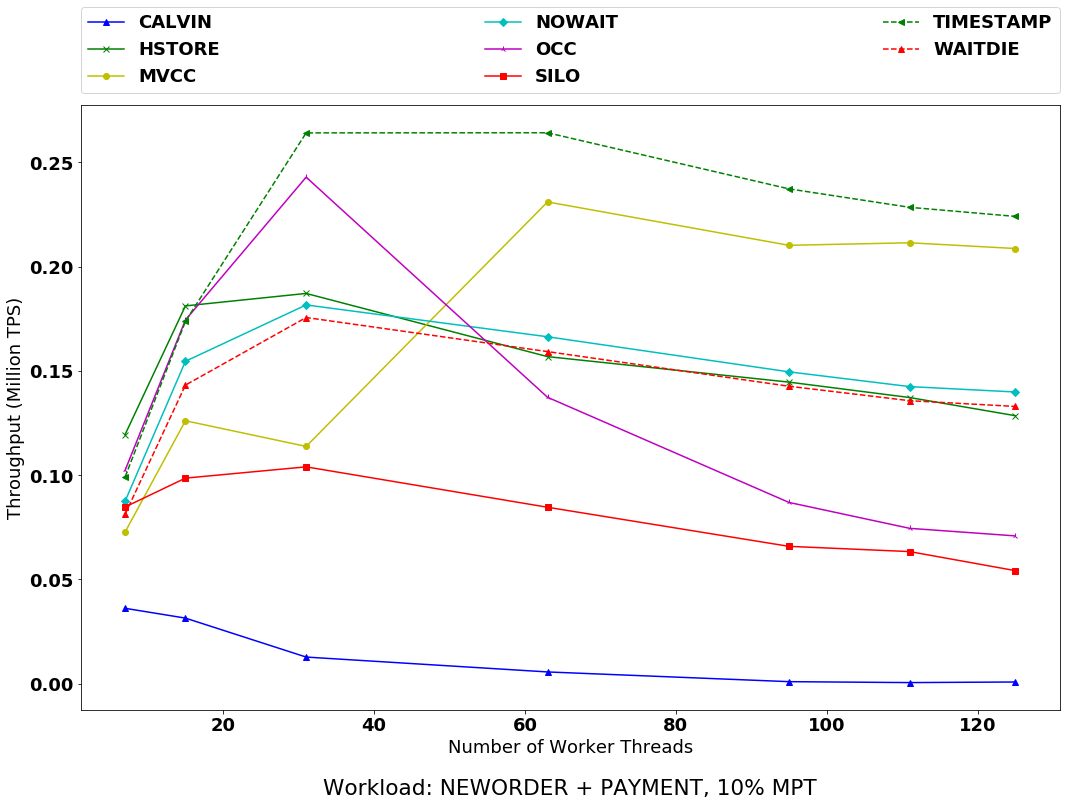

In [5]:
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean'}
agg_req = agg_req_normal
us = 1000000

tpcc_set1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set1_M128"
tpcc_set2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set2_M128"

ycsb_wl = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_results_october"
# df_ycsb_wl = pd.DataFrame(parse_directory(ycsb_wl))

tpcc_neworder_50_quecc_ts = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/50payment_qucc_ts_mpr15"
tpcc_neworder_50_others = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/50payment_others_mpr15"


# df_tpcc_neworder_50 = pd.concat([pd.DataFrame(parse_directory(tpcc_neworder_50_quecc_ts)),
#                                  pd.DataFrame(parse_directory(tpcc_neworder_50_others))]);
df_tpcc_test = pd.concat([pd.DataFrame(parse_directory(tpcc_set1)), pd.DataFrame(parse_directory(tpcc_set2))])

# tpcc_neworder_only = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_neworder_tpcc_mpt_o3"
# df_tpcc_neworder_only = pd.DataFrame(parse_directory(tpcc_neworder_only))

# tpcc_d15_mix50 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_d15_mix50"
# tpcc_d15_mix50_quecc = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_d15_mix50_quecc"
# df_tmp = pd.DataFrame(parse_directory(tpcc_d15_mix50))
# df_tmp = df_tmp[df_tmp.cc_alg != 'QUECC']
# df_tpcc_d15_mix50 = pd.concat([df_tmp,
#                                  pd.DataFrame(parse_directory(tpcc_d15_mix50_quecc))]);

# tpcc_neworder_only_quecc = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_neworder_tpcc_mpt_quecc"
# df_tpcc_neworder_only_quecc = pd.DataFrame(parse_directory(tpcc_neworder_only_quecc))

# del df_tpcc_neworder_only['commit_strategy']
# del df_tpcc_neworder_only_quecc['commit_strategy']
# df_tpcc_neworder_only['workload'] = "NEWORDER_ONLY"
# df_tpcc_neworder_only_quecc['workload'] = "NEWORDER_ONLY"


# del df_tpcc_neworder_50['commit_strategy']
# df_tpcc_neworder_50['workload'] = "NEWORDER + PAYMENT"

# del df_tpcc_d15_mix50['commit_strategy']
# df_tpcc_d15_mix50['workload'] = "NEWORDER + PAYMENT"

del df_tpcc_test['commit_strategy']
df_tpcc_test['workload'] = "NEWORDER + PAYMENT, 10% MPT"



# del df_ycsb_wl['commit_strategy']
# df_ycsb_wl['workload'] = "YCSB"


# df_tpcc_neworder_only = df_tpcc_neworder_only[df_tpcc_neworder_only.cc_alg != 'QUECC']

# grouped_tpcc_neworder_only = df_tpcc_neworder_only.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)
# grouped_tpcc_neworder_only_quecc = df_tpcc_neworder_only_quecc.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)
# grouped_tpcc_neworder_50 = df_tpcc_neworder_50.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)


# grouped_tpcc_d15_mix15 = df_tpcc_d15_mix50.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)
grouped_tpcc_test = df_tpcc_test.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)

                    
# grouped_tpcc_neworder_only = pd.concat([grouped_tpcc_neworder_only_2, grouped_tpcc_neworder_only_quecc])
# grouped_tpcc_neworder_only = grouped_tpcc_neworder_only


# tpcc_payment_only = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_payment_tpcc_spt"
# tpcc_payment_only = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_payment_tpcc_spt_test2"
# tpcc_payment_only = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_payment_tpcc_spt_quecc"
# df_tpcc_payment_only = pd.DataFrame(parse_directory(tpcc_payment_only))
# del df_tpcc_payment_only['commit_strategy']
# df_tpcc_payment_only['workload'] = "PAYMENT_ONLY"
# df_tpcc_payment_only = df_tpcc_payment_only[df_tpcc_payment_only.cc_alg != 'QUECC']

# grouped_tpcc_payment_only = df_tpcc_payment_only.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)
# grouped_tpcc_neworder_only = df_tpcc_neworder_only.groupby(['cc_alg','workload','worker_cnt','pa_cnt']).agg(agg_req)
# grouped_ycsb_wl = df_ycsb_wl.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)

pd.options.display.float_format = '{:,.2f}'.format
grouped_f = []
# grouped_f = grouped_tpcc_payment_only
# grouped_f = grouped_tpcc_neworder_only
# grouped_f = grouped_tpcc_neworder_50
# grouped_f = grouped_ycsb_wl
# grouped_f = grouped_tpcc_d15_mix15
grouped_f = grouped_tpcc_test
# print(grouped_f.loc['HSTORE','NEWORDER_ONLY'].index)
# dff = pd.concat([df_tpcc_payment_only,df_tpcc_neworder_only])


ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]
plt.figure(figsize=(16,10))

algs = list(grouped_f.index.levels[0])
ztheta = list(grouped_f.index.levels[1])
pc =0
print(algs)
print(ztheta)
doplot = True
for t in ztheta:
    doplot = False
    line_labels = []
    line_yvals = []
    line_xvals = []
    line_theta = []
    for a in algs:
#         ll = '{}-{}'.format(a,t)
        ll = a
        print(ll)
        print(t)
        line_labels.append(ll)
        yvals = list(grouped_f.loc[a,t]['tput'])
        yvals_s = list( map(lambda x : x/us, yvals))
        xvals = list(grouped_f.loc[a,t].index.get_level_values(0))
#         print(yvals)
#         print(xvals)
        line_yvals.append(yvals_s)
        line_xvals.append(xvals)
        line_theta.append(t)
    
    doplot = True

    if doplot:
        pc = pc + 1
        plti = 110 + pc
        print(plti)
    #     print(len(line_yvals))
        ax = plt.subplot(plti)
#         ax = plt.subplot() # single plot
        ax.set_title("Workload: {}".format(t), y=-0.15)
        for i in range(len(line_yvals)):
            ls_tmp = ls[i]

            ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
            ax.set_ylabel('Throughput (Million TPS)')
            # ax.set_xlabel('Zipfian Theta')
            ax.set_xlabel('Number of Worker Threads')
            
# algs = list(grouped_f.index.levels[0])
# pa_cnt = list(grouped_f.index.levels[2])  
# doplot = True
# line_labels = []
# line_yvals = []
# line_xvals = []
# line_theta = []
# for a in algs:
#         ll = a
#         print(ll)
#         line_labels.append(ll)
#         yvals = list(grouped_dfmpt.loc[a]['tput'])
#         yvals_s = list( map(lambda x : x/us, yvals))
#         xvals = list(grouped_f.loc[a].index.levels[1])
# #         print(yvals)
# #         print(xvals)
#         line_yvals.append(yvals_s)
#         line_xvals.append(xvals)
# # print(line_xvals)
# # print(line_yvals)
# # print(line_labels)
# if doplot:
#     pc = pc + 1
#     plti = 130 + pc
#     print(plti)
# #     print(len(line_yvals))
#     ax = plt.subplot(plti)
#     ax.set_title("Theta = {}".format(0.9), y=0.9)
#     for i in range(len(line_yvals)):
#         ls_tmp = ls[i]        
#         ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
#         ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
#         ax.set_ylabel('Throughput (Million TPS)')
#         # ax.set_xlabel('Zipfian Theta')
#         ax.set_xlabel('Number of Partitions')
        
plt.legend(bbox_to_anchor=(0.0, 1.02, 1.0, .102), 
           loc=8,
               ncol=3, mode="expand", borderaxespad=0.)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

# grouped_f

In [7]:
### d1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt0_zt6_zt9_tdg_commit"
d2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt95_zt99_tdg_commit"

d3 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_lads_only"
d4 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_occ_only"

df1 = pd.DataFrame(parse_directory(d1))
df1 = df1[df1.cc_alg != 'OCC']
df2 = pd.DataFrame(parse_directory(d2))
df2 = df2[df2.cc_alg != 'OCC']
df3 = pd.DataFrame(parse_directory(d3))
df4 = pd.DataFrame(parse_directory(d4))

dff = pd.concat([df1,df2,df3,df4])
# dff = dff[dff.cc_alg != 'OCC']
del dff['commit_strategy']
# dff.to_csv()

NameError: name 'd1' is not defined

In [8]:
dff

NameError: name 'dff' is not defined

In [9]:
d3 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_mpt"
dfmpt = pd.DataFrame(parse_directory(d3))

dfmpt

,cc_alg,commit_strategy,et_cnt,et_time,et_tput,pa_cnt,pa_strict,pt_cnt,pt_perc,pt_time,pt_tput,seq_no,total_runtime,total_time,total_tput,tput,trial_no,virt_mem_usage,worker_cnt,zipf_theta
0,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,214,60.000000,0.0,0.0,2.907765e+06,0,130447248,32,0.90
1,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,215,60.000000,0.0,0.0,2.924208e+06,1,132372368,32,0.90
2,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,True,16,50,0.0,0.0,212,60.000000,0.0,0.0,3.192336e+06,0,36616080,32,0.90
3,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,True,16,50,0.0,0.0,213,60.000000,0.0,0.0,3.186288e+06,1,36634512,32,0.90
4,HSTORE,AFTERBATCHCOMP,32,0.0,0.0,16,False,32,100,0.0,0.0,18,60.000001,0.0,0.0,1.257279e+05,0,35360796,32,0.90
5,HSTORE,AFTERBATCHCOMP,32,0.0,0.0,16,False,32,100,0.0,0.0,19,60.000001,0.0,0.0,1.251336e+05,1,36528156,32,0.90
6,MVCC,AFTERBATCHCOMP,32,0.0,0.0,16,False,32,100,0.0,0.0,158,60.000000,0.0,0.0,0.000000e+00,0,26351644,32,0.90
7,MVCC,AFTERBATCHCOMP,32,0.0,0.0,16,False,32,100,0.0,0.0,159,60.000000,0.0,0.0,0.000000e+00,1,26370076,32,0.90
8,NOWAIT,AFTERBATCHCOMP,32,0.0,0.0,16,False,32,100,0.0,0.0,74,60.000004,0.0,0.0,4.509323e+05,0,58993724,32,0.90
9,NOWAIT,AFTERBATCHCOMP,32,0.0,0.0,16,False,32,100,0.0,0.0,75,60.000000,0.0,0.0,4.517170e+05,1,59192380,32,0.90


In [10]:
d4 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_quecc_x132xlarge"
df_quecc = pd.DataFrame(parse_directory(d4))
df_quecc

,cc_alg,commit_strategy,et_cnt,et_time,et_tput,pa_cnt,pa_strict,pt_cnt,pt_perc,pt_time,pt_tput,seq_no,total_runtime,total_time,total_tput,tput,trial_no,virt_mem_usage,worker_cnt,zipf_theta
0,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,22,60.000000,0.0,0.0,4.478880e+06,0,51273672,32,0.00
1,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,26,60.000000,0.0,0.0,3.458112e+06,0,71016148,32,0.60
2,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,30,60.000000,0.0,0.0,3.448347e+06,0,164730008,32,0.90
3,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,34,60.000000,0.0,0.0,3.333120e+06,0,135591544,32,0.95
4,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,38,60.000000,0.0,0.0,3.374784e+06,0,99166656,32,0.99
5,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,23,60.000000,0.0,0.0,4.499712e+06,1,48674760,32,0.00
6,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,27,60.000000,0.0,0.0,3.513447e+06,1,71425748,32,0.60
7,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,31,60.000000,0.0,0.0,3.395616e+06,1,168102952,32,0.90
8,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,35,60.000000,0.0,0.0,3.395616e+06,1,136572960,32,0.95
9,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,39,60.000000,0.0,0.0,3.493917e+06,1,103339936,32,0.99


In [266]:
dtest = dfmpt[dfmpt.cc_alg == 'HSTORE']
dtest

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/pandas/core/ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [6]:
# grouped = df.groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','commit_strategy', 'pt_cnt', 'et_cnt']).tput.agg(['count', 'min', 'max', 'mean'])
pd.options.display.float_format = '{:,.2f}'.format
# agg_req_fixed = {'total_tput':'mean', 'et_tput':'mean', 'pt_tput':'mean', 'total_time':'mean', 'pt_time':'mean', 'et_time':'mean'}
agg_req_fixed = {'et_tput':'mean'}
agg_req = agg_req_fixed
# grouped = df.groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','commit_strategy', 'pt_cnt', 'et_cnt']).agg(agg_req)
grouped = df.groupby(['et_cnt']).agg(agg_req)
grouped

,et_tput
et_cnt,
4,0.00
8,0.00
12,0.00
16,0.00
18,0.00
24,0.00
32,0.00
36,0.00


In [292]:
grouped_f.loc[grouped_f.cc_alg == 'HSTORE']

AttributeError: 'DataFrame' object has no attribute 'cc_alg'

In [33]:
# df2 = df[df.zipf_theta == '0.99']
# grouped = df.groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','commit_strategy', 'pt_cnt', 'et_cnt']).tput.agg(['count', 'min', 'max', 'mean'])
pd.options.display.float_format = '{:,.2f}'.format
agg_req_normal = {'tput':'mean', 'total_runtime':'mean', 'virt_mem_usage':'mean'}
agg_req = agg_req_normal
# grouped_dfmpt = dfmpt.loc[(dfmpt['pa_strict'] == False) & (dfmpt['cc_alg'] != 'MVCC') & (dfmpt['cc_alg'] != 'OCC')].groupby(['cc_alg','pa_strict','pa_cnt','zipf_theta', 'worker_cnt']).agg(agg_req)
grouped_dfmpt = dfmpt.groupby(['cc_alg','pa_strict','pa_cnt','zipf_theta', 'worker_cnt']).agg(agg_req)
grouped_f = dff.loc[(dff['cc_alg'] != 'MVCC') & (dff['cc_alg'] != 'OCC')].groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','pt_cnt', 'et_cnt']).agg(agg_req)
grouped_quecc = df_quecc.loc[(df_quecc['worker_cnt'] != 124)].groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','pt_cnt', 'et_cnt']).agg(agg_req)
# dff6 = dff[dff.zipf_theta == '0.60']
# grouped = dff6.groupby(['cc_alg','zipf_theta', 'worker_cnt']).agg(agg_req)
# dff95 = dff[dff.zipf_theta == '0.95']
# grouped = dff95.groupby(['cc_alg','zipf_theta', 'worker_cnt']).agg(agg_req)
# dff99 = dff[dff.zipf_theta == '0.99']
# grouped = dff99.groupby(['cc_alg','zipf_theta', 'worker_cnt']).agg(agg_req)
# dff32 = dff[dff.worker_cnt == 32]
# grouped = dff32.groupby(['cc_alg', 'worker_cnt','zipf_theta']).agg(agg_req)
# grouped = dfmpt.groupby(['cc_alg', 'worker_cnt','pa_cnt','zipf_theta']).agg(agg_req)

# grouped = df.groupby(['et_cnt']).agg(agg_req)
# grouped_f
# dff60
# grouped_dfmpt
grouped_quecc

NameError: name 'dfmpt' is not defined

,pt_tput,virt_mem_usage
pt_cnt,,
8,0.00,48831396
10,0.00,51229024
12,0.00,48037940
14,0.00,47929252
16,0.00,38210364
18,0.00,47638864
20,0.00,30734268
24,0.00,33494376
28,0.00,34552688


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


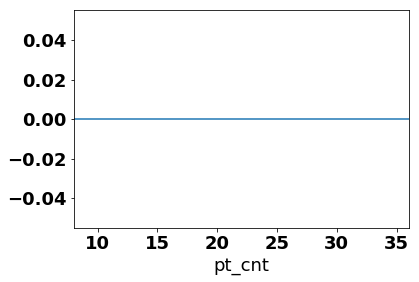

In [874]:
# grouped = df.groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','commit_strategy', 'pt_cnt', 'et_cnt']).tput.agg(['count', 'min', 'max', 'mean'])
pd.options.display.float_format = '{:,.2f}'.format
# agg_req_fixed = {'total_tput':'mean', 'et_tput':'mean', 'pt_tput':'mean', 'total_time':'mean', 'pt_time':'mean', 'et_time':'mean'}
# agg_req_fixed = {'et_tput':'mean','pt_tput':'mean','virt_mem_usage':'mean'}
agg_req_fixed = {'pt_tput':'mean','virt_mem_usage':'mean'}
agg_req = agg_req_fixed
# grouped = df.groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','commit_strategy', 'pt_cnt', 'et_cnt']).agg(agg_req)
# grouped = df.groupby(['et_cnt', 'pt_cnt']).agg(agg_req)
grouped = df.groupby(['pt_cnt']).agg(agg_req)
# grouped = df.groupby(['et_cnt']).agg(agg_req)
# grouped['pt_tput'].plot()
grouped['pt_tput'].plot()
grouped

In [288]:
# no_storage_access_grouped_50 = grouped
# no_storage_access_grouped_50
csvdata = grouped_dfmpt.to_csv()
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt0"
target = open('/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/result_fig_mpt.csv','w')
target.write(csvdata)
target.close()

In [356]:
## with_storage_access_grouped_50 = grouped
# with_storage_access_grouped_50
# x = list(grouped.loc['QUECC','0.95'].index)
# x = list(grouped.loc['QUECC','0.99'].index)
# x = list(grouped.loc['QUECC','0.60'].index)

x
# grouped.loc['QUECC','0.60'].index.levels[0]
grouped_f
grouped_dfmpt.index
grouped_quecc.index
grouped_quecc.loc['QUECC','0.00'].index.levels[0]

Int64Index([16, 32, 48, 64, 80, 96, 112], dtype='int64', name='worker_cnt')

[16, 32, 48, 64, 80, 96, 112]
['0.00', '0.60', '0.90', '0.95', '0.99']
[[2.3540159767617501, 4.4730209580495002, 5.4305334802829996, 7.2680080757369998, 7.4277144883822501, 7.7159233507027496, 7.9146285289265004], [1.9325064493089998, 4.0274114844689999, 5.5168994323837497, 6.6381656051952502, 4.7627810871237495, 5.5296482334880004, 5.6709081419550005], [1.9917344782917499, 3.8213699869464999, 4.0547534308627506, 4.0278997390124998, 3.9668033868160002, 3.4748752387192501, 2.7013244827730003], [1.9432349664872501, 3.7601759856805002, 3.5916754895845, 3.7698596126645003, 3.4943726914947502, 3.77764449201675, 3.2434677828915], [1.9523489943079999, 3.7635937333942504, 3.52440546547875, 3.6272092181605, 3.5821274902610001, 3.7287109946729999, 2.8742579925339999]]
[[16, 32, 48, 64, 80, 96, 112], [16, 32, 48, 64, 80, 96, 112], [16, 32, 48, 64, 80, 96, 112], [16, 32, 48, 64, 80, 96, 112], [16, 32, 48, 64, 80, 96, 112]]


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


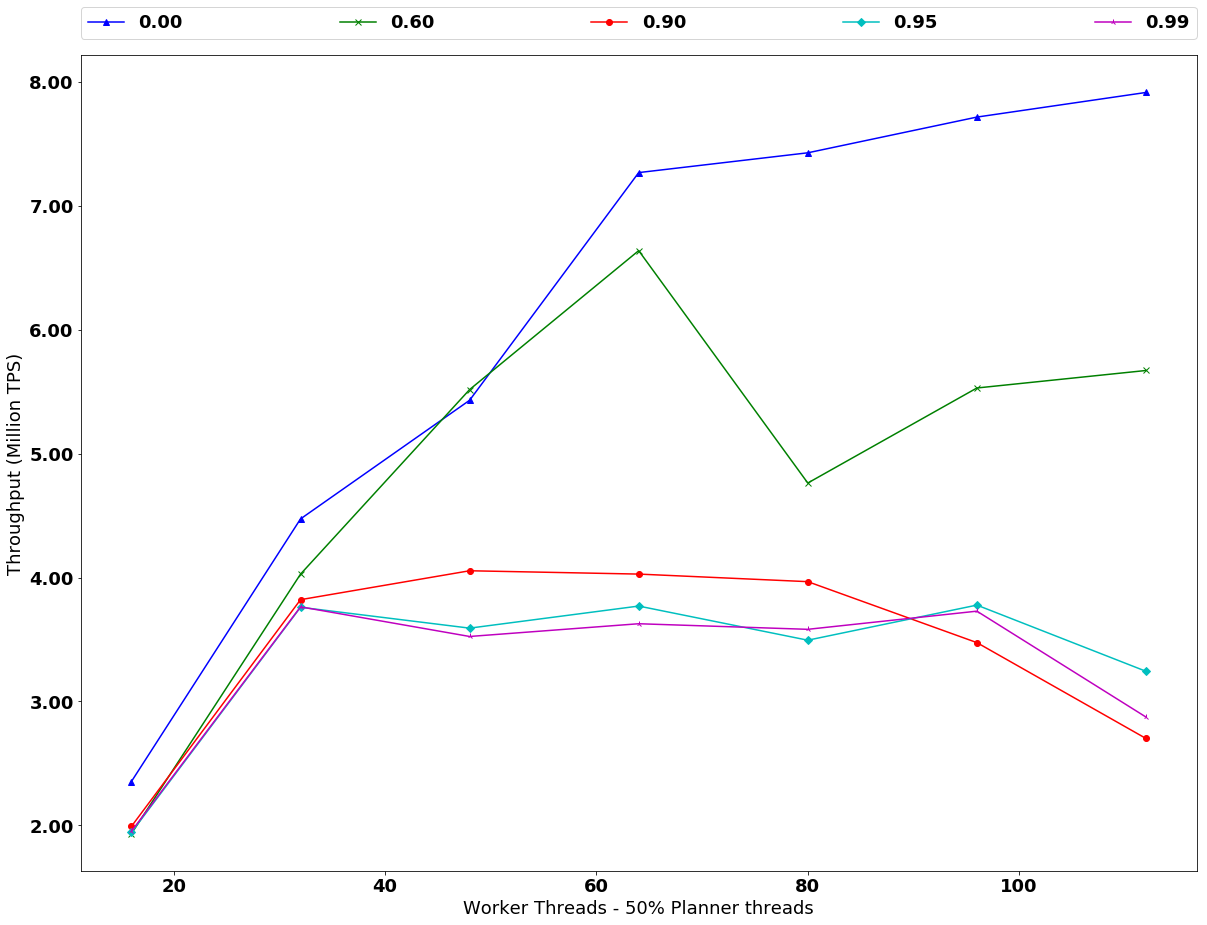

In [358]:
import matplotlib.ticker as ticker  
us = 1000000
ls = ['b^-', 'gx-', 'ro-', 'cD-', 'm2-', 'ys-', 'g<--', 'r^-', 'g^-', 'c^-', 'm^-', 'y^-' ]
x =list(grouped_quecc.index.levels[2])
keys = list(grouped_quecc.index.levels[1])
print(x)
print(keys)
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
for k in keys:
    ll = str(k)
    line_labels.append(ll)
    yvals = list(grouped_quecc.loc['QUECC',k]['tput'])
    yvals_s = list( map(lambda x : x/us, yvals))
    xvals = list(grouped_quecc.loc['QUECC',k].index.levels[0])
#     print(yvals)
#     print(xvals)
    line_yvals.append(yvals_s)
    line_xvals.append(xvals)
print(line_yvals)
print(line_xvals)
plt.figure(figsize=(20,15))
ax= plt.subplot(111)
for i in range(len(line_yvals)):
        ls_tmp = ls[i]
        ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
        ax.set_ylabel('Throughput (Million TPS)')
        ax.set_xlabel('Worker Threads - 50% Planner threads')
plt.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), 
           loc=3,ncol=7, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)

In [223]:
import matplotlib.ticker as ticker  
us = 1000000
ls = ['bs-', 'rs-', 'gs-', 'cs-', 'ms-', 'ys-', 'b^-', 'r^-', 'g^-', 'c^-', 'm^-', 'y^-' ]
x =list(map(lambda x: float(x),list(grouped.loc['QUECC',32].index)))
algs = list(grouped.index.levels[0])
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
for a in algs:
    ll = a
    line_labels.append(ll)
    yvals = list(grouped.loc[a,t]['tput'])
    yvals_s = list( map(lambda x : x/us, yvals))
    xvals = list(grouped.loc[a,t].index)
    print(yvals)
    print(xvals)
    line_yvals.append(yvals_s)
    line_xvals.append(xvals)
# print(line_yvals)
# print(line_xvals)
plt.figure(figsize=(20,15))
ax= plt.subplot(111)
for i in range(len(line_yvals)):
        ls_tmp = ls[i]
        ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
        ax.set_ylabel('Throughput (Million TPS)')
        ax.set_xlabel('Theta')
plt.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), 
           loc=3,ncol=7, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)

TypeError: float() argument must be a string or a number, not 'tuple'

In [144]:
import matplotlib.ticker as ticker  
us = 1000000
ls = ['b^-', 'gx-', 'ro-', 'cD-', 'm2-', 'ys-', 'g<--', 'r^-', 'g^-', 'c^-', 'm^-', 'y^-' ]
plt.figure(figsize=(30,6))

algs = list(grouped_f.index.levels[0])
ztheta = list(grouped_f.index.levels[1])
pc =0
print(algs)
print(ztheta)
doplot = True
for t in ztheta:
    doplot = False
    line_labels = []
    line_yvals = []
    line_xvals = []
    line_theta = []
    for a in algs:
#         ll = '{}-{}'.format(a,t)
        ll = a
#         print(ll)
        line_labels.append(ll)
        yvals = list(grouped_f.loc[a,t]['tput'])
        yvals_s = list( map(lambda x : x/us, yvals))
        xvals = list(grouped_f.loc[a,t].index.levels[0])
#         print(yvals)
#         print(xvals)
        line_yvals.append(yvals_s)
        line_xvals.append(xvals)
        line_theta.append(t)

    if (t == '0.00' or t == '0.99'):
        doplot = True

    if doplot:
        pc = pc + 1
        plti = 130 + pc
        print(plti)
    #     print(len(line_yvals))
        ax = plt.subplot(plti)
        ax.set_title("Theta = {}".format(t), y=0.9)
        for i in range(len(line_yvals)):
            ls_tmp = ls[i]

            ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
            ax.set_ylabel('Throughput (Million TPS)')
            # ax.set_xlabel('Zipfian Theta')
            ax.set_xlabel('Number of Worker Threads')
            
algs = list(grouped_dfmpt.index.levels[0])
pa_cnt = list(grouped_dfmpt.index.levels[2])  
doplot = True
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
for a in algs:
        ll = a
        print(ll)
        line_labels.append(ll)
        yvals = list(grouped_dfmpt.loc[a]['tput'])
        yvals_s = list( map(lambda x : x/us, yvals))
        xvals = list(grouped_dfmpt.loc[a].index.levels[1])
#         print(yvals)
#         print(xvals)
        line_yvals.append(yvals_s)
        line_xvals.append(xvals)
# print(line_xvals)
# print(line_yvals)
# print(line_labels)
if doplot:
    pc = pc + 1
    plti = 130 + pc
    print(plti)
#     print(len(line_yvals))
    ax = plt.subplot(plti)
    ax.set_title("Theta = {}".format(0.9), y=0.9)
    for i in range(len(line_yvals)):
        ls_tmp = ls[i]        
        ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
        ax.set_ylabel('Throughput (Million TPS)')
        # ax.set_xlabel('Zipfian Theta')
        ax.set_xlabel('Number of Partitions')
        
plt.legend(bbox_to_anchor=(-2.4, 1.02, 3.0, .102), 
           loc=8,ncol=8, mode="expand", borderaxespad=0.)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)


['CALVIN', 'HSTORE', 'MVCC', 'NOWAIT', 'OCC', 'SILO', 'TIMESTAMP', 'WAITDIE']
['GS32', 'M128', 'M64']


NameError: name 'grouped_dfmpt' is not defined

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


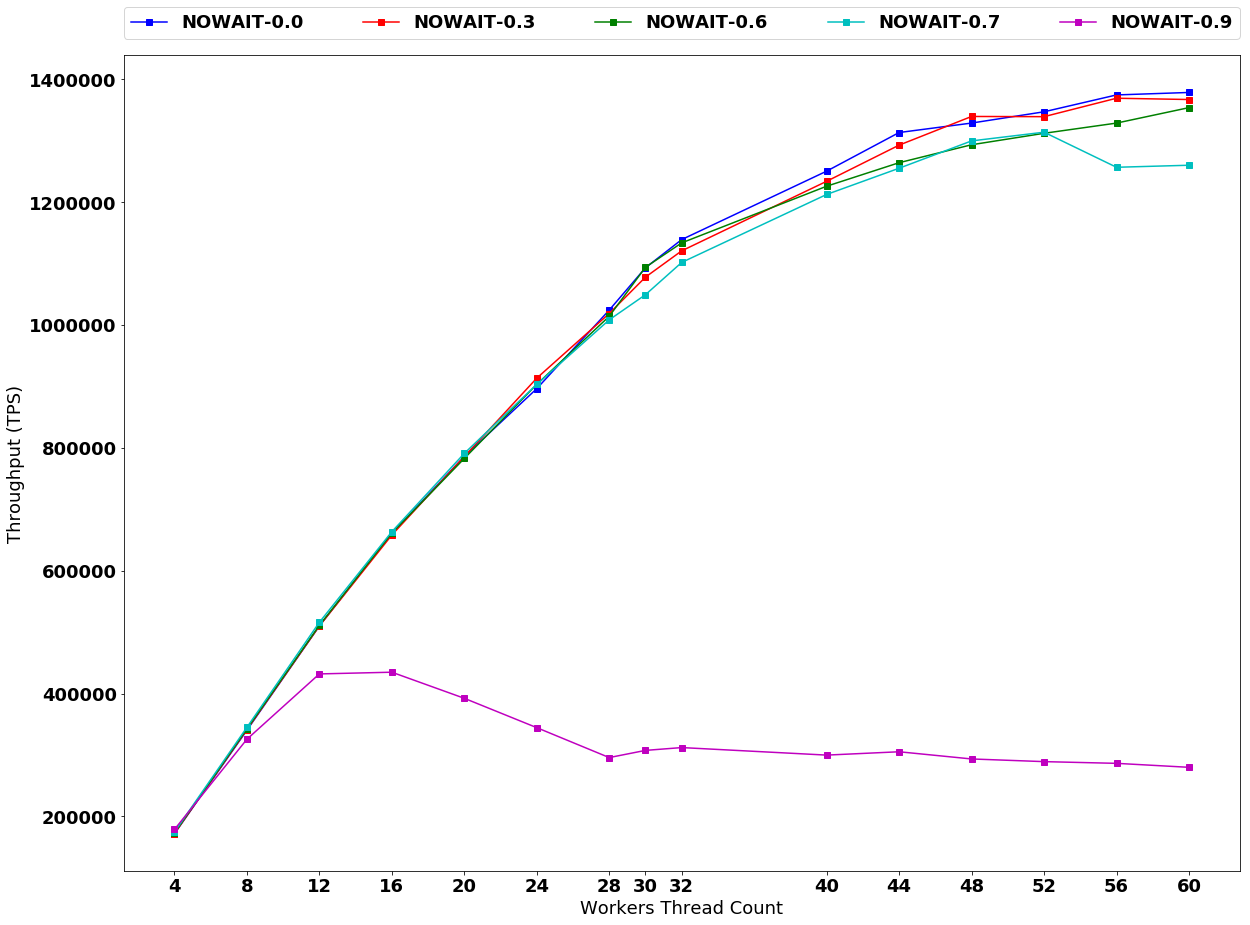

In [80]:
# grouped.loc['NOWAIT']['mean'].plot()
# theta_pt3.plot()
ls = ['bs-', 'rs-', 'gs-', 'cs-', 'ms-', 'ys-', 'bs*', 'y^--' ]
x = list(theta_pt0.index)

us = 1000000

plt.figure(figsize=(20,15))

ax = plt.subplot(111)
# pcolors = ['r','b','g','gray']
# ax.set_xscale('linear')

# for i,s in enumerate(ss):
ax.plot(x,theta_pt0, ls[0], label='NOWAIT-0.0')
ax.plot(x,theta_pt3, ls[1], label='NOWAIT-0.3')
ax.plot(x,theta_pt6, ls[2], label='NOWAIT-0.6')
ax.plot(x,theta_pt7, ls[3], label='NOWAIT-0.7')
ax.plot(x,theta_pt9, ls[4], label='NOWAIT-0.9')

ax.xaxis.set_ticks(x)
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.1f M'))

ax.set_ylabel('Throughput (TPS)')
ax.set_xlabel('Workers Thread Count')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=6, mode="expand", borderaxespad=0.)

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


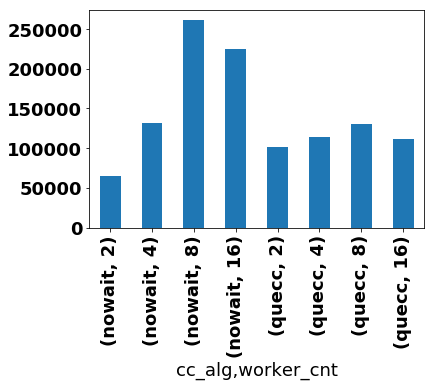

In [9]:
grouped['mean'].plot('bar')

In [10]:
grouped.loc['NOWAIT'][1:]
# grouped.loc['QUECC'][:3]

KeyError: 'the label [NOWAIT] is not in the [index]'

In [65]:
data_csv = '/Users/qadahtm/Dev/halstead/results/aws_sum_data_pt6.csv'
print(os.getcwd())
df = pd.DataFrame.from_csv(data_csv)
grouped = df.groupby(['cc_alg','wthd_cnt']).tput.agg(['count', 'min', 'max', 'mean'])
grouped

/Users/qadahtm/Dev/halstead/deneva_project/pynb


count            min            max           mean
cc_alg    wthd_cnt                                                    
MAAT      2             1   63184.349913   63184.349913   63184.349913
          4             1  123855.666291  123855.666291  123855.666291
          8             1  243777.232635  243777.232635  243777.232635
          16            1  377311.381730  377311.381730  377311.381730
MVCC      2             1   58250.283137   58250.283137   58250.283137
          4             1  129798.216346  129798.216346  129798.216346
          8             1  260822.665445  260822.665445  260822.665445
          16            1  452140.464466  452140.464466  452140.464466
NOWAIT    2             1   83476.983176   83476.983176   83476.983176
          4             1  170251.066099  170251.066099  170251.066099
          8             1  332714.549312  332714.549312  332714.549312
          16            1  603112.180499  603112.180499  603112.180499
QUECC     1             1  164638.414353  164638.414353  164638.414353
          2             1  210285.199849  210285.199849  210285.199849
          4             1  284556.250346  284556.250346  284556.250346
          8             1  328375.932414  328375.932414  328375.932414
TIMESTAMP 2             1   87417.083228   87417.083228   87417.083228
          4             1  173877.966901  173877.966901  173877.966901
          8             1  343452.432732  343452.432732  343452.432732
          16            1  605159.430661  605159.430661  605159.430661
WAITDIE   2             1   76960.483042   76960.483042   76960.483042
          4             1  157928.683039  157928.683039  157928.683039
          8             1  313858.682313  313858.682313  313858.682313
          16            1  562928.148480  562928.148480  562928.148480

/Users/qadahtm/Dev/halstead/deneva_project/deneva/pynb
0
MAAT
1
MVCC
2
NOWAIT
3
QUECC
4
TIMESTAMP
5
WAITDIE


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


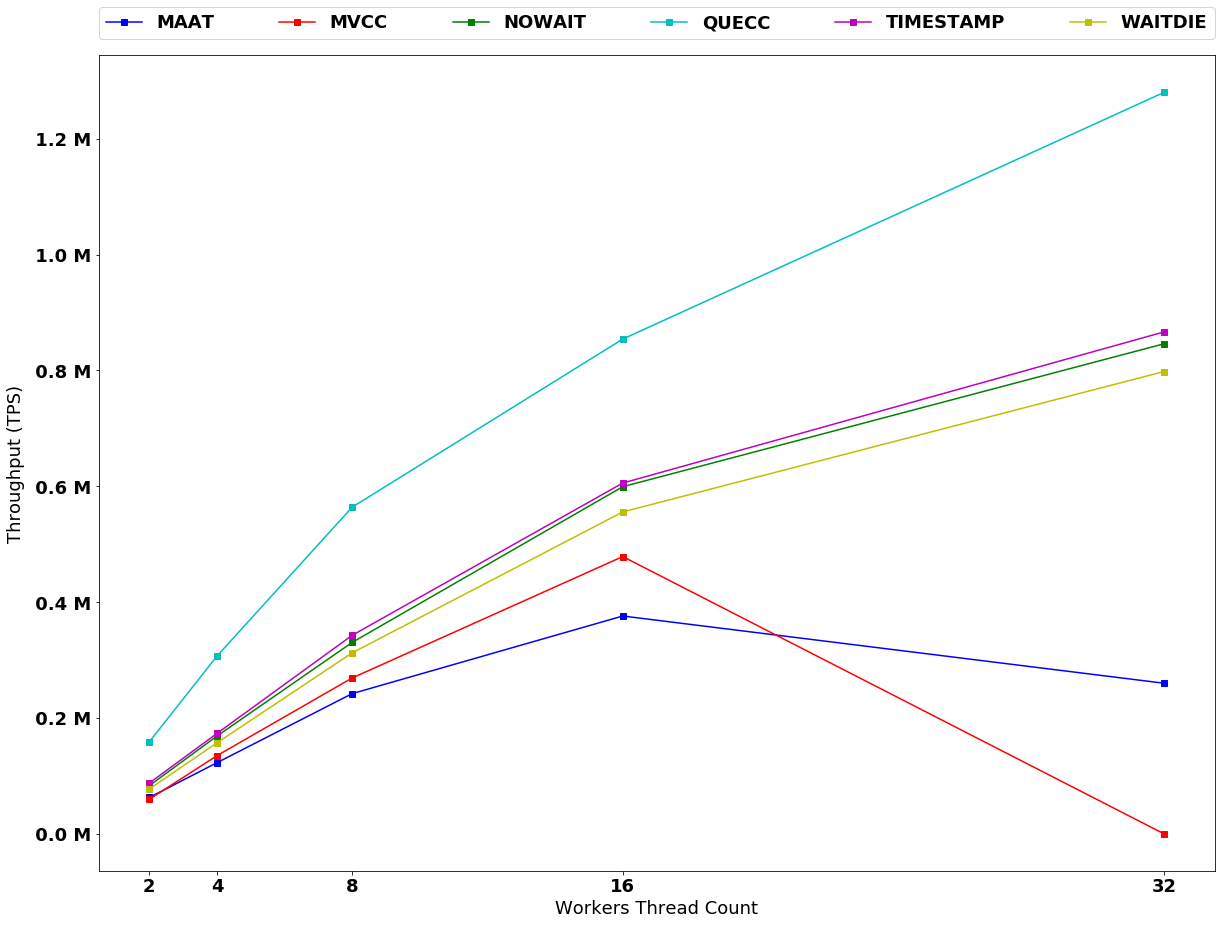

In [864]:
import matplotlib.ticker as ticker  

data_csv = '/Users/qadahtm/Dev/halstead/results/aws_sum_data_uni.csv'
print(os.getcwd())
df = pd.DataFrame.from_csv(data_csv)
grouped = df.groupby(['cc_alg','wthd_cnt']).tput.agg(['count', 'min', 'max', 'mean'])
grouped
# grouped.loc['NOWAIT']  
ss = list(grouped.index[:].levels[0])
y = [0.0]*(len(ss))
ys = [0.0]*(len(ss))
x = list(grouped.loc['NOWAIT'].index)
us = 1000000
for i,s in enumerate(ss):
    print(i)
    print(s)
    y[i] = list(grouped.loc[s]['mean'])
    ys[i] = list( map(lambda x : x/us, y[i]))
# y[0] = list(grouped.loc['NOWAIT']['mean'])
# y[1] = list(grouped.loc['QUECC']['mean'])
# y[2] = list(grouped.loc['DUMMYCC'][1:]['mean'])

# ys[0] = list( map(lambda x : x/us, y[0]))
# ys[1] = list( map(lambda x : x/us, y[1]))
# ys[2] = list( map(lambda x : x/us, y[2]))

ls = ['bs-', 'rs-', 'gs-', 'cs-', 'ms-', 'ys-', 'bs*', 'y^--' ]
plt.figure(figsize=(20,15))
# plt.figure()
ax = plt.subplot(111)
pcolors = ['r','b','g','gray']
ax.set_xscale('linear')
for i,s in enumerate(ss):
    ax.plot(x, ys[i], ls[i], label=s)

# ax.plot(x, y1s, 'bs-', label='NO_WAIT')
# ax.plot(x, y2s, 'r^-', label='QueCC')
# ax.plot(x, y3s, 'k^-', label='DummyCC')
ax.xaxis.set_ticks(x)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.1f M'))

ax.set_ylabel('Throughput (TPS)')
ax.set_xlabel('Workers Thread Count')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=6, mode="expand", borderaxespad=0.)

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


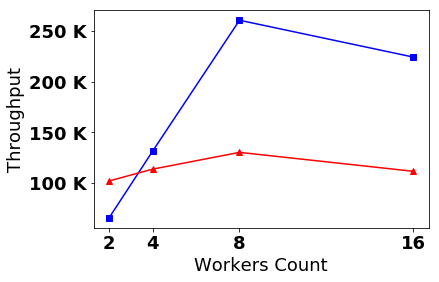

In [204]:
import matplotlib.ticker as ticker    
x = list(grouped.loc['nowait'].index)
y1 = list(grouped.loc['nowait']['mean'])
y2 = list(grouped.loc['quecc']['mean'])

y1s = list( map(lambda x : x/1000, y1))
y2s = list( map(lambda x : x/1000, y2))

# plt.figure(figsize=(20,10))
plt.figure()
ax = plt.subplot(111)
pcolors = ['r','b','g','gray']
ax.set_xscale('linear')
ax.plot(x, y1s, 'bs-')
ax.plot(x, y2s, 'r^-')
ax.xaxis.set_ticks(x)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d K'))
# ax.set_xticks(x)
# ax.set_xticklabels(plt_buckets_keys, rotation=0)

ax.set_ylabel('Throughput')
ax.set_xlabel('Workers Count')
# plt.autoscale(tight=True)

In [10]:
directory = "/Users/qadahtm/Dev/halstead/results/quecc2"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_ptet"

# fname = 'quecc_8p_8w_100mpr_16Mrec_s_t1.txt'
# fname = 'quecc_12p_4w_100mpr_16Mrec_s_t1.txt'
# fname = 'quecc_12p_4w_500Ktif_16Mrec_s_t1.txt'

fname = 'quecc_8p_8w_1Mtif_16Mrec_s_t1.txt'
fname = 'AFTERBATCHCOMP_pt8_et8_50_QUECC_s_t1_1_40.txt'

datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_neworder_tpcc_mpt_o3/pa8_AFTERBATCHCOMP_pt8_et8_50_pptstrict_QUECC_s_t0_118_32.txt'
# time_data = view_planner_from_file(directory+"/"+fname)
time_data = view_planner_from_file(datafile)
df = pd.DataFrame(time_data)
# df['idle_time']
df

,alloc_exec_queue_cnt,batch_cnt,batch_delivery_time,batch_proc_time,idle_time,mem_alloc_time,merge_time,queue_deq_cnt,queue_deq_free_mem_time,queue_deq_pop_time,queue_dequeue_time,reuse_exec_queue_cnt,size_batch_cnt,split_time,tdep_time,time_batch_cnt,total_time,txn_cnt,txn_proc_time
0,0.0,15.0,0.0,10.408417,51.931547,0.000985,0.000047,1171800.0,0.0,0.341336,0.377062,0.0,15.0,0.636704,0.000013,0.0,59.062634,0.0,9.862891
1,0.0,15.0,0.0,10.495555,51.837061,0.000583,0.000046,1171800.0,0.0,0.342826,0.378923,0.0,15.0,0.638857,0.000380,0.0,59.090548,0.0,9.939674
2,0.0,15.0,0.0,10.724462,51.608119,0.000579,0.000045,1171800.0,0.0,0.346194,0.382641,0.0,15.0,0.632225,0.000011,0.0,59.109022,0.0,10.172209
3,0.0,15.0,0.0,11.081943,51.196569,0.000473,0.000045,1171800.0,0.0,0.344522,0.380880,0.0,15.0,0.732548,0.000012,0.0,59.133347,0.0,10.535458
4,0.0,15.0,0.0,11.472260,50.806993,0.000218,0.000049,1171800.0,0.0,0.352104,0.389242,0.0,15.0,0.633361,0.000012,0.0,59.160162,0.0,10.916988
5,0.0,15.0,0.0,11.475286,50.782139,0.001170,0.000043,1171800.0,0.0,0.346644,0.384119,0.0,15.0,0.633411,0.000011,0.0,59.189125,0.0,10.919175
6,0.0,15.0,0.0,11.812666,50.415502,0.000188,0.000047,1171800.0,0.0,0.346837,0.384051,0.0,15.0,0.643155,0.000010,0.0,59.193202,0.0,11.249273
7,0.0,15.0,0.0,12.345373,49.809357,0.000325,0.000048,1171800.0,0.0,0.346020,0.383783,0.0,15.0,0.639028,0.000012,0.0,59.178338,0.0,11.791287


SyntaxError: invalid syntax (<ipython-input-11-eca72ba33d5a>, line 54)

In [12]:
plot_planner_times(df)
df

NameError: name 'plot_planner_times' is not defined

In [273]:
def view_exec_from_file(_fname):
    res = {}
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('(\[summary\]) (.+)', cline)
            if m:
                sline = m.group(2).split(',')
                for i, a in enumerate(sline):
#                     print(i,a)
#                     if i == 1:
#                         asline = a.split('=')
#                         res[asline[0]] = asline[1]
#                     mq = re.search('quecc\_exec(\d)\_(\w+)=(\d+\.?\d*)', a)
                    mq = re.search('quecc\_(exec|plan|wt)(\d+)\_(\w+)=(\d+\.?\d*)', a)
                    if mq:
#                         res['index'].append(int(i))
                        key = "{}_{}".format(mq.group(1),mq.group(3))
                        row = [mq.group(2), key, mq.group(4)]

                        if key in res.keys():
                            res[key].append(float(mq.group(4)))
                        else:
                            res[key] =[float(mq.group(4))]
#                         print(row)
#                         print(a)
#                 print(sline[0])
#                 print(sline[1])
#                 print(sline[2])
#     print(res)
    return res;
# time_data = view_exec_from_file(directory+"/"+fname)
print(datafile)
time_data = view_exec_from_file(datafile)
df = pd.DataFrame(time_data)
df['exec_batch_proc_time']

/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_mem_copy.txt


0   43.95
1   43.95
2   43.95
3   43.95
4   43.95
5   43.95
6   43.95
7   43.95
8   43.95
9   43.95
Name: exec_batch_proc_time, dtype: float64

In [15]:
def plot_exec_times_single_stage(df):
    f, ax1 = plt.subplots(1, figsize=(15,5))

    # Set the bar width
    bar_width = 0.75

    colors = ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd', '#CCCCCC']


    # positions of the left bar-boundaries
    bar_l = [i-(0.75) for i in range(len(df['exec_idle_time']))]

    # positions of the x-axis ticks (center of the bars as bar labels)
    # tick_pos = [(i-1)+(bar_width/2) for i in bar_l]

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            df['exec_idle_time']+df['plan_idle_time'],
            width=bar_width,
            label='Idle time',
            color=colors[0])

    # show whole batch partition processing
#     ax1.bar(bar_l,
#             df['batch_part_proc_time'],
#             width=bar_width,
#             bottom=df['idle_time'],
#             label='Batch part. proc. time',
#             color=colors[1])

    ax1.bar(bar_l,
            df['plan_txn_proc_time'],
            width=bar_width,
            bottom=df['exec_idle_time']+df['plan_idle_time'],
            label='Plan. txn. proc. time',
            color=colors[1], hatch='//')

    # txn_proc_time
    ax1.bar(bar_l,
            df['exec_txn_proc_time'],
            width=bar_width,
            bottom=(df['exec_idle_time']+df['plan_idle_time']
                    +df['plan_txn_proc_time']),
            label='Exec. txn. proc. time',
            color=colors[2], hatch='\\')
    
    # txn_ctx_update_time
    ax1.bar(bar_l,
            df['exec_txn_ctx_update_time'],
            width=bar_width,
            bottom=(df['exec_idle_time']
                    +df['plan_idle_time']
                    +df['exec_txn_proc_time']
                    +df['plan_txn_proc_time']
                    +df['exec_txn_index_lookup_time']),
            label='Txn context updates',
            color=colors[3], hatch='|')
    
    # txn_commit_time
    ax1.bar(bar_l,
            df['exec_txn_commit_time'],
            width=bar_width,
            bottom=(df['exec_txn_ctx_update_time']
                    +df['exec_idle_time']
                    +df['plan_idle_time']
                    +df['exec_txn_proc_time']
                    +df['plan_txn_proc_time']
                    +df['exec_txn_index_lookup_time']),
            label='Commit time',
            color=colors[4], hatch='=')
    
    # wait_times
    ax1.bar(bar_l,
            df['exec_txn_wait_time'],
            width=bar_width,
            bottom=(df['exec_txn_commit_time']
                    +df['exec_txn_ctx_update_time']
                    +df['exec_idle_time']
                    +df['plan_idle_time']
                    +df['exec_txn_proc_time']
                    +df['plan_txn_proc_time']
                    +df['exec_txn_index_lookup_time']),
            label='Wait time',
            color=colors[5], hatch='=')

    all_df = (df['exec_txn_wait_time']+df['exec_txn_commit_time']+df['exec_txn_ctx_update_time']+df['exec_idle_time']+df['plan_idle_time']+df['exec_txn_proc_time']
                +df['plan_txn_proc_time']
                +df['exec_txn_index_lookup_time']);
                    
    ax1.bar(bar_l,
            (60-all_df),
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=(all_df),
            label='Unmeasured other times',
            color=colors[6], hatch='++')

    # set the x ticks with names
    plt.xticks(bar_l,['ET_'+str(i) for i in range(len(df['exec_idle_time']))], rotation=45)

    # Set the label and legends
    ax1.set_ylabel("Run Time")
    ax1.set_xlabel("Execution threads")
    # plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.)

In [17]:
def plot_exec_times_single_stage(df):
    f, ax1 = plt.subplots(1, figsize=(15,5))

    # Set the bar width
    bar_width = 0.75

    colors = ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd', '#CCCCCC']


    # positions of the left bar-boundaries
    bar_l = [i-(0.75) for i in range(len(df['exec_idle_time']))]

    # positions of the x-axis ticks (center of the bars as bar labels)
    # tick_pos = [(i-1)+(bar_width/2) for i in bar_l]

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            df['exec_idle_time']+df['plan_idle_time'],
            width=bar_width,
            label='Idle time',
            color=colors[0], hatch='=')

    # show whole batch partition processing
#     ax1.bar(bar_l,
#             df['batch_part_proc_time'],
#             width=bar_width,
#             bottom=df['idle_time'],
#             label='Batch part. proc. time',
#             color=colors[1])

    ax1.bar(bar_l,
            df['plan_txn_proc_time'],
            width=bar_width,
            bottom=df['exec_idle_time']+df['plan_idle_time'],
            label='Plan. txn. proc. time',
            color=colors[1], hatch='//')

    # txn_proc_time
    ax1.bar(bar_l,
            df['exec_txn_proc_time'],
            width=bar_width,
            bottom=(df['exec_idle_time']+df['plan_idle_time']
                    +df['plan_txn_proc_time']),
            label='Exec. txn. proc. time',
            color=colors[2], hatch='\\')
    
    # txn_ctx_update_time
    ax1.bar(bar_l,
            df['exec_txn_ctx_update_time'],
            width=bar_width,
            bottom=(df['exec_idle_time']
                    +df['plan_idle_time']
                    +df['exec_txn_proc_time']
                    +df['plan_txn_proc_time']
                    +df['exec_txn_index_lookup_time']),
            label='Txn context updates',
            color=colors[3], hatch='|')
    
    # txn_commit_time
    ax1.bar(bar_l,
            df['exec_txn_commit_time'],
            width=bar_width,
            bottom=(df['exec_txn_ctx_update_time']
                    +df['exec_idle_time']
                    +df['plan_idle_time']
                    +df['exec_txn_proc_time']
                    +df['plan_txn_proc_time']
                    +df['exec_txn_index_lookup_time']),
            label='Commit time',
            color=colors[4], hatch='=')
    
    # wait_times
    ax1.bar(bar_l,
            df['exec_txn_wait_time'],
            width=bar_width,
            bottom=(df['exec_txn_commit_time']
                    +df['exec_txn_ctx_update_time']
                    +df['exec_idle_time']
                    +df['plan_idle_time']
                    +df['exec_txn_proc_time']
                    +df['plan_txn_proc_time']
                    +df['exec_txn_index_lookup_time']),
            label='Wait time',
            color=colors[5], hatch='=')

    all_df = (df['exec_txn_wait_time']+df['exec_txn_commit_time']+df['exec_txn_ctx_update_time']+df['exec_idle_time']+df['plan_idle_time']+df['exec_txn_proc_time']
                +df['plan_txn_proc_time']
                +df['exec_txn_index_lookup_time']);

                    
    ax1.bar(bar_l,
            (60-all_df),
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=(all_df),
            label='Unmeasured other times',
            color=colors[6], hatch='++')

    # set the x ticks with names
    plt.xticks(bar_l,['ET_'+str(i) for i in range(len(df['exec_idle_time']))], rotation=45)

    # Set the label and legends
    ax1.set_ylabel("Run Time")
    ax1.set_xlabel("Execution threads")
    # plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.)

In [18]:
# directory = '/Users/qadahtm/Dev/halstead/results/quecc_aws'
# df = pd.DataFrame(view_planner_from_file(directory+"/QUECC_s_t0_7.txt"))
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/testpt0.txt'
# datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/testpt8.txt'
# datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt16_mpr10_1_GS32/pa1_40320_pt32_et32_100_pptstrict_QUECC_s_t0_3_32.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factorpt5_2.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factorpt5_CNT_ACQ_REL.txt'

datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factor1x_SYNC_BLOCK.txt'

datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factor1x_SYNC_BLOCK_notdg.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factor1x_SYNC_BLOCK_notdg_nosplit.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factor1x_SYNC_BLOCK_notdg_nosplit_D15.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factor1x_SYNC_BLOCK_notdg_D15.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factor1x_SYNC_BLOCK_fixedmaster_D15.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factor1x_SYNC_BLOCK_rrmaster_D15.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factor1x_SYNC_BLOCK_rrmaster_parallelpgcleanup_D15.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_tmp.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_tmp_thetapt8.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_pt50_theta0_eqrr.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_pt50_theta0_eqbal.txt'
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factor1x_eqbal.txt'

# datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt0_factorpt5_DS15.txt'
# datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt0_factorpt5_tdgarray_DS15.txt'
# datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factorpt5_tdgarray_DS15.txt'
# datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factorpt5_DS15.txt'

# datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factor1x_SYNC_BLOCK_notdg_noasserts_D15.txt'
# datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt8_factor1x_SYNC_BLOCK_D15.txt'

# datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_thetapt0_factor1x_SYNC_BLOCK_notdg_nosplit_GS32.txt'

df = pd.DataFrame(view_planner_from_file(datafile))
plot_planner_times(df)

# df['wt_hl_sync_exec']
df



NameError: name 'plot_planner_times' is not defined

0    0.00
1    0.00
2    0.00
3    0.00
4    0.00
5    0.00
6    0.00
7    0.00
8    0.00
9    0.00
10   0.00
11   0.00
12   0.00
13   0.00
14   0.00
15   0.00
16   0.00
17   0.00
18   0.00
19   0.00
Name: exec_batch_proc_time, dtype: float64

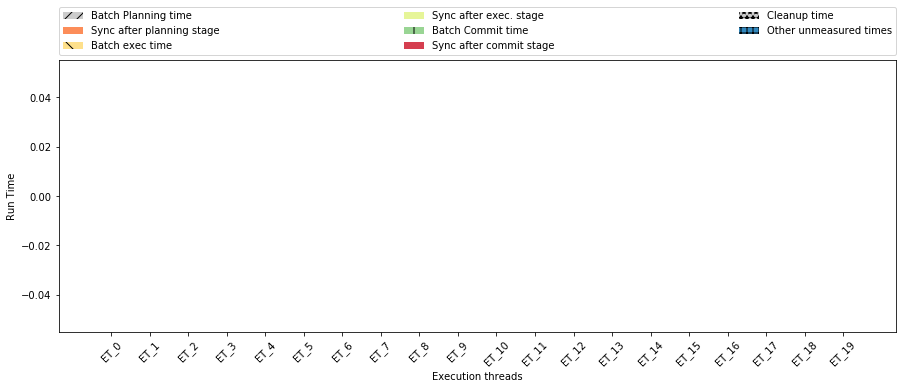

In [314]:
directory = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results'
# df = pd.DataFrame(view_exec_from_file(directory+"/QUECC_s_t0_7.txt"))
# datafile = directory+'/test_mem_copy.txt'
datafile = directory+'/test_quecc.txt'
df = pd.DataFrame(view_exec_from_file(datafile))
# plot_exec_times(df)
# plot_exec_times_single_stage(df)
plot_exec_times_hl_unpip(df)
# plot_exec_times_hl_pip(df)
df

df['exec_batch_proc_time']

SyntaxError: invalid syntax (<ipython-input-21-048286e78184>, line 1)

In [207]:
sample_res = {'w_thds':[2,4,8,16],
              'dummy_cc':[],
              'no_wait':[],
              'quecc':[]}

148.2495267939766

In [272]:
'NO_WAIT'.replace('_','')

'NOWAIT'

In [275]:
# Import smtplib for the actual sending function
import smtplib

# Import the email modules we'll need
# from email.message import EmailMessage

# def send_email(msg):
#     s = smtplib.SMTP('localhost')
#     s.sendmail('tqadah@purdue.edu', ['tqadah@purdue.edu'], msg)
#     s.quit()

# send_email('test content')
# msg = EmailMessage()
# msg.set_content("test content")

# me == the sender's email address
# you == the recipient's email address
# msg['Subject'] = 'subjet test'
# msg['From'] = 'tqadah@purdue.edu'
# msg['To'] = ['tqadah@purdue.edu', 'qadah.thamir@gmail.com']

# # Send the message via our own SMTP server.
# s = smtplib.SMTP('localhost')
# s.send_message(msg)
# s.quit()

ConnectionRefusedError: [Errno 61] Connection refused

In [82]:
cc_algs = ['NO_WAIT', 'QUECC', 'WAIT_DIE', 'TIMESTAMP', 'MVCC', 'CALVIN' , 'MAAT' ]
# cc_algs = ['DUMMY_CC']
wthreads = [1,2,4,8,16]
for ncc_alg in cc_algs:
    for wthd in wthreads:
        runexp = True
        if wthd == 1  and ncc_alg != 'QUECC':
            #Don't run other CCs with 1 thread 
            runexp = False

        if wthd == 16 and ncc_alg == 'QUECC':
            #Don't run QueCC with 16 threads 
            runexp = False
        if runexp:       
            print('Run exp: {}, for thd = {}, cc={}'.format(runexp, wthd, ncc_alg))

Run exp: True, for thd = 2, cc=NO_WAIT
Run exp: True, for thd = 4, cc=NO_WAIT
Run exp: True, for thd = 8, cc=NO_WAIT
Run exp: True, for thd = 16, cc=NO_WAIT
Run exp: True, for thd = 1, cc=QUECC
Run exp: True, for thd = 2, cc=QUECC
Run exp: True, for thd = 4, cc=QUECC
Run exp: True, for thd = 8, cc=QUECC
Run exp: True, for thd = 2, cc=WAIT_DIE
Run exp: True, for thd = 4, cc=WAIT_DIE
Run exp: True, for thd = 8, cc=WAIT_DIE
Run exp: True, for thd = 16, cc=WAIT_DIE
Run exp: True, for thd = 2, cc=TIMESTAMP
Run exp: True, for thd = 4, cc=TIMESTAMP
Run exp: True, for thd = 8, cc=TIMESTAMP
Run exp: True, for thd = 16, cc=TIMESTAMP
Run exp: True, for thd = 2, cc=MVCC
Run exp: True, for thd = 4, cc=MVCC
Run exp: True, for thd = 8, cc=MVCC
Run exp: True, for thd = 16, cc=MVCC
Run exp: True, for thd = 2, cc=CALVIN
Run exp: True, for thd = 4, cc=CALVIN
Run exp: True, for thd = 8, cc=CALVIN
Run exp: True, for thd = 16, cc=CALVIN
Run exp: True, for thd = 2, cc=MAAT
Run exp: True, for thd = 4, cc=MAAT

In [90]:
pt_cnt = 8
et_cnt = pt_cnt
part_cnt = 5

q_cnt = 10
for i in range(q_cnt):
    for pl_id in range(pl_cnt):
        part = (pl_id + (pl_cnt*i)) % part_cnt
        
        out = "({},{}) = {}".format(pl_id,i, part)
#         print(out)


out = 2*(35*100000)/60
print(out)

116666.66666666667


In [119]:
table_size = 100
part_cnt = 7
rows_per_part = table_size / part_cnt
print(int(rows_per_part))
q_cnt = 200
for i in range(q_cnt):
    part = int(i /rows_per_part) % part_cnt
    out = "({}) = {}".format(i, part)
    print(out)

14
(0) = 0
(1) = 0
(2) = 0
(3) = 0
(4) = 0
(5) = 0
(6) = 0
(7) = 0
(8) = 0
(9) = 0
(10) = 0
(11) = 0
(12) = 0
(13) = 0
(14) = 0
(15) = 1
(16) = 1
(17) = 1
(18) = 1
(19) = 1
(20) = 1
(21) = 1
(22) = 1
(23) = 1
(24) = 1
(25) = 1
(26) = 1
(27) = 1
(28) = 1
(29) = 2
(30) = 2
(31) = 2
(32) = 2
(33) = 2
(34) = 2
(35) = 2
(36) = 2
(37) = 2
(38) = 2
(39) = 2
(40) = 2
(41) = 2
(42) = 2
(43) = 3
(44) = 3
(45) = 3
(46) = 3
(47) = 3
(48) = 3
(49) = 3
(50) = 3
(51) = 3
(52) = 3
(53) = 3
(54) = 3
(55) = 3
(56) = 3
(57) = 3
(58) = 4
(59) = 4
(60) = 4
(61) = 4
(62) = 4
(63) = 4
(64) = 4
(65) = 4
(66) = 4
(67) = 4
(68) = 4
(69) = 4
(70) = 4
(71) = 4
(72) = 5
(73) = 5
(74) = 5
(75) = 5
(76) = 5
(77) = 5
(78) = 5
(79) = 5
(80) = 5
(81) = 5
(82) = 5
(83) = 5
(84) = 5
(85) = 5
(86) = 6
(87) = 6
(88) = 6
(89) = 6
(90) = 6
(91) = 6
(92) = 6
(93) = 6
(94) = 6
(95) = 6
(96) = 6
(97) = 6
(98) = 6
(99) = 6
(100) = 0
(101) = 0
(102) = 0
(103) = 0
(104) = 0
(105) = 0
(106) = 0
(107) = 0
(108) = 0
(109) = 0
(110) =

In [288]:
pt_cnt = 20
et_cnt = 8
batch_size = 81

pt_per_et = int(pt_cnt/et_cnt)
print(pt_per_et)
for i in range(pt_cnt):
    s_et = i % et_cnt
    print("ET_{} is going to do PG_{}".format(s_et,i))

txn_per_pg = int(batch_size / pt_cnt)
txn_per_et = int(txn_per_pg / et_cnt)
txn_id = 0
# for j in range(pt_cnt):
#     for k in range(txn_per_pg):
#         txn_id = ((j*txn_per_pg)+k)
#         et_id = int(txn_id / txn_per_et) % et_cnt
#         out = "PG ({}) : for txn_id = {}, it is committed by {}".format(j, txn_id, et_id)
#         print(out)
#         txn_id = txn_id +1
    
# for i in range(et_cnt):
#     for j in range(pt_cnt):
#         "({},{})"





2
ET_0 is going to do PG_0
ET_1 is going to do PG_1
ET_2 is going to do PG_2
ET_3 is going to do PG_3
ET_4 is going to do PG_4
ET_5 is going to do PG_5
ET_6 is going to do PG_6
ET_7 is going to do PG_7
ET_0 is going to do PG_8
ET_1 is going to do PG_9
ET_2 is going to do PG_10
ET_3 is going to do PG_11
ET_4 is going to do PG_12
ET_5 is going to do PG_13
ET_6 is going to do PG_14
ET_7 is going to do PG_15
ET_0 is going to do PG_16
ET_1 is going to do PG_17
ET_2 is going to do PG_18
ET_3 is going to do PG_19


In [183]:
cc_algs = ['SILO', 'WAIT_DIE', 'MVCC', 'CALVIN']
note = "CC_ALG: {}".format(",".join(cc_algs))
print(note)

CC_ALG: SILO,WAIT_DIE,MVCC,CALVIN


In [2]:
def lcm(x, y):
   if x > y:
       z = x
   else:
       z = y

   while(True):
       if((z % x == 0) and (z % y == 0)):
           lcm = z
           break
       z += 1
   return lcm
print(lcm(4, 6))
print(lcm(15, 17))

12
255


In [3]:
part_cnt = [2,4,6,8,10,12,14,16,18,20,24,28,30,32,36,40,48,56,62,64,72,80,84,96,104,112,120,126]
# part_cnt =[]
# for i in range(128):
#     if i > 2:
#         part_cnt.append(i)
print(part_cnt)
it = iter(part_cnt)
k = lcm(2,4)
for i in it:
    j = next(it)
    k = lcm(j,k)
    print("{},{} = {}".format(i,j,k))    


[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 28, 30, 32, 36, 40, 48, 56, 62, 64, 72, 80, 84, 96, 104, 112, 120, 126]
2,4 = 4
6,8 = 8
10,12 = 24
14,16 = 48
18,20 = 240
24,28 = 1680
30,32 = 3360
36,40 = 3360
48,56 = 3360
62,64 = 6720
72,80 = 6720
84,96 = 6720
104,112 = 6720
120,126 = 20160


pa4_AFTERBATCHCOMP_pt8_et8_100_pptstrict_CALVIN_s_t0_84_64.txt
pa4_AFTERBATCHCOMP_pt8_et8_100_pptstrict_CALVIN_s_t1_85_64.txt
pa8_AFTERBATCHCOMP_pt16_et16_100_pptstrict_HSTORE_s_t0_38_64.txt
pa8_AFTERBATCHCOMP_pt16_et16_100_pptstrict_HSTORE_s_t1_39_64.txt
121
122
123


ValueError: num must be 1 <= num <= 2, not 3

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


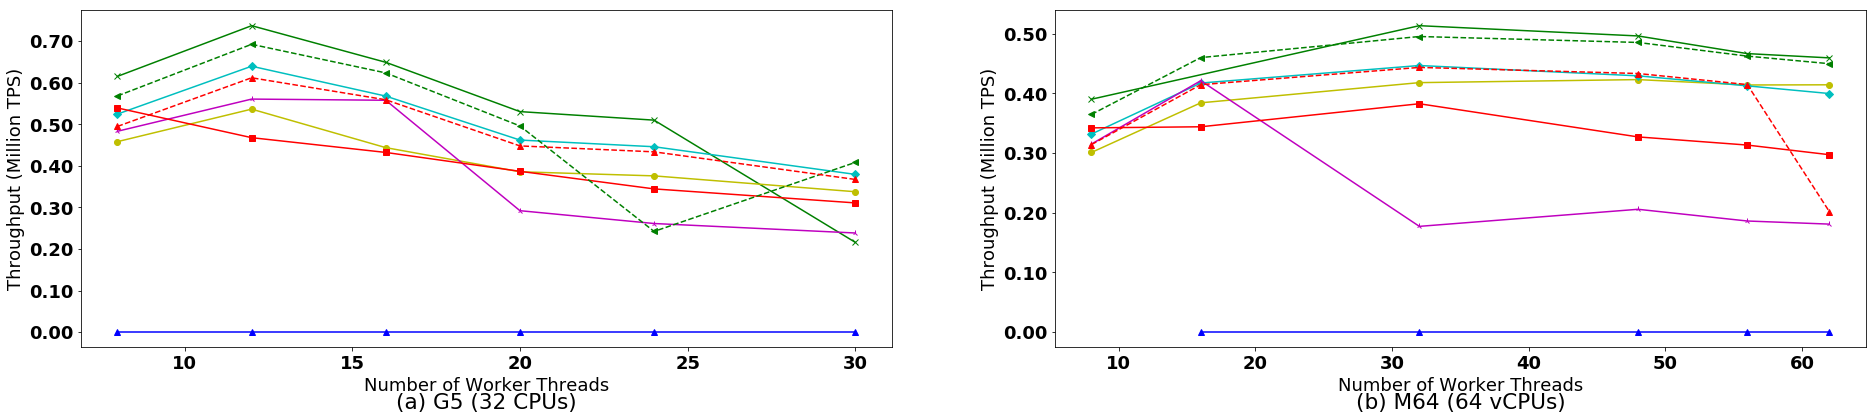

In [238]:
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean'}
agg_req = agg_req_normal
us = 1000000

tpcc_G32_set1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set1_GS32"
tpcc_G32_set2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set2_GS32"
tpcc_G32 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_payment_mpr0_GS32"

# df_tpcc_G32 = pd.concat([pd.DataFrame(parse_directory(tpcc_G32_set1)), pd.DataFrame(parse_directory(tpcc_G32_set2))])
df_tpcc_G32 = pd.DataFrame(parse_directory(tpcc_G32));
del df_tpcc_G32['commit_strategy']
df_tpcc_G32['vm'] = 32

tpcc_M64_set1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set1_M64"
tpcc_M64_set2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set2_M64"
# df_tpcc_M64 = pd.concat([pd.DataFrame(parse_directory(tpcc_M64_set1)), pd.DataFrame(parse_directory(tpcc_M64_set2))])
tpcc_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_payment_mpr0_M64"
df_tpcc_M64 = pd.DataFrame(parse_directory(tpcc_M64));
del df_tpcc_M64['commit_strategy']
df_tpcc_M64['vm'] = 64

tpcc_M128_set1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set1_M128"
tpcc_M128_set2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set2_M128"
# df_tpcc_M128 = pd.concat([pd.DataFrame(parse_directory(tpcc_M128_set1)), pd.DataFrame(parse_directory(tpcc_M128_set2))])

tpcc_M128 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_payment_mpr0_M128"
df_tpcc_M128 = pd.DataFrame(parse_directory(tpcc_M128));
del df_tpcc_M128['commit_strategy']
df_tpcc_M128['vm'] = 128

combined = pd.concat([df_tpcc_G32,df_tpcc_M64,df_tpcc_M128])
# combined = pd.concat([df_tpcc_G32,df_tpcc_M128])

grouped_f = combined.groupby(['cc_alg','vm','worker_cnt','pt_cnt']).agg(agg_req)


pd.options.display.float_format = '{:,.2f}'.format

ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]
plt.figure(figsize=(32,6.2))

algs = list(grouped_f.index.levels[0])
# print(grouped_f.index)
# grouped_f.reindex(['GS32', 'M64', 'M128'])
ztheta = list(grouped_f.index.levels[1])
# print(ztheta)
pc =0
# print(algs)
# print(ztheta)
doplot = True
for t in ztheta:
    doplot = False
    line_labels = []
    line_yvals = []
    line_xvals = []
    line_theta = []
    for a in algs:
#         ll = '{}-{}'.format(a,t)
        ll = a
#         print(ll)
#         print(t)
        line_labels.append(ll)
        yvals = list(grouped_f.loc[a,t]['tput'])
        yvals_s = list( map(lambda x : x/us, yvals))
        xvals = list(grouped_f.loc[a,t].index.get_level_values(0))
#         print(yvals)
#         print(xvals)
        line_yvals.append(yvals_s)
        line_xvals.append(xvals)
        line_theta.append(t)
    
    doplot = True

    if doplot:
        pc = pc + 1
        plti = 120 + pc
        print(plti)
    #     print(len(line_yvals))
        title_y_offset = -0.2
        ax = plt.subplot(plti)
#         ax = plt.subplot() # single plot
        if t == 32:
            ax.set_title("(a) G5 (32 CPUs)", y=title_y_offset)
        elif t == 64:
            ax.set_title("(b) M64 (64 vCPUs)".format(t), y=title_y_offset)
        else:
            ax.set_title("(c) M128 (128 vCPUs)".format(t), y=title_y_offset)
        for i in range(len(line_yvals)):
            ls_tmp = ls[i]

            ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
            ax.set_ylabel('Throughput (Million TPS)')
            # ax.set_xlabel('Zipfian Theta')
            ax.set_xlabel('Number of Worker Threads')
#3 plots            
# plt.legend(bbox_to_anchor=(-2.8, 1.02, 3.8, .102), 
#            loc=8,ncol=8, mode="expand", borderaxespad=0.)
# 2 plots
plt.legend(bbox_to_anchor=(-1.4, 1.02, 2.4, .102), 
           loc=8,ncol=8, mode="expand", borderaxespad=0.)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

# grouped_f

131
132


tput  phys_mem_usage
cc_alg    zipf_theta worker_cnt pt_cnt                           
HSTORE    0.60       8          8       35,913.29   38,032,864.00
                     16         16      32,280.08   51,340,692.00
                     32         32      17,324.36   37,894,738.00
                     48         48      21,656.25   81,203,744.00
                     56         56      20,355.66   85,563,980.00
                     64         64       8,702.45   59,542,100.00
          0.99       8          8       42,095.60   36,916,704.00
                     32         32      35,582.57   75,485,348.00
                     48         48      22,668.96   82,009,632.00
                     56         56      20,833.81   85,254,732.00
                     64         64       7,513.83   59,077,204.00
MVCC      0.60       8          8      178,163.44   97,044,960.00
                     16         16     271,268.34  140,954,004.00
                     32         32     162,102.45   86,870,722.00
                     48         48     413,948.36  222,324,236.00
                     56         56     398,092.03  225,676,872.00
                     64         64      70,735.54   48,658,220.00
          0.99       8          8      119,689.94   78,921,184.00
                     16         16     214,056.50  121,764,244.00
                     32         32     188,495.81  100,710,480.00
                     48         48     106,314.52   86,818,682.00
                     56         56     150,146.34  118,683,208.00
                     64         64     102,677.96   92,785,240.00
NOWAIT    0.60       8          8      213,203.16   32,937,024.00
                     16         16     366,218.35   46,626,964.00
                     32         32     259,447.38   37,536,326.00
                     48         48     268,913.54   46,128,510.00
                     56         56     261,373.13   48,276,780.00
                     64         64     163,981.44   51,427,388.00
          0.99       8          8       56,043.17   18,003,488.00
...                                           ...             ...
SILO      0.99       8          8      107,782.32   32,456,392.00
                     16         16     214,453.89   41,760,760.00
                     32         32     305,856.12   58,390,240.00
                     48         48     415,155.19   85,289,288.00
                     56         56     397,855.93   88,978,440.00
                     64         64     296,298.58   70,623,285.33
TIMESTAMP 0.60       8          8      197,429.09   32,586,208.00
                     16         16     335,204.13   45,012,372.00
                     32         32     415,864.24   63,892,868.00
                     48         48     525,708.48   91,821,580.00
                     56         56     490,682.87   94,213,704.00
                     64         64     166,177.60   52,475,480.00
          0.99       8          8      141,920.90   33,547,744.00
                     16         16     256,873.29   44,316,052.00
                     32         32           0.00            0.00
                     48         48     322,329.20   77,853,196.00
                     56         56     112,880.85   62,000,712.00
                     64         64      56,506.37   45,499,992.00
WAITDIE   0.60       8          8      196,067.64   32,369,732.00
                     16         16     329,666.97   44,643,480.00
                     32         32     213,797.19   32,025,782.00
                     48         48     522,104.02   90,720,000.00
                     56         56     509,875.31   94,581,340.00
                     64         64     161,312.79   51,213,376.00
          0.99       8          8      103,163.56   34,892,868.00
                     16         16     105,029.04   21,943,884.00
                     32         32     150,565.05   29,864,118.00
                     48         48     392,571.40   83,697,408.00
                   

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


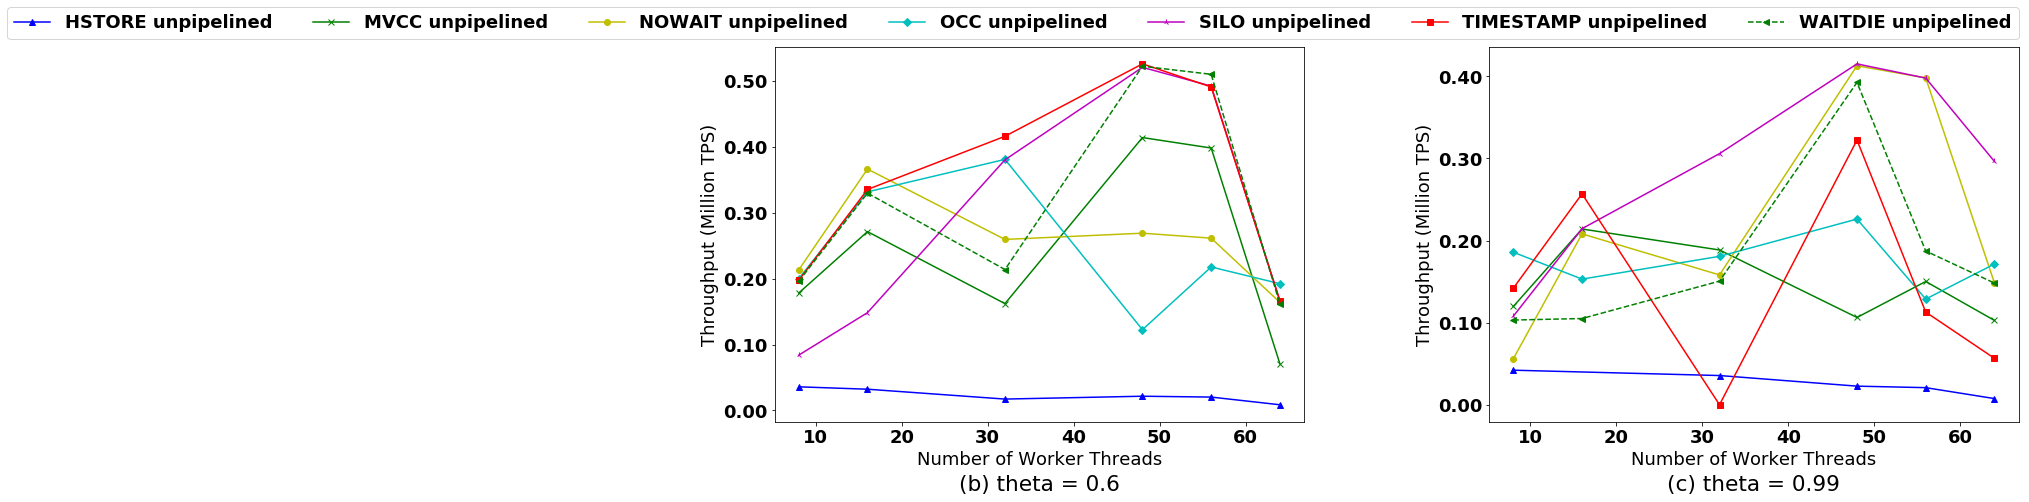

In [249]:
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean'}
agg_req = agg_req_normal
us = 1000000
q_pipelined = False
pd.options.display.float_format = '{:,.2f}'.format

# grp_indexes = ['cc_alg','vm','worker_cnt','pt_cnt']
grp_indexes = ['cc_alg','zipf_theta','worker_cnt','pt_cnt']

# tpcc_G32_set1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set1_GS32"
# tpcc_G32_set2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set2_GS32"
# tpcc_G32 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_payment_mpr0_GS32"

# df_tpcc_G32 = pd.concat([pd.DataFrame(parse_directory(tpcc_G32_set1)), pd.DataFrame(parse_directory(tpcc_G32_set2))])
# df_tpcc_G32 = pd.DataFrame(parse_directory(tpcc_G32));
# del df_tpcc_G32['commit_strategy']
# df_tpcc_G32['vm'] = 32

ycsb_quecc_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt6pt99_M64"
df_ycsb_quecc_M64 = pd.DataFrame(parse_directory(ycsb_quecc_M64));
# df_ycsb_quecc_M64 = df_ycsb_quecc_M64[df_ycsb_quecc_M64['zipf_theta'] != '0.60']
# print(df_ycsb_quecc_M64)
del df_ycsb_quecc_M64['commit_strategy']
df_ycsb_quecc_M64['vm'] = 64

# tpcc_M128_set1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set1_M128"
# tpcc_M128_set2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set2_M128"
# df_tpcc_M128 = pd.concat([pd.DataFrame(parse_directory(tpcc_M128_set1)), pd.DataFrame(parse_directory(tpcc_M128_set2))])

# tpcc_M128 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_payment_mpr0_M128"
# df_tpcc_M128 = pd.DataFrame(parse_directory(tpcc_M128));
# del df_tpcc_M128['commit_strategy']
# df_tpcc_M128['vm'] = 128

# combined = pd.concat([df_tpcc_G32,df_tpcc_M64,df_tpcc_M128])
# combined = pd.concat([df_tpcc_G32,df_tpcc_M128])
combined = df_ycsb_quecc_M64
grouped_f = combined.groupby(grp_indexes).agg(agg_req)

ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]
plt.figure(figsize=(32,6.2))

algs = list(grouped_f.index.levels[0])
# print(grouped_f.index)
# grouped_f.reindex(['GS32', 'M64', 'M128'])
ztheta = list(grouped_f.index.levels[1])
# print(ztheta)
pc =0
# print(algs)
# print(ztheta)
doplot = True
for t in ztheta:
    doplot = False
    line_labels = []
    line_yvals = []
    line_xvals = []
    line_theta = []
    for a in algs:
#         ll = '{}-{}'.format(a,t)
        ll = "{} unpipelined".format(a)
#         print(ll)
#         print(t)
        line_labels.append(ll)
        yvals = list(grouped_f.loc[a,t]['tput'])
        yvals_s = list( map(lambda x : x/us, yvals))
        xvals = list(grouped_f.loc[a,t].index.get_level_values(0))
#         print(yvals)
#         print(xvals)
        line_yvals.append(yvals_s)
        line_xvals.append(xvals)
        line_theta.append(t)
    
    doplot = True

    if doplot:
        pc = pc + 1
        plti = 130 + pc
        print(plti)
    #     print(len(line_yvals))
        title_y_offset = -0.2
        ax = plt.subplot(plti)
#         ax = plt.subplot() # single plot
#         if t == 32:
#             ax.set_title("(a) G5 (32 CPUs)", y=title_y_offset)
#         elif t == 64:
#             ax.set_title("(b) M64 (64 vCPUs)".format(t), y=title_y_offset)
#         else:
#             ax.set_title("(c) M128 (128 vCPUs)".format(t), y=title_y_offset)

        if t == '0.00':
            ax.set_title("(a) theta = 0.0 (Uniform)", y=title_y_offset)
        elif t == '0.60':
            ax.set_title("(b) theta = 0.6".format(t), y=title_y_offset)
        else:
            ax.set_title("(c) theta = 0.99".format(t), y=title_y_offset)
        for i in range(len(line_yvals)):
            ls_tmp = ls[i]

            ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
            ax.set_ylabel('Throughput (Million TPS)')
            # ax.set_xlabel('Zipfian Theta')
            ax.set_xlabel('Number of Worker Threads')
#3 plots            
plt.legend(bbox_to_anchor=(-2.8, 1.02, 3.8, .102), 
           loc=8,ncol=8, mode="expand", borderaxespad=0.)
# 2 plots
# plt.legend(bbox_to_anchor=(-1.4, 1.02, 2.4, .102), 
#            loc=8,ncol=8, mode="expand", borderaxespad=0.)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
grouped_f
# df_ycsb_quecc_M64

In [248]:
combined[combined['cc_alg'] == 'OCC'].groupby(grp_indexes).agg(agg_req)

tput  phys_mem_usage
cc_alg zipf_theta worker_cnt pt_cnt                           
OCC    0.60       8          8      199,989.26        38695392
                  16         16     331,573.47        54431124
                  32         32     380,831.75        70555012
                  48         48     122,545.24        31058694
                  56         56     217,681.52        61674060
                  64         64     192,308.89        60881496
       0.99       8          8      185,793.69        39382496
                  16         16     153,031.91        27298506
                  32         32     180,761.34        35010242
                  48         48     226,150.71        61942284
                  56         56           0.00               0
                  64         64     171,398.74        62357080

[100]
['HSTORE', 'MVCC', 'NOWAIT', 'OCC', 'QUECC', 'SILO', 'TIMESTAMP', 'WAITDIE']
[100]


tput  phys_mem_usage  trial_no
cc_alg    pt_perc worker_cnt                                     
HSTORE    100     4          130,755.58        25782490         2
                  8          188,978.77        41390282         2
                  16         272,610.64        67560008         2
                  24         323,081.27        83202108         2
                  32         366,815.73        89465722         2
MVCC      100     4          103,228.92        77789460         2
                  8          161,043.62       122685568         2
                  16         243,453.38       189138628         2
                  24         277,859.94       214138928         2
                  32         291,447.19       217400178         2
NOWAIT    100     4          107,329.70        34315128         2
                  8          172,526.87        56988440         2
                  16         260,392.50        89929574         2
                  24         223,677.75        80335086         2
                  32         170,530.55        62883750         2
OCC       100     4          123,244.01        44143768         2
                  8          195,858.90        71812232         2
                  16         300,779.12       115520072         2
                  24         309,596.63       123560058         2
                  32         259,993.71       107876218         2
QUECC     100     4          109,520.96        62202058         2
                  8          154,509.19        88429914         2
                  16         198,240.00       109752578         2
                  24         176,395.34        99258894         2
                  32         205,278.12       109803532         2
SILO      100     4          105,400.72        37325842         2
                  8          165,341.44        59918508         2
                  16         133,619.70        50735592         2
                  24         103,734.83        39888476         2
                  32          80,675.37        32898096         2
TIMESTAMP 100     4          116,986.37        37820700         2
                  8          190,449.80        63374472         2
                  16         297,065.76       103728712         2
                  24         346,416.65       125012024         2
                  32         368,119.32       131418936         2
WAITDIE   100     4          102,471.61        33113902         2
                  8          164,319.25        55167628         2
                  16         251,469.26        87687964         2
                  24         234,605.37        82183464         2
                  32         169,681.18        63423456         2

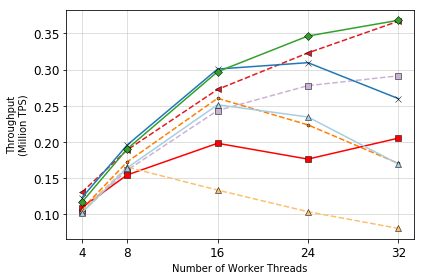

In [87]:
##QueCC Plots -- Scalability Vs Throughput - TPCC
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean','trial_no':'count'}
agg_req = agg_req_normal
us = 1000000
q_pipelined = False
pd.options.display.float_format = '{:,.2f}'.format

grp_indexes = ['cc_alg','pt_perc', 'worker_cnt']
figoutdir = '/Users/qadahtm/Google Drive/MBP2/PhDResearch/QueCC/paper_figs/'

outfname = '{}tpcc-wtvar-GS32.pdf'.format(figoutdir)



tpcc_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_final_wtvar_quecc_GS32"
tpcc_df = pd.DataFrame(parse_directory(tpcc_data));
tpcc_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_final_wtvar_set1_GS32"
tpcc_df = pd.concat([tpcc_df,pd.DataFrame(parse_directory(tpcc_data))]);
tpcc_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_final_wtvar_set2_GS32"
tpcc_df = pd.concat([tpcc_df,pd.DataFrame(parse_directory(tpcc_data))]);
combined = tpcc_df


grouped_f = combined.groupby(grp_indexes).agg(agg_req)

plt.figure()
algs = list(grouped_f.index.levels[0])
# print(grouped_f.index)
# grouped_f.reindex(['GS32', 'M64', 'M128'])
ztheta = list(grouped_f.index.levels[1])
pt_ratio = list(grouped_f.index.levels[1])
# vm_cnt = list(grouped_f.index.levels[1])
print(pt_ratio)
pc =0
print(algs)
print(ztheta)
doplot = True
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []

for ptr in pt_ratio:
    for a in algs:
        ll = a
#             ll = 'PT-{}%'.format(ptr)
#         print(grouped_f.loc[a,t].index.get_level_values(0))
#         ll = "PT-{}-ET{}".format(grouped_f.loc[a,t]['pt_cnt'],grouped_f.loc[a,t]['et_cnt'])
#         print(ll)
#         print(ptr)
        line_labels.append(ll)
        yvals = list(grouped_f.loc[a,ptr]['tput'])
        yvals_s = list( map(lambda x : x/us, yvals))
        xvals = list(grouped_f.loc[a,ptr].index.get_level_values(0))
# #             print(yvals)
# #             print(xvals)
        line_yvals.append(yvals_s)
        line_xvals.append(xvals)
        line_theta.append(t)

doplot = True


plti = 110 + pc
title_y_offset = -0.2
ax = plt.subplot(111)
for i in range(len(line_labels)):
    ls_tmp = ls_dict[line_labels[i]]
    ax.plot(line_xvals[i],line_yvals[i], marker=ls_tmp['marker'], linestyle=ls_tmp['linestyle'], color=ls_tmp['color'], markeredgewidth=0.5,markeredgecolor='black', label=line_labels[i])
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%2.2f'))
    ax.set_ylabel('Throughput\n(Million TPS)')
    ax.set_xlabel('Number of Worker Threads')

plt.xticks(line_xvals[1],line_xvals[1], fontsize=12)
plt.yticks(fontsize=12)

# plt.legend(bbox_to_anchor=(0, 1.02, 1.0, .102), 
#            loc=8,ncol=2, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig(outfname,format='pdf')
grouped_f

# combined

In [77]:
list(grouped_f.loc['SILO',100]['tput'])

[105400.7242725,
 165341.44324699999,
 133619.70019800001,
 103734.827451,
 80675.370461000013]

[100]
['MVCC', 'NOWAIT', 'OCC', 'QUECC', 'TIMESTAMP', 'WAITDIE']
['0.00']


tput  phys_mem_usage  trial_no
cc_alg    zipf_theta pt_perc worker_cnt                                       
MVCC      0.00       100     4            326,577.53   68,154,700.00         2
                             8            572,365.26  111,715,660.00         2
                             16         1,056,278.67  199,599,436.00         2
                             24         1,333,460.89  268,178,764.00         2
                             32         1,668,409.03  334,411,084.00         2
NOWAIT    0.00       100     4             86,654.97   22,885,712.00         2
                             8            319,586.40   30,607,354.67         3
                             16           604,370.92   49,218,896.00         2
                             24           772,165.71   64,662,864.00         2
                             32         1,076,894.78   86,773,072.00         3
OCC       0.00       100     4            161,248.87   29,210,956.00         2
                             8            312,862.20   41,733,452.00         2
                             16           519,885.53   64,740,684.00         2
                             24           421,307.44   49,101,132.00         2
                             32           322,911.19   40,662,348.00         2
QUECC     0.00       100     4          1,068,655.33   15,618,952.00         2
                             8          2,166,004.01   24,747,916.00         2
                             16         3,599,510.40   29,438,872.00         2
                             24         3,708,201.04   35,884,964.00         2
                             32         3,302,891.50   35,188,792.00         2
TIMESTAMP 0.00       100     4            334,659.21   33,339,724.00         2
                             8            612,672.89   51,426,636.00         2
                             16         1,120,458.72   90,820,940.00         2
                             24         1,398,216.30  117,510,476.00         2
                             32         1,818,327.08  141,823,308.00         2
WAITDIE   0.00       100     4             82,222.16   21,968,208.00         2
                             8            317,556.84   31,039,824.00         2
                             16           613,073.86   52,733,264.00         2
                             24           697,744.86   60,670,288.00         2
                             32           955,648.34   72,747,344.00         2

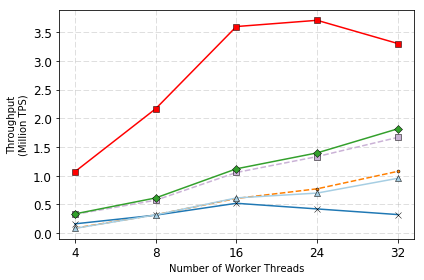

In [432]:
##QueCC Plots -- Scalability Vs Throughput
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean','trial_no':'count'}
agg_req = agg_req_normal
us = 1000000
q_pipelined = False
pd.options.display.float_format = '{:,.2f}'.format

grp_indexes = ['cc_alg','zipf_theta','pt_perc', 'worker_cnt']
figoutdir = '/Users/qadahtm/Google Drive/MBP2/PhDResearch/QueCC/paper_figs/'
# outfname = '{}ycsb-scalability-thetapt99-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-scalability-theta0-GS32.pdf'.format(figoutdir)
outfname = '{}ycsb-wtvar-theta0-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-wtvar-thetapt8-GS32.pdf'.format(figoutdir)

# ycsb_final_theta0_wtvar_set1_GS32
# ycsb_final_theta0_wtvar_set2_GS32
# ycsb_final_theta0pt8_wtvar_quecc_GS32
# ycsb_final_thetapt8_wtvar_set1_GS32
# ycsb_final_thetapt8_wtvar_set2_GS32

ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/nov_exps/ycsb_final_theta0_wtvar_others_GS32"
ycsb_df = pd.DataFrame(parse_directory(ycsb_data));
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/nov_exps/ycsb_final_theta0_wtvar_quecc_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
# ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0_wtvar_set2_GS32"
# ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);

# ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_thetapt8_wtvar_set1_GS32"
# ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
# ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_thetapt8_wtvar_set2_GS32"
# ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
ycsb_df = ycsb_df[ycsb_df['tput'] > 0]
# ycsb_df = ycsb_df[ycsb_df['zipf_theta'] == '0.80']
ycsb_df = ycsb_df[ycsb_df['zipf_theta'] == '0.00']


# tpcc_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_final_wtvar_quecc_GS32"
# tpcc_df = pd.DataFrame(parse_directory(tpcc_data));
# tpcc_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_final_wtvar_set1_GS32"
# tpcc_df = pd.concat([tpcc_df,pd.DataFrame(parse_directory(tpcc_data))]);
# tpcc_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_final_wtvar_set2_GS32"
# tpcc_df = pd.concat([tpcc_df,pd.DataFrame(parse_directory(tpcc_data))]);
# combined = tpcc_df

combined = ycsb_df

# ycsbfile = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_quecc_GS32"

# ycsb_quecc_GS32 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_quecc_GS32"
# ycsb_quecc_GS32 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_quecc_1_GS32"
# ycsb_quecc_GS32 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0_scalability_GS32"
# ycsb_quecc_GS32_1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0_scalability_1_GS32"

# ycsb_quecc_GS32 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_scalability_GS32"
# ycsb_quecc_GS32_1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_scalability_1_GS32"

# ycsb_quecc_GS32 = pd.DataFrame(parse_directory(ycsb_quecc_GS32_1));
# ycsb_quecc_GS32 = pd.concat([pd.DataFrame(parse_directory(ycsb_quecc_GS32)),pd.DataFrame(parse_directory(ycsb_quecc_GS32_1))]);
# ycsb_quecc_GS32 = ycsb_quecc_GS32[ycsb_quecc_GS32['tput'] > 0]
# ycsb_quecc_pip_GS32 = ycsb_quecc_GS32[ycsb_quecc_GS32['pt_perc'] != 100]
# ycsb_quecc_unpip_GS32 = ycsb_quecc_GS32[ycsb_quecc_GS32['pt_perc'] == 100]


# ycsb_quecc_unpip_GS32 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0_unpip_quecc_GS32"
# ycsb_quecc_unpip_GS32 = pd.DataFrame(parse_directory(ycsb_quecc_unpip_GS32));
# ycsb_quecc_unpip_GS32 = ycsb_quecc_unpip_GS32[ycsb_quecc_unpip_GS32['zipf_theta'] != '0.60']
# ycsb_quecc_unpip_GS32 = ycsb_quecc_unpip_GS32[ycsb_quecc_unpip_GS32['zipf_theta'] != '0.00']
# del ycsb_quecc_unpip_GS32['commit_strategy']
# ycsb_quecc_unpip_GS32['vm'] = 32

# ycsb_quecc_pip_GS32 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0_pip_quecc_GS32"
# ycsb_quecc_pip_GS32 = pd.DataFrame(parse_directory(ycsb_quecc_pip_GS32));
# ycsb_quecc_pip_GS32 = ycsb_quecc_pip_GS32[ycsb_quecc_pip_GS32['zipf_theta'] != '0.60']
# ycsb_quecc_pip_GS32 = ycsb_quecc_pip_GS32[ycsb_quecc_pip_GS32['zipf_theta'] != '0.00']
# del ycsb_quecc_pip_GS32['commit_strategy']
# ycsb_quecc_pip_GS32['vm'] = 32
# ycsb_quecc_pip_GS32['worker_cnt'] = ycsb_quecc_pip_GS32['et_cnt']+ycsb_quecc_pip_GS32['pt_cnt']

# ycsb_quecc_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt6pt99_quecc_M64"
# ycsb_quecc_M64 = pd.DataFrame(parse_directory(ycsb_quecc_M64));
# ycsb_quecc_M64 = ycsb_quecc_M64[ycsb_quecc_M64['tput'] > 0]
# ycsb_quecc_M64 = ycsb_quecc_M64[ycsb_quecc_M64['zipf_theta'] == '0.99']
# ycsb_quecc_pip_M64 = ycsb_quecc_M64[ycsb_quecc_M64['pt_perc'] != 100]
# ycsb_quecc_unpip_M64 = ycsb_quecc_M64[ycsb_quecc_M64['pt_perc'] == 100]



# ycsb_quecc_unpip_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_unpip_bsize_quecc_M64"
# ycsb_quecc_unpip_M64 = pd.DataFrame(parse_directory(ycsb_quecc_unpip_M64));
# ycsb_quecc_unpip_M64 = ycsb_quecc_unpip_M64[ycsb_quecc_unpip_M64['zipf_theta'] != '0.60']
# ycsb_quecc_unpip_M64 = ycsb_quecc_unpip_M64[ycsb_quecc_unpip_M64['zipf_theta'] != '0.00']
# ycsb_quecc_unpip_M64 = ycsb_quecc_unpip_M64[ycsb_quecc_unpip_M64['tput'] > 0]
# del ycsb_quecc_unpip_M64['commit_strategy']
# ycsb_quecc_unpip_M64['vm'] = 64

# ycsb_quecc_pip_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_pip_quecc_M64"
# ycsb_quecc_pip_M64 = pd.DataFrame(parse_directory(ycsb_quecc_pip_M64));
# ycsb_quecc_pip_M64 = ycsb_quecc_pip_M64[ycsb_quecc_pip_M64['zipf_theta'] != '0.60']
# ycsb_quecc_pip_M64 = ycsb_quecc_pip_M64[ycsb_quecc_pip_M64['zipf_theta'] != '0.00']
# ycsb_quecc_pip_M64 = ycsb_quecc_pip_M64[ycsb_quecc_pip_M64['tput'] > 0]
# del ycsb_quecc_pip_M64['commit_strategy']
# ycsb_quecc_pip_M64['vm'] = 64
# ycsb_quecc_pip_M64['worker_cnt'] = ycsb_quecc_pip_M64['et_cnt']+ycsb_quecc_pip_M64['pt_cnt']

# combined = pd.concat([ycsb_quecc_unpip_GS32,ycsb_quecc_pip_GS32])
# combined = pd.concat([ycsb_quecc_pip_GS32])
# print(combined)
# combined = pd.concat([ycsb_quecc_unpip_M64,ycsb_quecc_pip_M64])
# combined = pd.concat([ycsb_quecc_pip_GS32, ycsb_quecc_unpip_GS32])
# combined = pd.concat([ycsb_quecc_unpip_M64,ycsb_quecc_pip_M64, ycsb_quecc_pip_GS32, ycsb_quecc_unpip_GS32])
# combined = ycsb_quecc_unpip_M64

grouped_f = combined.groupby(grp_indexes).agg(agg_req)

# ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]
# plt.figure(figsize=(32,6.2))
# plt.figure(figsize=(16,10))
plt.figure()

algs = list(grouped_f.index.levels[0])
# print(grouped_f.index)
# grouped_f.reindex(['GS32', 'M64', 'M128'])
ztheta = list(grouped_f.index.levels[1])
pt_ratio = list(grouped_f.index.levels[2])
# vm_cnt = list(grouped_f.index.levels[1])
print(pt_ratio)
pc =0
print(algs)
print(ztheta)
doplot = True
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []


for ptr in pt_ratio:
    for t in ztheta:
        doplot = False        
        for a in algs:
            ll = a
#             ll = 'PT-{}%'.format(ptr)
    #         print(grouped_f.loc[a,t].index.get_level_values(0))
    #         ll = "PT-{}-ET{}".format(grouped_f.loc[a,t]['pt_cnt'],grouped_f.loc[a,t]['et_cnt'])
#             print(ll)
#             print(t)
            line_labels.append(ll)
            yvals = list(grouped_f.loc[a,t,ptr]['tput'])
            yvals_s = list( map(lambda x : x/us, yvals))
            xvals = list(grouped_f.loc[a,t,ptr].index.get_level_values(0))
#             print(yvals)
#             print(xvals)
            line_yvals.append(yvals_s)
            line_xvals.append(xvals)
            line_theta.append(t)

doplot = True


plti = 110 + pc
title_y_offset = -0.2
ax = plt.subplot(111)
x_ticks = list(range(len(line_xvals[0])))
for i in range(len(line_labels)):
#     ls_tmp = ls[i]
#     print(i)
    ls_tmp = ls_dict[line_labels[i]]
#     print(i)
#     ax.plot(line_xvals[i],line_yvals[i], marker=ls_tmp['marker'], linestyle=ls_tmp['linestyle'], color=ls_tmp['color'], markeredgewidth=0.5,markeredgecolor='black', label=line_labels[i])    
    ax.plot(x_ticks,line_yvals[i], marker=ls_tmp['marker'], linestyle=ls_tmp['linestyle'], color=ls_tmp['color'], markeredgewidth=0.5,markeredgecolor='black', label=line_labels[i])
#     ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%2.1f'))
    ax.set_ylabel('Throughput\n(Million TPS)')
    # ax.set_xlabel('Zipfian Theta')
    ax.set_xlabel('Number of Worker Threads')
plt.xticks(x_ticks,line_xvals[0], fontsize=12)
plt.yticks(fontsize=12)

# plt.legend(bbox_to_anchor=(0, 1.02, 1.0, .102), 
#            loc=8,ncol=2, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig(outfname,format='pdf')
grouped_f

# combined

In [497]:
# cores = [8,12,16,20,24,32,48,56,64,96,112,128]
muls = [2,4,8,16]
for m in muls:
    print(m*13440)
[13440,26880,53760,107520]
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')
cmap.get_array()

26880
53760
107520
215040


AttributeError: 'LinearSegmentedColormap' object has no attribute 'get_array'

In [397]:
#Global plot parameters
ls = [{'marker':'s','linestyle':'-','color':'red'},
      {'marker':'^','linestyle':'-','color':'#a6cee3'},
      {'marker':'x','linestyle':'-','color':'#1f78b4'},
      {'marker':'o','linestyle':'-','color':'#b2df8a'},
      {'marker':'D','linestyle':'-','color':'#33a02c'},
      {'marker':'2','linestyle':'-','color':'#fb9a99'},
      {'marker':'<','linestyle':'--','color':'#e31a1c'},
      {'marker':'^','linestyle':'--','color':'#fdbf6f'},
      {'marker':'.','linestyle':'--','color':'#ff7f00'},
      {'marker':'s','linestyle':'--','color':'#cab2d6'},
      {'marker':'*','linestyle':'--','color':'#6a3d9a'},
      {'marker':'*','linestyle':'-','color':'#b15928'},
      {'marker':'|','linestyle':'--','color':'#ffff99'},
     {'marker':'s','linestyle':'--','color':'red'}]

# ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]
ls_dict = {'HSTORE':ls[6],'OCC':ls[2],'SILO':ls[7],'QUECC':ls[0],'NOWAIT':ls[8],
           'TIMESTAMP':ls[4],'WAITDIE':ls[1],'MVCC':ls[9],'QUECC-JEO3':ls[13],'QUECC-Lat99\'tile':ls[9], 'QUECC-AVG-Lat':ls[0]}

HSTORE
0.80
[58214.257566, 58149.414613999994, 58107.811719499994, 57650.512344000002]
MVCC
0.80
[501114.59427849995, 446353.75260599999, 314261.50888350001, 252316.96576400002]
NOWAIT
0.80
[649407.9705385, 641783.33614049992, 627574.12983350002, 606517.66755399993]
OCC
0.80
[364558.67668849998, 381537.87786150002, 380677.06379049999, 406560.890311]
QUECC
0.80
[1358111.6481619999, 1407159.438266, 1366725.1919590002, 1348017.8643375]
SILO
0.80
[589135.39395299996, 569770.72323200002, 538737.95583550003, 486137.26564100001]
TIMESTAMP
0.80
[656148.377966, 625531.35993149993, 587687.9906585, 537041.4153615]
WAITDIE
0.80
[617208.70430100011, 612038.6031835, 591653.93576999998, 592134.3912675]


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


tput  phys_mem_usage  \
cc_alg    zipf_theta rec_size worker_cnt                                
HSTORE    0.00       500      32            58,214.26        64400648   
                     1000     32            58,149.41        72653064   
                     2000     32            58,107.81        89510156   
                     4000     32            57,650.51       123344268   
MVCC      0.00       500      32           501,114.59       176632072   
                     1000     32           446,353.75       231467272   
                     2000     32           314,261.51       279324940   
                     4000     32           252,316.97       411382156   
NOWAIT    0.00       500      32           649,407.97        82136448   
                     1000     32           641,783.34        89790848   
                     2000     32           627,574.13       105948548   
                     4000     32           606,517.67       138902920   
OCC       0.00       500      32           364,558.68        65202440   
                     1000     32           381,537.88        75111688   
                     2000     32           380,677.06        92101900   
                     4000     32           406,560.89       128203148   
QUECC     0.00       500      32         1,358,111.65        21814948   
                     1000     32         1,407,159.44        30419624   
                     2000     32         1,366,725.19        47636136   
                     4000     32         1,348,017.86        82060976   
SILO      0.00       500      32           589,135.39        77149512   
                     1000     32           569,770.72        84120904   
                     2000     32           538,737.96        99290444   
                     4000     32           486,137.27       126397776   
TIMESTAMP 0.00       500      32           656,148.38        84186372   
                     1000     32           625,531.36        90305796   
                     2000     32           587,687.99       102532360   
                     4000     32           537,041.42       130136456   
WAITDIE   0.00       500      32           617,208.70        80316804   
                     1000     32           612,038.60        87809412   
                     2000     32           591,653.94       102564232   
                     4000     32           592,134.39       135112076   

                                          trial_no  
cc_alg    zipf_theta rec_size worker_cnt            
HSTORE    0.00       500      32                 2  
                     1000     32                 2  
                     2000     32                 2  
                     4000     32                 2  
MVCC      0.00       500      32                 2  
                     1000     32                 2  
                     2000     32                 2  
                     4000     32                 2  
NOWAIT    0.00       500      32                 2  
                     1000     32                 2  
                     2000     32                 2  
                     4000     32                 2  
OCC       0.00       500      32                 2  
                     1000     32                 2  
                     2000     32                 2  
                     4000     32                 2  
QUECC     0.00       500      32                 2  
                     1000     32                 2  
                     2000     32                 2  
                     4000     32                 2  
SILO      0.00       500      32                 2  
                     1000     32                 2  
                     2000     32                 2  
                     4000     32                 2  
TIMESTAMP 0.00       500      32                 2  
                     1000     32                 2  
                     2000     32                 2  
                     4000    

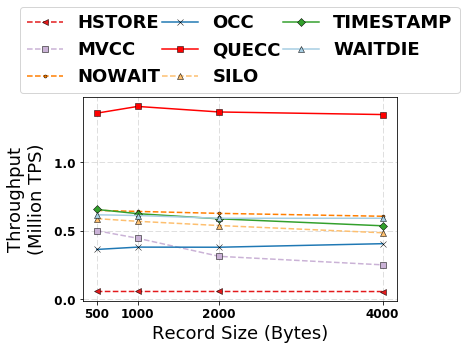

In [626]:
##QueCC Plots -- Record size var - Throughput
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean', 'trial_no':'count'}
agg_req = agg_req_normal
us = 1000000
q_pipelined = False
pd.options.display.float_format = '{:,.2f}'.format
grp_indexes = ['cc_alg','zipf_theta','rec_size','worker_cnt']
# cores = 32
cores = 64
figoutdir = '/Users/qadahtm/Google Drive/MBP2/PhDResearch/QueCC/paper_figs/'
outfname = '{}ycsb-rsizevar-theta0-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-rsizevar-thetapt8-GS32.pdf'.format(figoutdir)




ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_rsize_quecc_GS32"
ycsb_df = pd.DataFrame(parse_directory(ycsb_data));
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_rsize_set1_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_rsize_set2_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);


ycsb_df = ycsb_df[ycsb_df['tput'] != 0]
ycsb_df = ycsb_df[ycsb_df['zipf_theta'] == '0.00']
# ycsb_df = ycsb_df[ycsb_df['zipf_theta'] == '0.80']

combined = ycsb_df

grouped_f = combined.groupby(grp_indexes).agg(agg_req)
# plt.figure(figsize=(32,6.2))
# plt.figure(figsize=(16,10))
# plt.figure(figsize=(6.4,4.8))
plt.figure()
# plt.rc('grid', linestyle="--")
plt.grid(True)
# plt.set_cmap('Dark2')
# plt.set_cmap('spectral')

algs = list(grouped_f.index.levels[0])
# print(grouped_f.index)
# grouped_f.reindex(['GS32', 'M64', 'M128'])
ztheta = list(grouped_f.index.levels[1])
pt_ratio = list(grouped_f.index.levels[2])
vm_cnt = list(grouped_f.index.levels[0])
# print(ztheta)
pc =0
# print(algs)
# print(ztheta)
doplot = True
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
ptr = 100
for a in algs:
    ll = a
    print(ll)
    print(t)
    line_labels.append(ll)
    yvals = list(grouped_f.loc[a]['tput'])
    xvals = list(grouped_f.loc[a].index.get_level_values(1))
#     xvals = list( map(lambda x : float(x), xvals))
    yvals_s = list( map(lambda x : x/us, yvals))

    print(yvals)
#             print(xvals)
    line_yvals.append(yvals_s)
    line_xvals.append(xvals)
    line_theta.append(t)

doplot = True

# if doplot:
# pc = pc + 1
plti = 110 + pc
# print(plti)
#     print(len(line_yvals))
title_y_offset = -0.2
ax = plt.subplot(111)
for i in range(len(line_labels)):
#     ls_tmp = ls[i]
    ls_tmp = ls_dict[line_labels[i]]
    ax.plot(line_xvals[i],line_yvals[i], marker=ls_tmp['marker'], linestyle=ls_tmp['linestyle'], color=ls_tmp['color'], markeredgewidth=0.5,markeredgecolor='black', label=line_labels[i])
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.1f'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f'))
    ax.set_ylabel('Throughput\n(Million TPS)')
    ax.set_xlabel('Record Size (Bytes)')

plt.xticks(line_xvals[1],line_xvals[1], fontsize=12)
plt.yticks(fontsize=12)
lgd = plt.legend(bbox_to_anchor=(-.2, 1.02, 1.4, .102), 
           loc=8,ncol=3, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)
plt.grid(True)
plt.tight_layout()
plt.savefig(outfname,format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
grouped_f

MVCC
0.00
[1716826.190836, 1661786.0296209999, 1619257.9155075001, 902903.08594466653, 1514.2664540000001]
NOWAIT
0.00
[1470295.8267665, 1468658.7724259999, 1399782.1327736669, 545852.79482399998, 282409.71490350005]
OCC
0.00
[331885.489527, 328613.447637, 324659.90766899998, 357336.89245499996, 356190.76425000001]
QUECC
0.00
[3222201.5161730004, 3265571.1780425003, 3222535.2183380001, 3353313.8260065001, 3406228.7386145]
TIMESTAMP
0.00
[1777835.3042935, 1827074.7620399999, 1754202.5136760001, 10851.50526, 1939.001381]
WAITDIE
0.00
[962758.95035349997, 976401.22599599999, 1090042.6357869999, 510786.82241849997, 223460.4102905]


tput  phys_mem_usage  trial_no
cc_alg    zipf_theta pt_perc worker_cnt                                       
MVCC      0.00       100     32         1,716,826.19  330,888,524.00         2
          0.30       100     32         1,661,786.03  333,444,428.00         2
          0.60       100     32         1,619,257.92  329,790,796.00         2
          0.80       100     32           902,903.09  229,937,142.67         3
          0.90       100     32             1,514.27   20,954,444.00         2
NOWAIT    0.00       100     32         1,470,295.83  250,711,372.00         2
          0.30       100     32         1,468,658.77  254,625,100.00         2
          0.60       100     32         1,399,782.13  198,062,754.67         3
          0.80       100     32           545,852.79   61,134,160.00         2
          0.90       100     32           282,409.71   49,501,520.00         2
OCC       0.00       100     32           331,885.49   41,215,308.00         2
          0.30       100     32           328,613.45   40,858,956.00         2
          0.60       100     32           324,659.91   40,858,956.00         2
          0.80       100     32           357,336.89   45,819,212.00         2
          0.90       100     32           356,190.76   53,695,820.00         2
QUECC     0.00       100     32         3,222,201.52   35,172,404.00         2
          0.30       100     32         3,265,571.18   34,234,420.00         2
          0.60       100     32         3,222,535.22   34,254,900.00         2
          0.80       100     32         3,353,313.83   32,636,980.00         2
          0.90       100     32         3,406,228.74   30,232,628.00         2
TIMESTAMP 0.00       100     32         1,777,835.30  141,914,444.00         2
          0.30       100     32         1,827,074.76  145,152,332.00         2
          0.60       100     32         1,754,202.51  141,406,540.00         2
          0.80       100     32            10,851.51   37,283,148.00         2
          0.90       100     32             1,939.00   20,954,444.00         2
WAITDIE   0.00       100     32           962,758.95   76,311,888.00         2
          0.30       100     32           976,401.23   71,759,184.00         2
          0.60       100     32         1,090,042.64   87,602,512.00         2
          0.80       100     32           510,786.82   57,464,144.00         2
          0.90       100     32           223,460.41   48,686,416.00         2

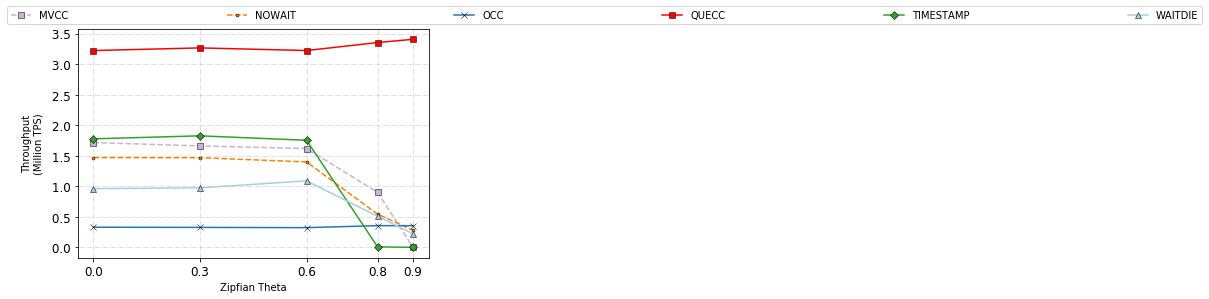

In [435]:
##QueCC Plots -- ThetaVar - Throughput
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean', 'trial_no':'count'}
agg_req = agg_req_normal
us = 1000000
q_pipelined = False
pd.options.display.float_format = '{:,.2f}'.format
grp_indexes = ['cc_alg','zipf_theta','pt_perc','worker_cnt']
# cores = 32
cores = 64
figoutdir = '/Users/qadahtm/Google Drive/MBP2/PhDResearch/QueCC/paper_figs/'
outfname = '{}ycsb-thetavar-GS32.pdf'.format(figoutdir)

# ycsb_final_thetavar_quecc_GS32
# ycsb_final_thetavar_set1_GS32
# ycsb_final_thetavar_set2_GS32

# ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_thetavar_quecc2_GS32"
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/nov_exps/ycsb_final_thetavar_quecc_GS32"
ycsb_df = pd.DataFrame(parse_directory(ycsb_data));
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/nov_exps/ycsb_final_thetavar_others_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
# ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_thetavar_set2_GS32"
# ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);


ycsb_df = ycsb_df[ycsb_df['tput'] != 0]

combined = ycsb_df

grouped_f = combined.groupby(grp_indexes).agg(agg_req)
# plt.figure(figsize=(32,6.2))
# plt.figure(figsize=(16,10))
# plt.figure(figsize=(6.4,4.8))
plt.figure()
# plt.rc('grid', linestyle="--")
plt.grid(True)
# plt.set_cmap('Dark2')
# plt.set_cmap('spectral')

algs = list(grouped_f.index.levels[0])
# print(grouped_f.index)
# grouped_f.reindex(['GS32', 'M64', 'M128'])
ztheta = list(grouped_f.index.levels[1])
pt_ratio = list(grouped_f.index.levels[2])
vm_cnt = list(grouped_f.index.levels[0])
# print(ztheta)
pc =0
# print(algs)
# print(ztheta)
doplot = True
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
ptr = 100
for a in algs:
    ll = a
    print(ll)
    print(t)
    line_labels.append(ll)
    yvals = list(grouped_f.loc[a]['tput'])
    xvals = list(grouped_f.loc[a].index.get_level_values(0))
    xvals = list( map(lambda x : float(x), xvals))
    yvals_s = list( map(lambda x : x/us, yvals))

    print(yvals)
#             print(xvals)
    line_yvals.append(yvals_s)
    line_xvals.append(xvals)
    line_theta.append(t)

doplot = True

# if doplot:
# pc = pc + 1
plti = 110 + pc
# print(plti)
#     print(len(line_yvals))
title_y_offset = -0.2
ax = plt.subplot(111)
for i in range(len(line_labels)):
#     ls_tmp = ls[i]
    ls_tmp = ls_dict[line_labels[i]]
    ax.plot(line_xvals[i],line_yvals[i], marker=ls_tmp['marker'], linestyle=ls_tmp['linestyle'], color=ls_tmp['color'], markeredgewidth=0.5,markeredgecolor='black', label=line_labels[i])
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.1f'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f'))
    ax.set_ylabel('Throughput\n(Million TPS)')
    ax.set_xlabel('Zipfian Theta')

plt.xticks(line_xvals[0],line_xvals[0], fontsize=12)
plt.yticks(fontsize=12)
lgd = plt.legend(bbox_to_anchor=(-.2, 1.02, 3.4, .102), 
           loc=8,ncol=12, mode="expand", borderaxespad=0.)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.grid(True)
plt.tight_layout()
plt.savefig(outfname,format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
grouped_f

HSTORE
0.80
[483600.89373349998, 624832.12960999995, 803596.248104, 907369.98174000008, 1107097.679488]
MVCC
0.80
[573291.15994650009, 5695031.7719099997, 6782246.2092960002, 7293199.8040800001, 7756253.6182080004]
NOWAIT
0.80
[489521.53951999999, 6006840.9913250003, 6906597.7105200002, 7077535.7462600004, 7309195.446912]
OCC
0.80
[418388.29005199997, 3804525.8670700006, 7195617.5606079996, 8226976.3464500001, 9844004.7191039994]
QUECC
0.80
[7774604.3821454998, 16351569.278845001, 17084658.323647998, 17046586.85182, 17455451.494634669]
SILO
0.80
[582565.78591000009, 6036881.3046300001, 6852318.9215520006, 7079673.0867099995, 7360532.8611200005]
TIMESTAMP
0.80
[486708.61734900001, 6296477.5165449996, 7953948.2100400003, 8427072.5418899991, 8963685.6883840002]
WAITDIE
0.80
[577591.32836649998, 5931190.6780999992, 6606908.3614560002, 6855872.210909999, 6956325.748416]


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


tput  phys_mem_usage  \
cc_alg    zipf_theta pt_perc req_cnt worker_cnt                                
HSTORE    0.80       100     1       32           483,600.89   52,102,404.00   
                             10      32            62,483.21   57,063,684.00   
                             16      32            50,224.77   60,705,028.00   
                             20      32            45,368.50   63,603,972.00   
                             32      32            34,596.80   68,572,420.00   
MVCC      0.80       100     1       32           573,291.16   69,893,392.00   
                             10      32           569,503.18  126,906,640.00   
                             16      32           423,890.39  127,808,784.00   
                             20      32           364,659.99  128,135,440.00   
                             32      32           242,382.93  123,860,240.00   
NOWAIT    0.80       100     1       32           489,521.54   54,462,840.00   
                             10      32           600,684.10   73,006,456.00   
                             16      32           431,662.36   60,331,384.00   
                             20      32           353,876.79   55,468,408.00   
                             32      32           228,412.36   46,901,624.00   
OCC       0.80       100     1       32           418,388.29   56,865,028.00   
                             10      32           380,452.59   60,478,724.00   
                             16      32           449,726.10   76,449,028.00   
                             20      32           411,348.82   75,288,836.00   
                             32      32           307,625.15   68,741,380.00   
QUECC     0.80       100     1       32         7,774,604.38   30,859,936.00   
                             10      32         1,635,156.93   15,083,888.00   
                             16      32         1,067,791.15   13,306,944.00   
                             20      32           852,329.34   13,783,104.00   
                             32      32           545,482.86   14,004,013.33   
SILO      0.80       100     1       32           582,565.79   64,514,388.00   
                             10      32           603,688.13   75,541,844.00   
                             16      32           428,269.93   60,406,100.00   
                             20      32           353,983.65   54,655,316.00   
                             32      32           230,016.65   43,772,244.00   
TIMESTAMP 0.80       100     1       32           486,708.62   55,589,124.00   
                             10      32           629,647.75   77,075,716.00   
                             16      32           497,121.76   66,170,116.00   
                             20      32           421,353.63   60,326,148.00   
                             32      32           280,115.18   49,898,756.00   
WAITDIE   0.80       100     1       32           577,591.33   63,357,320.00   
                             10      32           593,119.07   74,215,816.00   
                             16      32           412,931.77   59,521,416.00   
                             20      32           342,793.61   54,326,664.00   
                             32      32           217,385.18   45,136,264.00   

                                                 trial_no  
cc_alg    zipf_theta pt_perc req_cnt worker_cnt            
HSTORE    0.80       100     1       32                 2  
                             10      32                 2  
                             16      32                 2  
                             20      32                 2  
                             32      32                 2  
MVCC      0.80       100     1       32                 2  
                             10      32                 2  
                             16      32                 2  
                             20      32                 2  
                             32    

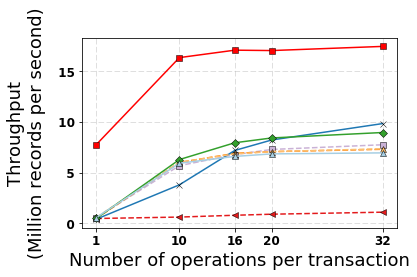

In [574]:
##QueCC Plots -- Request per transaction - optvar - Throughput
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean', 'trial_no':'count'}
agg_req = agg_req_normal
us = 1000000
q_pipelined = False
pd.options.display.float_format = '{:,.2f}'.format
grp_indexes = ['cc_alg','zipf_theta','pt_perc','req_cnt','worker_cnt']
# cores = 32
cores = 64
figoutdir = '/Users/qadahtm/Google Drive/MBP2/PhDResearch/QueCC/paper_figs/'
# outfname = '{}ycsb-req-thetapt99-M64.pdf'.format(figoutdir)
# outfname = '{}ycsb-req-theta0-M64.pdf'.format(figoutdir)

# outfname = '{}ycsb-req-thetapt99-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-req-theta0-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-optvar-theta0-GS32.pdf'.format(figoutdir)
outfname = '{}ycsb-optvar-thetapt8-GS32.pdf'.format(figoutdir)

# ycsb_final_theta0pt8_optvar_quecc_GS32
# ycsb_final_theta0pt8_optvar_set1_GS32
# ycsb_final_theta0pt8_optvar_set2_GS32
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_optvar_quecc_GS32"
ycsb_df = pd.DataFrame(parse_directory(ycsb_data));
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_optvar_set1_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_optvar_set2_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);

ycsb_df =  ycsb_df[ycsb_df['tput'] != 0]
# ycsb_df = ycsb_df[ycsb_df['zipf_theta'] == '0.00']
ycsb_df = ycsb_df[ycsb_df['zipf_theta'] == '0.80']
combined = ycsb_df

# ycsb_quecc_req_old= "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0_req_GS32"
# ycsb_quecc_req1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0_req_1_GS32"
# ycsb_quecc_req2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0_req_2_GS32"


# ycsb_quecc_req1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_req_GS32"
# ycsb_quecc_req2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_req_1_GS32"



# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_req_GS32"

# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0_req_M64"
# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_req_M64"


# ycsb_quecc_bsize_M64 = pd.DataFrame(parse_directory(ycsb_quecc_req1));
# ycsb_quecc_bsize_M64 = pd.concat([ycsb_quecc_bsize_M64,pd.DataFrame(parse_directory(ycsb_quecc_req2))]);

# ycsb_quecc_bsize_M64 =  ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['tput'] != 0]
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.00']
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.99']
# ycsb_quecc_unpip_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['pt_perc'] == 100]

# ycsb_quecc_pip_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['pt_perc'] != 100]
# ycsb_quecc_pip_M64['worker_cnt'] = ycsb_quecc_pip_M64['et_cnt']+ycsb_quecc_pip_M64['pt_cnt']

# combined = pd.concat([ycsb_quecc_unpip_M64,ycsb_quecc_pip_M64])

grouped_f = combined.groupby(grp_indexes).agg(agg_req)

# ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]
# ls_dict = {'HSTORE':ls[0],'OCC':ls[1],'SILO':ls[2],'QueCC':ls[3],'NOWAIT':ls[4],
#            'TIMESTAMP':ls[6],'WAITDIE':ls[6],'MVCC':ls[6]}
# plt.figure(figsize=(32,6.2))
# plt.figure(figsize=(16,10))
# plt.figure(figsize=(6.4,4.8))
plt.figure()
plt.rc('grid', linestyle="--",alpha=0.5)
plt.grid(True)

algs = list(grouped_f.index.levels[0])
# print(grouped_f.index)
# grouped_f.reindex(['GS32', 'M64', 'M128'])
ztheta = list(grouped_f.index.levels[1])
pt_ratio = list(grouped_f.index.levels[2])
vm_cnt = list(grouped_f.index.levels[0])
# print(ztheta)
pc =0
# print(algs)
# print(ztheta)
doplot = True
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
for ptr in pt_ratio:
    for t in ztheta:
        doplot = False        
        for a in algs:
#             ll = 'PT-{}%'.format(ptr)
            ll = a
    #         print(grouped_f.loc[a,t].index.get_level_values(0))
            print(ll)
            print(t)
            line_labels.append(ll)
            yvals = list(grouped_f.loc[a,t,ptr]['tput'])
            xvals = list(grouped_f.loc[a,t,ptr].index.get_level_values(0))
            yvals = [a*b for a,b in zip(yvals,xvals)]
            yvals_s = list( map(lambda x : x/us, yvals))

            print(yvals)
#             print(xvals)
            line_yvals.append(yvals_s)
            line_xvals.append(xvals)
            line_theta.append(t)

doplot = True
plti = 110 + pc

title_y_offset = -0.2
plt.xticks(line_xvals[1],line_xvals[1], fontsize=12)
plt.yticks(fontsize=12)
ax = plt.subplot(111)

for i in range(len(line_labels)):
#     ls_tmp = ls[i]
#     print(i)    
#     ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
    
    ls_tmp = ls_dict[line_labels[i]]
    ax.plot(line_xvals[i],line_yvals[i], marker=ls_tmp['marker'], linestyle=ls_tmp['linestyle'], color=ls_tmp['color'], markeredgewidth=0.5,markeredgecolor='black', label=line_labels[i])
    
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4d'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.set_ylabel('Throughput\n(Million records per second)')
    # ax.set_xlabel('Zipfian Theta')
    ax.set_xlabel('Number of operations per transaction')
#3 plots            
# plt.legend(bbox_to_anchor=(-2.8, 1.02, 3.8, .102), 
#            loc=8,ncol=8, mode="expand", borderaxespad=0.)
# 2 plots
# plt.legend(bbox_to_anchor=(-1.4, 1.02, 2.4, .102), 
#            loc=8,ncol=8, mode="expand", borderaxespad=0.)

# plt.legend(bbox_to_anchor=(0, 1.02, 1.0, .102), 
#            loc=8,ncol=8, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)
plt.tight_layout()
plt.savefig(outfname,format='pdf')
grouped_f
# grouped_f.loc['QUECC','0.99','100']

HSTORE
0.80
[61782.684951000003, 61473.9677945, 61742.827538999998, 61452.251598000003, 61769.084747000001]
MVCC
0.80
[648377.91665499995, 623383.30906599993, 557731.16128850006, 470172.27682899998, 444910.76224499999]
NOWAIT
0.80
[689296.82102599996, 651957.50533999992, 612579.21112599992, 533943.62723500002, 505303.94009199995]
OCC
0.80
[651370.39835050004, 547146.68619249994, 356689.22977750003, 286710.97771449998, 253619.14811800001]
QUECC
0.80
[1891954.3015109999, 1804161.3372685001, 1588941.498252, 1388157.1790760001, 1267869.1637365001]
SILO
0.80
[656370.70267649996, 640194.94083450001, 597091.06675600004, 539789.25765149994, 511570.31062100001]
TIMESTAMP
0.80
[681567.84319599997, 670478.25509750005, 670881.63589949999, 626796.67221249989, 602438.78050499992]
WAITDIE
0.80
[677954.97996549995, 643245.18975300004, 585619.92679349997, 526152.09206249996, 498671.08479300002]


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


tput  \
cc_alg    zipf_theta pt_perc write_perc worker_cnt                
HSTORE    0.80       100     0.05       32            61,782.68   
                             0.20       32            61,473.97   
                             0.50       32            61,742.83   
                             0.80       32            61,452.25   
                             0.95       32            61,769.08   
MVCC      0.80       100     0.05       32           648,377.92   
                             0.20       32           623,383.31   
                             0.50       32           557,731.16   
                             0.80       32           470,172.28   
                             0.95       32           444,910.76   
NOWAIT    0.80       100     0.05       32           689,296.82   
                             0.20       32           651,957.51   
                             0.50       32           612,579.21   
                             0.80       32           533,943.63   
                             0.95       32           505,303.94   
OCC       0.80       100     0.05       32           651,370.40   
                             0.20       32           547,146.69   
                             0.50       32           356,689.23   
                             0.80       32           286,710.98   
                             0.95       32           253,619.15   
QUECC     0.80       100     0.05       32         1,891,954.30   
                             0.20       32         1,804,161.34   
                             0.50       32         1,588,941.50   
                             0.80       32         1,388,157.18   
                             0.95       32         1,267,869.16   
SILO      0.80       100     0.05       32           656,370.70   
                             0.20       32           640,194.94   
                             0.50       32           597,091.07   
                             0.80       32           539,789.26   
                             0.95       32           511,570.31   
TIMESTAMP 0.80       100     0.05       32           681,567.84   
                             0.20       32           670,478.26   
                             0.50       32           670,881.64   
                             0.80       32           626,796.67   
                             0.95       32           602,438.78   
WAITDIE   0.80       100     0.05       32           677,954.98   
                             0.20       32           643,245.19   
                             0.50       32           585,619.93   
                             0.80       32           526,152.09   
                             0.95       32           498,671.08   

                                                    phys_mem_usage  trial_no  
cc_alg    zipf_theta pt_perc write_perc worker_cnt                            
HSTORE    0.80       100     0.05       32                57367828         2  
                             0.20       32                57371924         2  
                             0.50       32                57519380         2  
                             0.80       32                57403668         2  
                             0.95       32                57491732         2  
MVCC      0.80       100     0.05       32               101507336         2  
                             0.20       32               105525512         2  
                             0.50       32               126433544         2  
                             0.80       32               155656456         2  
                             0.95       32               176738568         2  
NOWAIT    0.80       100     0.05       32                81019272         2  
                             0.20       32                78843272         2  
                             0.50       32                76114312         2  
                             0.80       32                7

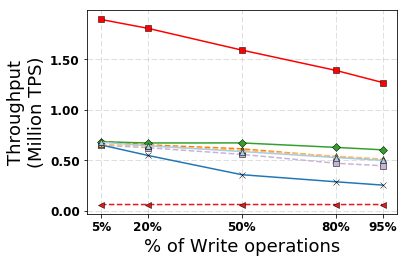

In [572]:
##QueCC Plots -- Write percentage - Throughput
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean', 'trial_no':'count'}
agg_req = agg_req_normal
us = 1000000
q_pipelined = False
pd.options.display.float_format = '{:,.2f}'.format
grp_indexes = ['cc_alg','zipf_theta','pt_perc','write_perc','worker_cnt']
# cores = 32
cores = 64
figoutdir = '/Users/qadahtm/Google Drive/MBP2/PhDResearch/QueCC/paper_figs/'
# outfname = '{}ycsb-wpvar-thetapt99-M64.pdf'.format(figoutdir)
# outfname = '{}ycsb-wpvar-theta0-M64.pdf'.format(figoutdir)

# outfname = '{}ycsb-wpvar-thetapt99-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-wpvar-theta0-GS32.pdf'.format(figoutdir)
outfname = '{}ycsb-wpvar-thetapt8-GS32.pdf'.format(figoutdir)

# ycsb_final_theta0_wpvar_set1_GS32
# ycsb_final_theta0_wpvar_set2_GS32
# ycsb_final_theta0pt8_wpvar_quecc_GS32
# ycsb_final_thetapt8_wpvar_set1_GS32
# ycsb_final_thetapt8_wpvar_set2_GS32
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_wpvar_quecc_GS32"
ycsb_df = pd.DataFrame(parse_directory(ycsb_data));
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0_wpvar_set1_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0_wpvar_set2_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);

ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_thetapt8_wpvar_set1_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_thetapt8_wpvar_set2_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
ycsb_df =  ycsb_df[ycsb_df['tput'] != 0]
# ycsb_df = ycsb_df[ycsb_df['zipf_theta'] == '0.00']
ycsb_df = ycsb_df[ycsb_df['zipf_theta'] == '0.80']
combined = ycsb_df

# ycsb_quecc_GS32_mprvar = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wpvar_theta0_GS32"
# ycsb_quecc_GS32_mprvar1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wpvar_theta0_1_GS32"

# ycsb_quecc_GS32_mprvar = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wpvar_thetapt99_GS32"
# ycsb_quecc_GS32_mprvar1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wpvar_thetapt99_1_GS32"

# ycsb_quecc_bsize_M64 = pd.DataFrame(parse_directory(ycsb_quecc_GS32_mprvar))
                                    
# ycsb_quecc_bsize_M64 = pd.concat([pd.DataFrame(parse_directory(ycsb_quecc_GS32_mprvar)),
#                                   pd.DataFrame(parse_directory(ycsb_quecc_GS32_mprvar1))])
# ycsb_quecc_bsize_M64 =  ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['tput'] != 0]
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.00']
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.99']
# ycsb_quecc_unpip_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['pt_perc'] == 100]

# ycsb_quecc_pip_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['pt_perc'] != 100]
# ycsb_quecc_pip_M64['worker_cnt'] = ycsb_quecc_pip_M64['et_cnt']+ycsb_quecc_pip_M64['pt_cnt']

# combined = pd.concat([ycsb_quecc_unpip_M64,ycsb_quecc_pip_M64])

grouped_f = combined.groupby(grp_indexes).agg(agg_req)

# ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]

plt.figure()
plt.rc('grid', linestyle="--",alpha=0.5)
plt.grid(True)

algs = list(grouped_f.index.levels[0])
ztheta = list(grouped_f.index.levels[1])
pt_ratio = list(grouped_f.index.levels[2])
vm_cnt = list(grouped_f.index.levels[0])
pc =0
doplot = True
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
for ptr in pt_ratio:
    for t in ztheta:
        doplot = False        
        for a in algs:
            ll = a # 'PT-{}%'.format(ptr)
    #         print(grouped_f.loc[a,t].index.get_level_values(0))
            print(ll)
            print(t)
            line_labels.append(ll)
            yvals = list(grouped_f.loc[a,t,ptr]['tput'])
            xvals = list(grouped_f.loc[a,t,ptr].index.get_level_values(0))
            xvals = list( map(lambda x : float(x*100), xvals))
#             yvals = [a*b for a,b in zip(yvals,xvals)]
            yvals_s = list( map(lambda x : x/us, yvals))

            print(yvals)
#             print(xvals)
            line_yvals.append(yvals_s)
            line_xvals.append(xvals)
            line_theta.append(t)

doplot = True

plti = 110 + pc

title_y_offset = -0.2
plt.xticks(line_xvals[1],line_xvals[1], fontsize=12)
plt.yticks(fontsize=12)
ax = plt.subplot(111)


for i in range(len(line_labels)):
#     ls_tmp = ls[i]
#     print(i)
    ls_tmp = ls_dict[line_labels[i]]
    ax.plot(line_xvals[i],line_yvals[i], marker=ls_tmp['marker'], linestyle=ls_tmp['linestyle'], color=ls_tmp['color'], markeredgewidth=0.5,markeredgecolor='black', label=line_labels[i])
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%2.2f'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.f%%'))
    ax.set_ylabel('Throughput\n(Million TPS)')
    # ax.set_xlabel('Zipfian Theta')
    ax.set_xlabel('% of Write operations')

# plt.legend(bbox_to_anchor=(0, 1.02, 1.0, .102), 
#            loc=8,ncol=2, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)
plt.tight_layout()
plt.savefig(outfname,format='pdf')
grouped_f

['HSTORE', 'MVCC', 'NOWAIT', 'OCC', 'QUECC', 'SILO', 'TIMESTAMP', 'WAITDIE']
['0.80']


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


tput  \
cc_alg    zipf_theta pt_perc pa_cnt total_txn_cnt worker_cnt                
HSTORE    0.80       100     1      500000        32           542,922.41   
                             2      500000        32           142,595.43   
                             4      500000        32            74,575.24   
                             8      500000        32            42,863.23   
                             10     500000        32            39,741.54   
MVCC      0.80       100     1      500000        32           586,163.59   
                             2      500000        32           554,601.35   
                             4      500000        32           554,575.59   
                             8      500000        32           552,360.10   
                             10     500000        32           551,490.24   
NOWAIT    0.80       100     1      500000        32           672,344.20   
                             2      500000        32           633,616.16   
                             4      500000        32           607,386.77   
                             8      500000        32           606,800.48   
                             10     500000        32           596,449.00   
OCC       0.80       100     1      500000        32           345,946.61   
                             2      500000        32           350,738.74   
                             4      500000        32           358,031.73   
                             8      500000        32           366,582.67   
                             10     500000        32           366,089.02   
QUECC     0.80       100     1      500000        32         1,385,664.00   
                             2      500000        32         1,417,887.69   
                             4      500000        32         1,632,091.68   
                             8      500000        32         1,675,189.62   
                             10     500000        32         1,614,149.23   
SILO      0.80       100     1      500000        32           659,334.50   
                             2      500000        32           612,802.32   
                             4      500000        32           596,771.37   
                             8      500000        32           597,120.99   
                             10     500000        32           582,827.10   
TIMESTAMP 0.80       100     1      500000        32           687,498.31   
                             2      500000        32           643,752.41   
                             4      500000        32           655,280.89   
                             8      500000        32           642,120.09   
                             10     500000        32           656,813.08   
WAITDIE   0.80       100     1      500000        32           663,636.96   
                             2      500000        32           609,395.03   
                             4      500000        32           582,412.45   
                             8      500000        32           584,480.42   
                             10     500000        32           585,699.80   

                                                              phys_mem_usage  \
cc_alg    zipf_theta pt_perc pa_cnt total_txn_cnt worker_cnt                   
HSTORE    0.80       100     1      500000        32                65013000   
                             2      500000        32                51361032   
                             4      500000        32                55623944   
                             8      500000        32                60851464   
                             10     500000        32                61780232   
MVCC      0.80       100     1      500000        32               127989000   
                             2      500000        32               126312712   
                             4      500000        32               124851464   
                             8    

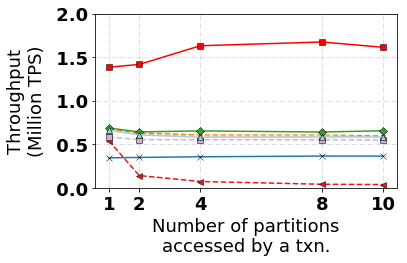

In [558]:
##QueCC Plots -- partiton accessed per transaction - Throughput
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean', 'trial_no':'count'}
agg_req = agg_req_normal
us = 1000000
q_pipelined = False
pd.options.display.float_format = '{:,.2f}'.format
grp_indexes = ['cc_alg','zipf_theta','pt_perc','pa_cnt','total_txn_cnt','worker_cnt']
# cores = 32
cores = 64
figoutdir = '/Users/qadahtm/Google Drive/MBP2/PhDResearch/QueCC/paper_figs/'
# outfname = '{}ycsb-req-thetapt99-M64.pdf'.format(figoutdir)
# outfname = '{}ycsb-req-theta0-M64.pdf'.format(figoutdir)

# outfname = '{}ycsb-pptvar-thetapt99-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-theta0-opt16-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-theta0-opt10-GS32.pdf'.format(figoutdir)

# outfname = '{}ycsb-pptvar-theta0-opt10-mpr100-100Ktxn-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-thetapt8-opt10-mpr100-100Ktxn-GS32.pdf'.format(figoutdir)

# outfname = '{}ycsb-pptvar-theta0-opt10-mpr10-100Ktxn-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-thetapt8-opt10-mpr10-100Ktxn-GS32.pdf'.format(figoutdir)

# outfname = '{}ycsb-pptvar-theta0-opt10-mpr100-3200Ktxn-rr-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-thetapt8-opt10-mpr100-3200Ktxn-rr-GS32.pdf'.format(figoutdir)

# outfname = '{}ycsb-pptvar-theta0-opt10-mpr10-3200Ktxn-rr-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-thetapt8-opt10-mpr10-3200Ktxn-rr-GS32.pdf'.format(figoutdir)

# outfname = '{}ycsb-pptvar-theta0-opt10-mpr100-3200Ktxn-bal-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-thetapt8-opt10-mpr100-3200Ktxn-bal-GS32.pdf'.format(figoutdir)

# outfname = '{}ycsb-pptvar-theta0-opt10-mpr10-3200Ktxn-bal-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-thetapt8-opt10-mpr10-3200Ktxn-bal-GS32.pdf'.format(figoutdir)


# outfname = '{}ycsb-pptvar-thetapt8-opt16-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-thetapt8-opt10-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-thetapt8-opt10-test-GS32.pdf'.format(figoutdir)

# outfname = '{}ycsb-pptvar-theta0-opt10-mpr100-100Brec-100Ktxn-rr-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-theta0-opt10-mpr100-100Brec-500Ktxn-rr-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-theta0-opt10-mpr100-100Brec-1600Ktxn-rr-GS32.pdf'.format(figoutdir)

# outfname = '{}ycsb-pptvar-thetapt8-opt10-mpr100-100Brec-100Ktxn-rr-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-thetapt8-opt10-mpr100-100Brec-500Ktxn-rr-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-thetapt8-opt10-mpr100-100Brec-1600Ktxn-rr-GS32.pdf'.format(figoutdir)

# outfname = '{}ycsb-pptvar-theta0-opt16-mpr100-100Brec-100Ktxn-rr-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-theta0-opt16-mpr100-100Brec-500Ktxn-rr-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-theta0-opt16-mpr100-100Brec-1600Ktxn-rr-GS32.pdf'.format(figoutdir)

# outfname = '{}ycsb-pptvar-thetapt8-opt16-mpr100-100Brec-100Ktxn-rr-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-thetapt8-opt16-mpr100-100Brec-500Ktxn-rr-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-thetapt8-opt16-mpr100-100Brec-1600Ktxn-rr-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-pptvar-theta0-GS32.pdf'.format(figoutdir)
outfname = '{}ycsb-pptvar-thetapt8-GS32.pdf'.format(figoutdir)

# ycsb_final_theta0_pptvar_set1_GS32
# ycsb_final_theta0_pptvar_set2_GS32
# ycsb_final_theta0pt8_pptvar_quecc_GS32
# ycsb_final_thetapt8_pptvar_set1_GS32
# ycsb_final_thetapt8_pptvar_set2_GS32

ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_pptvar_quecc_GS32"
ycsb_df = pd.DataFrame(parse_directory(ycsb_data));
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0_pptvar_set1_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0_pptvar_set2_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);

ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_thetapt8_pptvar_set1_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_thetapt8_pptvar_set2_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
ycsb_df =  ycsb_df[ycsb_df['tput'] != 0]
# ycsb_df = ycsb_df[ycsb_df['zipf_theta'] == '0.00']
ycsb_df = ycsb_df[ycsb_df['zipf_theta'] == '0.80']
combined = ycsb_df

# ycsb_quecc_pptvar = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_GS32" #bad
# ycsb_quecc_pptvar1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_1_GS32" #bad

# Request per query/txn, OPT=32
# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_2_GS32"
# ycsb_quecc_pptvar3 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_3_GS32"

# Request per query/txn, OPT=10, MPR=10% 
# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt10_mpr10_GS32"
# ycsb_quecc_pptvar3 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt10_mpr10_1_GS32"

# Request per query/txn, OPT=16, MPR=10, theta = 0.0
# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt16_mpr10_GS32"
# ycsb_quecc_pptvar3 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt16_mpr10_1_GS32"

# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_thetapt8_opt16_mpr10_GS32"
# ycsb_quecc_pptvar3 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_thetapt8_opt16_mpr10_1_GS32"

# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt10_mpr10_rr_GS32"
# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt10_mpr10_bal_GS32"

# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt10_mpr100_rr_GS32"
# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt10_mpr100_bal_GS32"

# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt10_mpr100_100Ktxn_GS32"
# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_thetapt8_opt10_mpr100_100Ktxn_GS32"
# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0pt8_opt10_mpr10_100Ktxn_GS32"

# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0pt8_opt10_mpr100_3200Ktxn_rr_GS32"
# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0pt8_opt10_mpr10_3200Ktxn_rr_GS32"


# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt10_mpr100_100Brec_txnwlvar_rr_GS32"
# ycsb_quecc_pptvar3 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt10_mpr100_100Brec_txnwlvar_rr_1_GS32"
# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_thetapt8_opt10_mpr100_100Brec_txnwlvar_rr_GS32"

# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt16_mpr100_100Brec_txnwlvar_rr_GS32"
# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_thetapt8_opt16_mpr100_100Brec_txnwlvar_rr_GS32"

# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0pt8_opt10_mpr100_3200Ktxn_bal_GS32"
# ycsb_pptvar_wp50_theta0pt8_opt10_mpr100_3200Ktxn_bal_GS32
# ycsb_pptvar_wp50_theta0pt8_opt10_mpr10_3200Ktxn_bal_GS32

# ycsb_quecc_pptvar_others = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0pt8_opt16_mpr10_timestamp_nowait_GS32"
# ycsb_quecc_pptvar_others = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0pt8_opt10_mpr100_100Ktxn_timestamp_nowait_lastwl_GS32"
# ycsb_quecc_pptvar_others = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0pt8_opt10_mpr10_100Ktxn_timestamp_nowait_GS32"
# ycsb_quecc_pptvar_others = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0pt8_opt10_mpr100_3200Ktxn_timestamp_nowait_GS32"
# ycsb_quecc_pptvar_others = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0pt8_opt10_mpr10_3200Ktxn_timestamp_nowait_GS32"


# ycsb_quecc_pptvar_others = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt10_mpr100_100Brec_txnwlvar_nowait_GS32"
# ycsb_quecc_pptvar_others = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_thetapt8_opt10_mpr100_100Brec_txnwlvar_nowait_GS32"

# ycsb_quecc_pptvar_others = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0_opt16_mpr100_100Brec_txnwlvar_nowait_GS32"
# ycsb_quecc_pptvar_others = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_thetapt8_opt16_mpr100_100Brec_txnwlvar_nowait_GS32"


# ycsb_quecc_pptvar_others = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_theta0pt8_opt10_mpr10_timestamp_nowait_GS32"

# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_thetapt99_GS32"
# ycsb_quecc_pptvar2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_thetapt99_2_GS32"
# ycsb_quecc_pptvar3 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_pptvar_wp50_thetapt99_3_GS32"

# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0_req_M64"
# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_req_M64"


# ycsb_quecc_bsize_M64 = pd.DataFrame(parse_directory(ycsb_quecc_pptvar2));
# ycsb_quecc_bsize_M64 = pd.concat([ycsb_quecc_bsize_M64,
#                                   pd.DataFrame(parse_directory(ycsb_quecc_pptvar3))]);

# ycsb_quecc_bsize_M64 = pd.concat([ycsb_quecc_bsize_M64,
#                                   pd.DataFrame(parse_directory(ycsb_quecc_pptvar_others))]);

# print(ycsb_quecc_bsize_M64['zipf_theta'])
# ycsb_quecc_bsize_M64 =  ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['tput'] != 0]

# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['total_txn_cnt'] == 100000]
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['total_txn_cnt'] == 500000]
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['total_txn_cnt'] == 1600000]
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.00']
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.80']
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.99']
# ycsb_quecc_unpip_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['pt_perc'] == 100]

# ycsb_quecc_pip_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['pt_perc'] != 100]
# ycsb_quecc_pip_M64['worker_cnt'] = ycsb_quecc_pip_M64['et_cnt']+ycsb_quecc_pip_M64['pt_cnt']

# combined = pd.concat([ycsb_quecc_unpip_M64,ycsb_quecc_pip_M64])

grouped_f = combined.groupby(grp_indexes).agg(agg_req)

# ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]
# ls_dict = {'PT-25%':ls[0],'PT-50%':ls[1],'PT-75%':ls[2],'PT-100%':ls[3],'NOWAIT':ls[4],'TIMESTAMP':ls[6]}

# plt.figure(figsize=(32,6.2))
# plt.figure(figsize=(16,10))
# plt.figure(figsize=(6.4,4.8))
plt.figure()
plt.rc('grid', linestyle="--",alpha=0.5)
plt.grid(True)

algs = list(grouped_f.index.levels[0])
# print(grouped_f.index)
# grouped_f.reindex(['GS32', 'M64', 'M128'])
ztheta = list(grouped_f.index.levels[1])
pt_ratio = list(grouped_f.index.levels[2])
vm_cnt = list(grouped_f.index.levels[0])
# print(ztheta)
pc =0
print(algs)
print(ztheta)
doplot = True
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
for a in algs:
    for t in ztheta:      
        if a == 'QUECC':
            for ptr in pt_ratio:
#                 ll = 'PT-{}%'.format(ptr)
                ll = a
        #         print(grouped_f.loc[a,t].index.get_level_values(0))
                line_labels.append(ll)
                yvals = list(grouped_f.loc[a,t,ptr]['tput'])
                xvals = list(grouped_f.loc[a,t,ptr].index.get_level_values(0))
#                 yvals = [a*b for a,b in zip(yvals,xvals)]
                yvals_s = list( map(lambda x : x/us, yvals))
#                 yvals_s = yvals

#                 print(yvals)
    #             print(xvals)
                line_yvals.append(yvals_s)
                line_xvals.append(xvals)
                line_theta.append(t)
        else:
            ll = a
            line_labels.append(ll)
            yvals = list(grouped_f.loc[a,t,100]['tput'])
            xvals = list(grouped_f.loc[a,t,100].index.get_level_values(0))
#             yvals = [a*b for a,b in zip(yvals,xvals)]
            yvals_s = list( map(lambda x : x/us, yvals))
#             yvals_s = yvals
            line_yvals.append(yvals_s)
            line_xvals.append(xvals)
            line_theta.append(t)

doplot = True
# print(line_labels)
# if doplot:
# pc = pc + 1
plti = 110 + pc
# print(plti)
#     print(len(line_yvals))
title_y_offset = -0.2
ax = plt.subplot(111)
ax.set_ylim([0,2.0])
# ax.set_yscale('log', basey=2)
# ax.autoscale(enable=False)
for i in range(len(line_labels)):
#     ls_tmp = ls[i]
#     ls_tmp = ls_dict[line_labels[i]]
#     ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
    ls_tmp = ls_dict[line_labels[i]]
    ax.plot(line_xvals[i],line_yvals[i], marker=ls_tmp['marker'], linestyle=ls_tmp['linestyle'], color=ls_tmp['color'], markeredgewidth=0.5,markeredgecolor='black', label=line_labels[i])
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.1f'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.set_ylabel('Throughput\n(Million TPS)')
    ax.set_xlabel('Number of partitions\naccessed by a txn.')
plt.xticks(line_xvals[i],line_xvals[i])
# lgd = plt.legend(bbox_to_anchor=(-.2, 1.02, 1.4, .102), 
#            loc=8,ncol=2, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)
plt.grid(True)
plt.tight_layout()
plt.savefig(outfname,format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
grouped_f

HSTORE
0.80
[476606.05919649999, 283429.67192699999, 139533.417158, 83908.770885999998, 60361.990470999997]
MVCC
0.80
[559019.45289000007, 541320.64690950001, 540987.93975599995, 548188.11772549991, 541730.82587299997]
NOWAIT
0.80
[675168.57297850004, 669005.98977550003, 646487.30131600006, 623673.93975799996, 607666.50865600002]
OCC
0.80
[356210.538008, 343890.44626649999, 356198.27093900001, 351173.19280449999, 366039.02811249997]
QUECC
0.80
[1351463.8097945, 1407198.1442745, 1387973.2856864999, 1307669.7412465001, 1674551.6898989999]
SILO
0.80
[635123.293343, 625915.0337894999, 610524.03206450003, 583729.82298649999, 591830.442622]
TIMESTAMP
0.80
[685893.00984150008, 698125.52560649998, 668899.90306749998, 660537.9743615, 666732.87780950009]
WAITDIE
0.80
[646808.4630165, 627433.67814949993, 596449.16280400008, 587115.20727950009, 577100.18063000008]


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


tput  phys_mem_usage  \
cc_alg    zipf_theta pt_perc mpr  worker_cnt                                
HSTORE    0.80       100     0.10 32           476,606.06        66966792   
                             0.20 32           283,429.67        57135368   
                             0.50 32           139,533.42        53237000   
                             0.80 32            83,908.77        54511880   
                             1.00 32            60,361.99        57013512   
MVCC      0.80       100     0.10 32           559,019.45       124535048   
                             0.20 32           541,320.65       123795720   
                             0.50 32           540,987.94       122579208   
                             0.80 32           548,188.12       122476808   
                             1.00 32           541,730.83       123440392   
NOWAIT    0.80       100     0.10 32           675,168.57        80252284   
                             0.20 32           669,005.99        80116092   
                             0.50 32           646,487.30        77791612   
                             0.80 32           623,673.94        76446076   
                             1.00 32           607,666.51        75596156   
OCC       0.80       100     0.10 32           356,210.54        57729288   
                             0.20 32           343,890.45        55915784   
                             0.50 32           356,198.27        57994504   
                             0.80 32           351,173.19        57244936   
                             1.00 32           366,039.03        58966280   
QUECC     0.80       100     0.10 32         1,351,463.81        14832692   
                             0.20 32         1,407,198.14        15230004   
                             0.50 32         1,387,973.29        15173684   
                             0.80 32         1,307,669.74        15098932   
                             1.00 32         1,674,551.69        15083572   
SILO      0.80       100     0.10 32           635,123.29        76621128   
                             0.20 32           625,915.03        76321096   
                             0.50 32           610,524.03        75323720   
                             0.80 32           583,729.82        74042696   
                             1.00 32           591,830.44        74206536   
TIMESTAMP 0.80       100     0.10 32           685,893.01        82573572   
                             0.20 32           698,125.53        82678020   
                             0.50 32           668,899.90        80857348   
                             0.80 32           660,537.97        80193796   
                             1.00 32           666,732.88        79642884   
WAITDIE   0.80       100     0.10 32           646,808.46        75728256   
                             0.20 32           627,433.68        75060608   
                             0.50 32           596,449.16        74018176   
                             0.80 32           587,115.21        73493888   
                             1.00 32           577,100.18        73044352   

                                              trial_no  
cc_alg    zipf_theta pt_perc mpr  worker_cnt            
HSTORE    0.80       100     0.10 32                 2  
                             0.20 32                 2  
                             0.50 32                 2  
                             0.80 32                 2  
                             1.00 32                 2  
MVCC      0.80       100     0.10 32                 2  
                             0.20 32                 2  
                             0.50 32                 2  
                             0.80 32                 2  
                             1.00 32                 2  
NOWAIT    0.80       100     0.10 32                 2  
                             0.20 32                 2  
                    

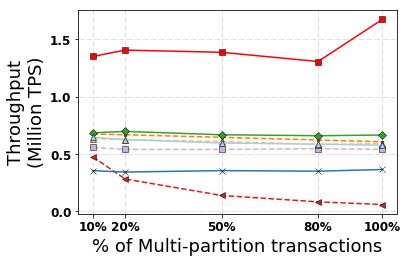

In [561]:
##QueCC Plots -- percentage of MPT in workload - mprvar- Throughput
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean', 'trial_no':'count'}
agg_req = agg_req_normal
us = 1000000
q_pipelined = False
pd.options.display.float_format = '{:,.2f}'.format
grp_indexes = ['cc_alg','zipf_theta','pt_perc','mpr','worker_cnt']
# cores = 32
cores = 64
figoutdir = '/Users/qadahtm/Google Drive/MBP2/PhDResearch/QueCC/paper_figs/'
# outfname = '{}ycsb-req-thetapt99-M64.pdf'.format(figoutdir)
# outfname = '{}ycsb-req-theta0-M64.pdf'.format(figoutdir)

# outfname = '{}ycsb-mprvar-thetapt99-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-mprvar-thetapt0-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-mprvar-theta0-GS32.pdf'.format(figoutdir)
outfname = '{}ycsb-mprvar-thetapt8-GS32.pdf'.format(figoutdir)

# ycsb_final_theta0pt8_mprvar_quecc_GS32
# ycsb_final_theta0pt8_mprvar_set1_GS32
# ycsb_final_theta0pt8_mprvar_set2_GS32
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_mprvar_quecc_GS32"
ycsb_df = pd.DataFrame(parse_directory(ycsb_data));
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_mprvar_set1_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);
ycsb_data = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_mprvar_set2_GS32"
ycsb_df = pd.concat([ycsb_df,pd.DataFrame(parse_directory(ycsb_data))]);

ycsb_df =  ycsb_df[ycsb_df['tput'] != 0]
# ycsb_df = ycsb_df[ycsb_df['zipf_theta'] == '0.00']
ycsb_df = ycsb_df[ycsb_df['zipf_theta'] == '0.80']
combined = ycsb_df

# ycsb_quecc_GS32_mprvar = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0_mprvar_GS32"
# ycsb_quecc_GS32_mprvar1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0_mprvar_1_GS32"

# ycsb_quecc_GS32_mprvar = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_mprvar_GS32"
# ycsb_quecc_GS32_mprvar1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_mprvar_1_GS32"

# ycsb_quecc_bsize_M64 = pd.DataFrame(parse_directory(ycsb_quecc_GS32_mprvar))
                                    
# ycsb_quecc_bsize_M64 = pd.concat([pd.DataFrame(parse_directory(ycsb_quecc_GS32_mprvar)),
#                                   pd.DataFrame(parse_directory(ycsb_quecc_GS32_mprvar1))])
# ycsb_quecc_bsize_M64 =  ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['tput'] != 0]
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.00']
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.99']
# ycsb_quecc_unpip_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['pt_perc'] == 100]

# ycsb_quecc_pip_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['pt_perc'] != 100]
# ycsb_quecc_pip_M64['worker_cnt'] = ycsb_quecc_pip_M64['et_cnt']+ycsb_quecc_pip_M64['pt_cnt']

# combined = pd.concat([ycsb_quecc_unpip_M64,ycsb_quecc_pip_M64])

grouped_f = combined.groupby(grp_indexes).agg(agg_req)

# ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]

plt.figure()
plt.rc('grid', linestyle="--",alpha=0.5)
plt.grid(True)

algs = list(grouped_f.index.levels[0])
ztheta = list(grouped_f.index.levels[1])
pt_ratio = list(grouped_f.index.levels[2])
vm_cnt = list(grouped_f.index.levels[0])
pc =0
doplot = True
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
for ptr in pt_ratio:
    for t in ztheta:
        doplot = False        
        for a in algs:
#             ll = 'PT-{}%'.format(ptr)
            ll = a
    #         print(grouped_f.loc[a,t].index.get_level_values(0))
            print(ll)
            print(t)
            line_labels.append(ll)
            yvals = list(grouped_f.loc[a,t,ptr]['tput'])
            xvals = list(grouped_f.loc[a,t,ptr].index.get_level_values(0))
            xvals = list( map(lambda x : x*100, xvals))
#             yvals = [a*b for a,b in zip(yvals,xvals)]
            yvals_s = list( map(lambda x : x/us, yvals))

            print(yvals)
#             print(xvals)
            line_yvals.append(yvals_s)
            line_xvals.append(xvals)
            line_theta.append(t)

doplot = True

plti = 110 + pc

title_y_offset = -0.2
plt.xticks(line_xvals[1],line_xvals[1], fontsize=12)
plt.yticks(fontsize=12)
ax = plt.subplot(111)

for i in range(len(line_labels)):
#     ls_tmp = ls[i]
#     print(i)
#     ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
    ls_tmp = ls_dict[line_labels[i]]
    ax.plot(line_xvals[i],line_yvals[i], marker=ls_tmp['marker'], linestyle=ls_tmp['linestyle'], color=ls_tmp['color'], markeredgewidth=0.5,markeredgecolor='black', label=line_labels[i])
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%2.1f'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f%%'))
    ax.set_ylabel('Throughput\n(Million TPS)')
    # ax.set_xlabel('Zipfian Theta')
    ax.set_xlabel('% of Multi-partition transactions')

# plt.legend(bbox_to_anchor=(0, 1.02, 1.0, .102), 
#            loc=8,ncol=2, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)
plt.tight_layout()
plt.savefig(outfname,format='pdf')
grouped_f

QUECC
0.00
[1, 2, 4, 5, 8, 10, 20, 41, 82]


tput  phys_mem_usage  \
cc_alg zipf_theta pt_perc batch_size worker_cnt                                
QUECC  0.00       100     1024       32           462,498.13        11456764   
                          2048       32         1,306,436.26        18464152   
                          4096       32         1,637,782.48        19030744   
                          5184       32         2,049,623.48        20143880   
                          8192       32         2,294,587.09        30179664   
                          10368      32         2,398,636.71        31611956   
                          20736      32         2,474,774.75        35745288   
                          41472      32         2,675,983.78        32809392   
                          82944      32         2,634,160.51        28216840   

                                                 trial_no  
cc_alg zipf_theta pt_perc batch_size worker_cnt            
QUECC  0.00       100     1024       32                 2  
                          2048       32                 2  
                          4096       32                 2  
                          5184       32                 2  
                          8192       32                 2  
                          10368      32                 2  
                          20736      32                 2  
                          41472      32                 2  
                          82944      32                 2

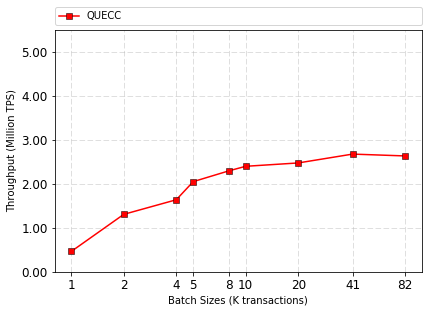

In [414]:
##QueCC Plots -- Batch size - Throughput - Batch size 
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean', 'trial_no':'count'}
agg_req = agg_req_normal
us = 1000000
q_pipelined = False
pd.options.display.float_format = '{:,.2f}'.format
grp_indexes = ['cc_alg','zipf_theta','pt_perc','batch_size','worker_cnt']
# cores = 32
cores = 64
figoutdir = '/Users/qadahtm/Google Drive/MBP2/PhDResearch/QueCC/paper_figs/'
outfname = '{}ycsb-bsizevar-theta0-o3je-GS32.pdf'.format(figoutdir)
# outfname = '{}ycsb-bsizevar-thetapt8-GS32.pdf'.format(figoutdir)


# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_bsize_M64"
# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0pt99_bsize_M64"
# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0pt90_bsize_M64"
# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0pt90_bsize_M64"

# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0pt90_bsize_GS32"
# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_bsize_GS32"
# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_bsize_quecc_GS32"
# ycsb_quecc_bsize_M64_o3je = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0_bsizevar_o3je_quecc_GS32"
ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0_bsizevar_quecc_GS32"
ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/nov_exps/ycsb_final_theta0_bsizevar_quecc_GS32"


ycsb_quecc_bsize_M64 = pd.DataFrame(parse_directory(ycsb_quecc_bsize_M64));
# ycsb_quecc_bsize_M64_o3je = pd.DataFrame(parse_directory(ycsb_quecc_bsize_M64_o3je));
# ycsb_quecc_bsize_M64_o3je['cc_alg'] = 'QUECC-JEO3'
# ycsb_quecc_bsize_M64 = pd.concat([ycsb_quecc_bsize_M64,ycsb_quecc_bsize_M64_o3je]);
# ycsb_quecc_bsize_M64 =  ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['batch_size'] > 6000]
ycsb_quecc_bsize_M64 =  ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['tput'] != 0]
ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.00']
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.80']
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.99']
ycsb_quecc_unpip_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['pt_perc'] == 100]
# ycsb_quecc_unpip_M64 = ycsb_quecc_unpip_M64[ycsb_quecc_unpip_M64['zipf_theta'] != '0.60']
# ycsb_quecc_unpip_M64 = ycsb_quecc_unpip_M64[ycsb_quecc_unpip_M64['zipf_theta'] == '0.99']
# del ycsb_quecc_unpip_M64['commit_strategy']
ycsb_quecc_unpip_M64['vm'] = cores

# ycsb_quecc_pip_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['pt_perc'] != 100]
# ycsb_quecc_pip_M64['vm'] = cores
# ycsb_quecc_pip_M64['worker_cnt'] = ycsb_quecc_pip_M64['et_cnt']+ycsb_quecc_pip_M64['pt_cnt']

# combined = pd.concat([ycsb_quecc_unpip_GS32,ycsb_quecc_pip_GS32])
# combined = pd.concat([ycsb_quecc_pip_GS32])
# print(combined)
# combined = pd.concat([ycsb_quecc_unpip_M64,ycsb_quecc_pip_M64])
combined = ycsb_quecc_unpip_M64;
# combined = pd.concat([ycsb_quecc_unpip_M64,ycsb_quecc_pip_M64, ycsb_quecc_pip_GS32, ycsb_quecc_unpip_GS32])
# combined = ycsb_quecc_unpip_M64

grouped_f = combined.groupby(grp_indexes).agg(agg_req)

ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]
# plt.figure(figsize=(32,6.2))
# plt.figure(figsize=(16,10))
plt.figure()
plt.rc('grid', linestyle="--",alpha=0.5)
plt.grid(True)


algs = list(grouped_f.index.levels[0])
# print(grouped_f.index)
# grouped_f.reindex(['GS32', 'M64', 'M128'])
ztheta = list(grouped_f.index.levels[1])
pt_ratio = list(grouped_f.index.levels[2])
vm_cnt = list(grouped_f.index.levels[0])
# print(ztheta)
pc =0
# print(algs)
# print(ztheta)
doplot = True
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
for ptr in pt_ratio:
    for t in ztheta:
        doplot = False        
        for a in algs:
#             ll = 'PT-{}%'.format(ptr)
            ll = a
    #         print(grouped_f.loc[a,t].index.get_level_values(0))
            print(ll)
            print(t)
            line_labels.append(ll)
            yvals = list(grouped_f.loc[a,t,ptr]['tput'])
            yvals_s = list( map(lambda x : x/us, yvals))
            xvals = list(grouped_f.loc[a,t,ptr].index.get_level_values(0))
            xvals = list( map(lambda x : int(x/1000), xvals))
#             xvals = list( map(lambda x : int(x/10000)*10 if x > 6000 else int(x/1000), xvals))
#             print(yvals)
            print(xvals)
            line_yvals.append(yvals_s)
            line_xvals.append(xvals)
            line_theta.append(t)

doplot = True

# if doplot:
# pc = pc + 1
plti = 110 + pc
# print(plti)
#     print(len(line_yvals))
title_y_offset = -0.2
# plt.xticks(line_xvals[0],line_xvals[0], fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,5.5)
# plt.xlim([1,180])

ax = plt.subplot(111)
for i in range(len(line_labels)):
#     ls_tmp = ls[i]
#     print(i)
#     ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
    ls_tmp = ls_dict[line_labels[i]]
    ax.plot(line_xvals[i],line_yvals[i], marker=ls_tmp['marker'], linestyle=ls_tmp['linestyle'], color=ls_tmp['color'], markeredgewidth=0.5,markeredgecolor='black', label=line_labels[i])
    ax.set_xscale('log', basex=2)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%dK'))
    ax.set_ylabel('Throughput (Million TPS)')
    # ax.set_xlabel('Zipfian Theta')
    ax.set_xlabel('Batch Sizes (K transactions)')
plt.xticks(line_xvals[0],line_xvals[0], fontsize=12)
#3 plots            
# plt.legend(bbox_to_anchor=(-2.8, 1.02, 3.8, .102), 
#            loc=8,ncol=8, mode="expand", borderaxespad=0.)
# 2 plots
# plt.legend(bbox_to_anchor=(-1.4, 1.02, 2.4, .102), 
#            loc=8,ncol=8, mode="expand", borderaxespad=0.)

plt.legend(bbox_to_anchor=(0, 1.02, 1.0, .102), 
           loc=8,ncol=8, mode="expand", borderaxespad=0.)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.savefig(outfname,format='pdf')
grouped_f
# grouped_f.loc['QUECC','0.99','100']

['QUECC-AVG-Lat', "QUECC-Lat99'tile"]
[[1, 2, 4, 5, 8, 10, 20, 40, 80], [1, 2, 4, 5, 8, 10, 20, 40, 80], [1, 2, 4, 5, 8, 10, 20, 40, 80]]
[[0.41100000000000003, 0.68800000000000006, 1.2329999999999999, 1.694, 2.3420000000000001, 2.8649999999999998, 5.9750000000000005, 11.332000000000001, 21.788999999999998], [2.109, 5.1019999999999994, 5.758, 7.0759999999999996, 8.1609999999999996, 8.6840000000000011, 16.242000000000001, 24.023, 43.268000000000001], [1.0113365312939999, 1.532211199617, 2.0698645771059998, 2.017607564645, 2.4926740192249999, 2.5989118411629999, 2.635353738979, 2.8380658528649998, 2.9950129281879998]]


tput  phys_mem_usage  \
cc_alg zipf_theta pt_perc batch_size worker_cnt                                
QUECC  0.00       100     1024       32         1,011,336.53        12795716   
                          2048       32         1,532,211.20        15424612   
                          4096       32         2,069,864.58        14804708   
                          5184       32         2,017,607.56        15719544   
                          8192       32         2,492,674.02        21388260   
                          10368      32         2,598,911.84        21712656   
                          20736      32         2,635,353.74        22701108   
                          41472      32         2,838,065.85        23803524   
                          82944      32         2,995,012.93        29631268   

                                                 trial_no  fscl_avg  fscl99  
cc_alg zipf_theta pt_perc batch_size worker_cnt                              
QUECC  0.00       100     1024       32                 1      0.00    0.00  
                          2048       32                 1      0.00    0.01  
                          4096       32                 1      0.00    0.01  
                          5184       32                 1      0.00    0.01  
                          8192       32                 1      0.00    0.01  
                          10368      32                 1      0.00    0.01  
                          20736      32                 1      0.01    0.02  
                          41472      32                 1      0.01    0.02  
                          82944      32                 1      0.02    0.04

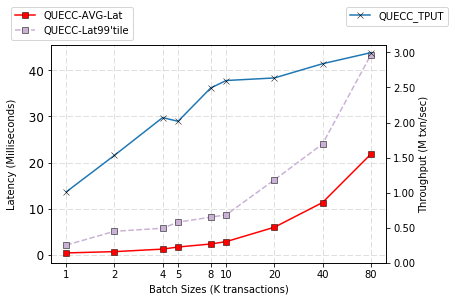

In [413]:
##QueCC Plots -- Batch size - Latency
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean', 'trial_no':'count','fscl_avg':'mean', 'fscl99':'mean'}

agg_req = agg_req_normal
us = 1000000
q_pipelined = False
pd.options.display.float_format = '{:,.2f}'.format
grp_indexes = ['cc_alg','zipf_theta','pt_perc','batch_size','worker_cnt']
figoutdir = '/Users/qadahtm/Google Drive/MBP2/PhDResearch/QueCC/paper_figs/'
# outfname = '{}ycsb-bsize-lat-thetapt99-M64.pdf'.format(figoutdir)
# outfname = '{}ycsb-bsizevar-lat-theta0-GS32.pdf'.format(figoutdir)
outfname = '{}ycsb-bsizevar-lat-thetapt0_o3je-GS32.pdf'.format(figoutdir)
cores = 64
# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0pt99_bsize_lat_M64"
# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0pt99_bsize_lat_GS32"
# ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0pt8_bsize_lat_quecc_GS32"
ycsb_quecc_bsize_M64 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_final_theta0_bsizevar_lat_o3je_quecc_GS32"


ycsb_quecc_bsize_M64 = pd.DataFrame(parse_directory(ycsb_quecc_bsize_M64));
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['batch_size'] > 6000]
ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['tput'] != 0]
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.99']
# ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.80']
ycsb_quecc_bsize_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['zipf_theta'] == '0.00']
# ycsb_quecc_unpip_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['pt_perc'] == 100]
# ycsb_quecc_unpip_M64 = ycsb_quecc_unpip_M64[ycsb_quecc_unpip_M64['zipf_theta'] != '0.60']
# ycsb_quecc_unpip_M64 = ycsb_quecc_unpip_M64[ycsb_quecc_unpip_M64['zipf_theta'] == '0.99']
# ycsb_quecc_unpip_M64 = ycsb_quecc_unpip_M64[ycsb_quecc_unpip_M64['zipf_theta'] == '0.00']
# del ycsb_quecc_unpip_M64['commit_strategy']
# ycsb_quecc_unpip_M64['vm'] = cores

# ycsb_quecc_pip_M64 = ycsb_quecc_bsize_M64[ycsb_quecc_bsize_M64['pt_perc'] != 100]
# ycsb_quecc_pip_M64 = ycsb_quecc_pip_M64[ycsb_quecc_pip_M64['zipf_theta'] == '0.00']
# ycsb_quecc_pip_M64['vm'] = cores
# ycsb_quecc_pip_M64['worker_cnt'] = ycsb_quecc_pip_M64['et_cnt']+ycsb_quecc_pip_M64['pt_cnt']

# combined = pd.concat([ycsb_quecc_unpip_GS32,ycsb_quecc_pip_GS32])
# combined = pd.concat([ycsb_quecc_pip_GS32])
# print(combined)
# combined = pd.concat([ycsb_quecc_unpip_M64,ycsb_quecc_pip_M64])
# combined = pd.concat([ycsb_quecc_unpip_M64,ycsb_quecc_pip_M64, ycsb_quecc_pip_GS32, ycsb_quecc_unpip_GS32])
combined = ycsb_quecc_bsize_M64

grouped_f = combined.groupby(grp_indexes).agg(agg_req)

# ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]
# ls = ['b^-', 'bs--', 'gx-', 'g*--', 'yo-', 'y+--', 'cD-', 'cd--' ]
# plt.figure(figsize=(32,6.2))
# plt.figure(figsize=(16,10))
plt.figure()
plt.rc('grid', linestyle="--",alpha=0.5)
plt.grid(True)

algs = list(grouped_f.index.levels[0])
# print(grouped_f.index)
# grouped_f.reindex(['GS32', 'M64', 'M128'])
ztheta = list(grouped_f.index.levels[1])
pt_ratio = list(grouped_f.index.levels[2])
vm_cnt = list(grouped_f.index.levels[0])
# print(ztheta)
pc =0
# print(algs)
# print(ztheta)
doplot = True
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
line2_yvals = []
line2_xvals = []
lat_lines = ['fscl_avg', 'fscl99', 'tput']
# lat_lines = ['fscl_avg']
for ptr in pt_ratio:
    for t in ztheta:
        doplot = False        
        for a in algs:
            for latv in lat_lines:
                if latv == 'fscl_avg':
#                     ll = 'PT-{}%-AVG'.format(ptr)
#                     ll = 'PT-{}%'.format(ptr)
                    ll = '{}-AVG-Lat'.format(a)
                else:
                    m = re.search('fscl(\d+)', latv)
                    if m:
                        ll = '{}-Lat{}\'tile'.format(a,m.group(1))
                    else:
                        ll = 'PT-{}%'.format(ptr)

        #         print(grouped_f.loc[a,t].index.get_level_values(0))
    #             print(ll)
    #             print(t)
                if latv != 'tput':
                    line_labels.append(ll)
                    yvals = list(grouped_f.loc[a,t,ptr][latv])
                    yvals_s = list( map(lambda x : x*1000, yvals))
                    xvals = list(grouped_f.loc[a,t,ptr].index.get_level_values(0))
    #                 xvals = list( map(lambda x : x/1000, xvals))
                    xvals = list( map(lambda x : int(x/10000)*10 if x >= 10000 else int(x/1000), xvals))
        #             print(yvals)
        #             print(xvals)
                    line_yvals.append(yvals_s)
                    line_xvals.append(xvals)
                    line_theta.append(t)
                else:
                    yvals = list(grouped_f.loc[a,t,ptr]['tput'])
                    yvals_s = list( map(lambda x : x/us, yvals))
                    line_yvals.append(yvals_s)
                    line_xvals.append(xvals)
doplot = True

# if doplot:
# pc = pc + 1
plti = 110 + pc
# print(plti)
#     print(len(line_yvals))
title_y_offset = -0.2
plt.yticks(fontsize=12)
ax = plt.subplot(111)
#         ax = plt.subplot() # single plot
#         if t == 32:
#             ax.set_title("(a) G5 (32 CPUs)", y=title_y_offset)
#         elif t == 64:
#             ax.set_title("(b) M64 (64 vCPUs)".format(t), y=title_y_offset)
#         else:
#             ax.set_title("(c) M128 (128 vCPUs)".format(t), y=title_y_offset)

#             if t == '0.00':
#                 ax.set_title("(a) theta = 0.0 (Uniform)", y=title_y_offset)
#             elif t == '0.60':
#                 ax.set_title("(b) theta = 0.6".format(t), y=title_y_offset)
#             else:
#                 ax.set_title("(c) theta = 0.99".format(t), y=title_y_offset)
for i in range(len(line_labels)):
#     ls_tmp = ls[i]
#     print(i)
#     ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
    if line_labels[i] != 'QUECC_TPUT':
        ls_tmp = ls_dict[line_labels[i]]
        ax.plot(line_xvals[i],line_yvals[i], marker=ls_tmp['marker'], linestyle=ls_tmp['linestyle'], color=ls_tmp['color'], markeredgewidth=0.5,markeredgecolor='black', label=line_labels[i])
        ax.set_xscale('log', basex=2)
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.f'))
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%dK'))
        ax.set_ylabel('Latency (Milliseconds)')
        ax.set_xlabel('Batch Sizes (K transactions)')

ax2 = ax.twinx()
ax2.set_ylim(0,3.1)
ls_tmp = ls_dict['OCC']
ax2.plot(line_xvals[2],line_yvals[2], marker=ls_tmp['marker'], linestyle=ls_tmp['linestyle'], color=ls_tmp['color'], markeredgewidth=0.5,markeredgecolor='black', label='QUECC_TPUT')
ax2.set_xscale('log', basex=2)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%dK'))
ax2.set_ylabel('Throughput (M txn/sec)')   

print(line_labels)
print(line_xvals)
print(line_yvals)

plt.xticks(line_xvals[0],line_xvals[0], fontsize=12)
#3 plots            
# plt.legend(bbox_to_anchor=(-2.8, 1.02, 3.8, .102), 
#            loc=8,ncol=8, mode="expand", borderaxespad=0.)
# 2 plots
# plt.legend(bbox_to_anchor=(-1.4, 1.02, 2.4, .102), 
#            loc=8,ncol=8, mode="expand", borderaxespad=0.)

# plt.legend(bbox_to_anchor=(0, 1.02, 1.0, .102), 
#            loc=8,ncol=2, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)
ax2.legend(bbox_to_anchor=(1.2, 1.2))
ax.legend(bbox_to_anchor=(0.26, 1.2))
plt.savefig(outfname,format='pdf')
grouped_f
# grouped_f.loc['QUECC','0.99','100']

In [549]:
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean','trial_no':'count'}
agg_req = agg_req_normal
us = 1000000

plot_vm = 32

file_paths = ["/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_all_M64",
              "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_set1_GS32",
#               "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0_GS32",
             ]

qfile_paths = [#"/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_pip_quecc_M64",
              "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_thetapt99_pip_quecc_GS32"
             ]

cfile_paths = [
              "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0pt99_calvin_GS32",
              "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_ppt50_wp50_theta0pt99_calvin_M64"
             ]

for i, fp in enumerate(file_paths):
    if i == 0:
        df_ycsb = pd.DataFrame(parse_directory(fp));
    else:
        df_ycsb = pd.concat([df_ycsb,pd.DataFrame(parse_directory(fp))]) 

df_ycsb =  df_ycsb[df_ycsb['tput'] != 0]
df_ycsb =  df_ycsb[df_ycsb['cc_alg'] != 'CALVIN']
df_ycsb =  df_ycsb[df_ycsb['zipf_theta'] == '0.99']
df_ycsb =  df_ycsb[df_ycsb['vm'] == plot_vm]

for i, fp in enumerate(qfile_paths):
    if i == 0:
        df_ycsb_quecc = pd.DataFrame(parse_directory(fp));
    else:
        df_ycsb_quecc = pd.concat([df_ycsb_quecc,pd.DataFrame(parse_directory(fp))]) 

df_ycsb_quecc =  df_ycsb_quecc[df_ycsb_quecc['tput'] != 0]
df_ycsb_quecc =  df_ycsb_quecc[df_ycsb_quecc['zipf_theta'] == '0.99']

for i, fp in enumerate(cfile_paths):
    if i == 0:
        df_ycsb_calvin = pd.DataFrame(parse_directory(fp));
    else:
        df_ycsb_calvin = pd.concat([df_ycsb_calvin,pd.DataFrame(parse_directory(fp))]) 
        
df_ycsb_calvin =  df_ycsb_calvin[df_ycsb_calvin['tput'] != 0]
df_ycsb_calvin =  df_ycsb_calvin[df_ycsb_calvin['zipf_theta'] == '0.99']
df_ycsb_calvin =  df_ycsb_calvin[df_ycsb_calvin['vm'] == plot_vm]
        
df_ycsb_quecc = df_ycsb_quecc[df_ycsb_quecc['pt_perc'] == 50]
df_ycsb_quecc['worker_cnt'] = df_ycsb_quecc['et_cnt']+df_ycsb_quecc['pt_cnt']
# combined = pd.concat([df_ycsb[(df_ycsb['cc_alg'] != 'CALVIN')],df_ycsb_quecc, df_ycsb_calvin])
combined = pd.concat([df_ycsb[(df_ycsb['cc_alg'] != 'CALVIN')], df_ycsb_calvin])
# combined = pd.concat([df_ycsb[(df_ycsb['cc_alg'] != 'CALVIN')],df_ycsb_quecc])
grpby_params = ['cc_alg','vm','worker_cnt','pt_perc']
grouped_f = combined.groupby(grpby_params).agg(agg_req)


pd.options.display.float_format = '{:,.2f}'.format

ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]
plt.figure(figsize=(32,6.2))

algs = list(grouped_f.index.levels[0])
# print(grouped_f.index)
# grouped_f.reindex(['GS32', 'M64', 'M128'])
# vms = list()
vms = [32]
print(vms)
ztheta = list(grouped_f.index.levels[1])
print(ztheta)
pc =0
# print(algs)
# print(ztheta)
doplot = True
for t in ztheta:
    doplot = False
    line_labels = []
    line_yvals = []
    line_xvals = []
    line_theta = []
    for a in algs:
        ll = '{}-{}-{}'.format(a,t,v)
#             ll = a
        print(ll)
        print(t)
        line_labels.append(ll)
        yvals = list(grouped_f.loc[a,t]['tput'])
        yvals_s = list( map(lambda x : x/us, yvals))
        xvals = list(grouped_f.loc[a,t].index.get_level_values(0))
#         print(yvals)
#         print(xvals)
        line_yvals.append(yvals_s)
        line_xvals.append(xvals)
        line_theta.append(t)

    doplot = True

    if doplot:
        pc = pc + 1
        plti = 120 + pc
        print(plti)
    #     print(len(line_yvals))
        title_y_offset = -0.2
        ax = plt.subplot(plti)
#         ax = plt.subplot() # single plot
        if t == 32:
            ax.set_title("(a) G5 (32 CPUs)", y=title_y_offset)
        elif t == 64:
            ax.set_title("(b) M64 (64 vCPUs)".format(t), y=title_y_offset)
        else:
            ax.set_title("(c) M128 (128 vCPUs)".format(t), y=title_y_offset)
        for i in range(len(line_yvals)):
            ls_tmp = ls[i]

            ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
            ax.set_ylabel('Throughput (Million TPS)')
            # ax.set_xlabel('Zipfian Theta')
            ax.set_xlabel('Number of Worker Threads')
#3 plots            
# plt.legend(bbox_to_anchor=(-2.8, 1.02, 3.8, .102), 
#            loc=8,ncol=8, mode="expand", borderaxespad=0.)
# 2 plots
# plt.legend(bbox_to_anchor=(-1.4, 1.02, 2.4, .102), 
#            loc=8,ncol=9, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)
#single plot
plt.legend(bbox_to_anchor=(0, 1.02, 1.0, .102), 
           loc=8,ncol=9, mode="expand", borderaxespad=0.)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

# grouped_f[grouped_f['cc_alg'] == 'QUECC']
# df_ycsb_calvin.groupby(['cc_alg','vm','worker_cnt','pt_perc']).agg(agg_req)
grouped_f

pa16_40320_pt32_et32_100_pptstrict_CALVIN_s_t0_88_64.txt
pa16_40320_pt32_et32_100_pptstrict_CALVIN_s_t1_89_64.txt
pa16_40320_pt32_et32_100_pptstrict_MVCC_s_t1_77_64.txt
pa16_40320_pt32_et32_100_pptstrict_OCC_s_t1_5_64.txt
pa16_40320_pt32_et32_100_pptstrict_SILO_s_t1_53_64.txt
pa16_40320_pt32_et32_100_pptstrict_TIMESTAMP_s_t0_28_64.txt
pa24_40320_pt48_et48_100_pptstrict_CALVIN_s_t0_90_64.txt
pa24_40320_pt48_et48_100_pptstrict_CALVIN_s_t1_91_64.txt
pa28_40320_pt56_et56_100_pptstrict_CALVIN_s_t0_92_64.txt
pa28_40320_pt56_et56_100_pptstrict_CALVIN_s_t1_93_64.txt
pa28_40320_pt56_et56_100_pptstrict_OCC_s_t1_9_64.txt
pa28_40320_pt56_et56_100_pptstrict_WAITDIE_s_t0_68_64.txt
pa32_40320_pt64_et64_100_pptstrict_CALVIN_s_t0_94_64.txt
pa32_40320_pt64_et64_100_pptstrict_CALVIN_s_t1_95_64.txt
pa32_40320_pt64_et64_100_pptstrict_HSTORE_s_t1_47_64.txt
pa32_40320_pt64_et64_100_pptstrict_SILO_s_t0_58_64.txt
pa32_40320_pt64_et64_100_pptstrict_SILO_s_t1_59_64.txt
pa4_40320_pt8_et8_100_pptstrict_CALVIN_s_t0

ValueError: arrays must all be same length

In [459]:
pt_cnt = [8,16,24,32,48,64]
m = [1,2,4,8,16]

for i in m:
    print(27*192*i)

5184
10368
20736
41472
82944


In [429]:
(2**24)/192

87381.33333333333

In [433]:
(192*87381)/40320

416.1

In [446]:

rss = [1,5,10]
for rs in rss:
    ycsb_schema = "//size, type, name\nTABLE=MAIN_TABLE\n"
    for i in range(rs):
        ycsb_schema += "\t{},string,F{}\n".format(100,i)
    ycsb_schema += "\nINDEX=MAIN_INDEX\n"
    ycsb_schema += "\tMAIN_TABLE,0\n"
    print(ycsb_schema)

//size, type, name
TABLE=MAIN_TABLE
	100,string,F0

INDEX=MAIN_INDEX
	MAIN_TABLE,0

//size, type, name
TABLE=MAIN_TABLE
	100,string,F0
	100,string,F1
	100,string,F2
	100,string,F3
	100,string,F4

INDEX=MAIN_INDEX
	MAIN_TABLE,0

//size, type, name
TABLE=MAIN_TABLE
	100,string,F0
	100,string,F1
	100,string,F2
	100,string,F3
	100,string,F4
	100,string,F5
	100,string,F6
	100,string,F7
	100,string,F8
	100,string,F9

INDEX=MAIN_INDEX
	MAIN_TABLE,0



In [98]:
test_data = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test_copying.txt'
df = pd.DataFrame(exetract_breakdown_from_file(test_data))
df

,exec_batch_cnt,exec_batch_part_cnt,exec_batch_part_proc_time,exec_batch_proc_time,exec_entry_deq_time,exec_eq_swtich_time,exec_idle_time,exec_mem_free_time,exec_resp_msg_create_time,exec_txn_cnt,...,plan_txn_cnt,plan_txn_proc_time,tput,wt_hl_cleanup_time,wt_hl_commit_time,wt_hl_exec_time,wt_hl_plan_time,wt_hl_sync_commit_time,wt_hl_sync_exec_time,wt_hl_sync_plan_time
0,299.00,"5,980.00",0.00,57.31,0.00,0.00,119.78,0.02,0.00,"4,759,856.00",...,0.00,4.94,"200,962.75",0.12,30.93,14.17,6.09,0.18,4.88,1.13
1,299.00,"5,980.00",0.00,59.82,0.00,0.00,119.78,0.02,0.00,"2,451,988.00",...,0.00,4.93,"200,962.75",0.12,30.95,16.72,6.08,0.17,2.32,3.66
2,299.00,"5,980.00",0.00,59.82,0.00,0.00,119.78,0.02,0.00,"1,416,030.00",...,0.00,4.94,"200,962.75",0.12,30.99,16.72,6.12,0.12,2.32,3.62
3,299.00,"5,980.00",0.00,59.82,0.00,0.00,119.78,0.02,0.00,"1,137,355.00",...,0.00,4.80,"200,962.75",0.12,30.71,16.70,5.95,0.40,2.34,3.78
4,299.00,"5,980.00",0.00,59.82,0.00,0.00,119.77,0.02,0.00,"648,301.00",...,0.00,4.89,"200,962.75",0.12,30.02,16.62,6.02,1.09,2.42,3.72
5,299.00,"5,980.00",0.00,59.82,0.00,0.00,119.77,0.02,0.00,"1,036,068.00",...,0.00,4.94,"200,962.75",0.12,30.10,16.75,6.11,1.01,2.29,3.63
6,299.00,"5,980.00",0.00,59.82,0.00,0.00,119.77,0.02,0.00,"407,480.00",...,0.00,4.88,"200,962.75",0.12,30.17,16.65,6.04,0.94,2.39,3.70
7,299.00,"5,980.00",0.00,59.82,0.00,0.00,119.78,0.02,0.00,"263,997.00",...,0.00,4.98,"200,962.75",0.12,30.24,16.59,6.12,0.87,2.45,3.61
8,299.00,"5,980.00",0.00,59.82,0.00,0.00,119.77,0.02,0.00,"198,833.00",...,0.00,4.94,"200,962.75",0.12,30.33,16.55,6.08,0.78,2.49,3.66
9,299.00,"5,980.00",0.00,59.82,0.00,0.00,119.77,0.02,0.00,"218,633.00",...,0.00,4.85,"200,962.75",0.12,30.37,16.72,5.97,0.74,2.32,3.77


In [192]:
import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
locale.atoi('1,000,000')
directory = "/Users/qadahtm/Dev/halstead/mem_test_results"
directory = "/Users/qadahtm/Dev/halstead/mem_test_results_DS15"

files = os.listdir(directory)
data = {'core_cnt':[],
        'warmup':[],
        'rec_malloc':[],
        'rec_size':[],
        'dTLB-load-misses':[],
        'L1-dcache-load-misses':[],
        'LLC-load-misses':[],
        'wup_copying_ticks':[],
        'wup_time':[],
        'wup_avg_copy_ticks':[],
        'wup_total_copy_cnt':[],
        'wup_total_copy_ticks':[],
        'copying_ticks':[],
        'time':[],
        'avg_copy_ticks':[],
        'total_copy_cnt':[],
        'total_copy_ticks':[],
        'trial_no':[]
       }
fcount = 0
for f in files:
    m = re.search("(perfstat)?_?(\d+)cores_(nwup|wup)_(nrm|rm|nrum)_(\d+)Brec_t(\d+)\.txt", f)
#     print(f)
    if m:
        if m.group(1):
            #perfstat output file
#             print(m.group(1))
#             data['perfsat'].append(True);
            with open(directory+'/'+f, 'r') as of:
                for line in of:
                    re_exp = "\s*((\d+,\d+)|<not counted>)\s+dTLB-load-misses.+"
                    m2 = re.search(re_exp, line.strip())
                    if m2:
                        if (m2.group(1) == '<not counted>'):
#                             print(f)
                            data['dTLB-load-misses'].append(0)
                        else:
#                             print(line)
                            data['dTLB-load-misses'].append(locale.atoi(m2.group(1)))
    
                    re_exp = "\s*((\d+,\d+)|<not counted>)\s+LLC-load-misses.+"
                    m2 = re.search(re_exp, line.strip())
                    if m2:
                        if (m2.group(1) == '<not counted>'):
#                             print(f)
                            data['LLC-load-misses'].append(0)
                        else:
#                             print(line)
                            data['LLC-load-misses'].append(locale.atoi(m2.group(1)))
                    re_exp = "\s*((\d+,\d+)|<not counted>)\s+L1-dcache-load-misses.+"
                    m2 = re.search(re_exp, line.strip())
                    if m2:
                        if (m2.group(1) == '<not counted>'):
#                             print(f)
                            data['L1-dcache-load-misses'].append(0)
                        else:
#                             print(line)
                            data['L1-dcache-load-misses'].append(locale.atoi(m2.group(1))) 

        else:
            #output file
            data['core_cnt'].append(int(m.group(2)))
            is_warmup = m.group(3) == 'wup';
            data['warmup'].append(is_warmup)
            data['rec_malloc'].append(m.group(4) == 'rm')
            data['rec_size'].append(int(m.group(5)))
            data['trial_no'].append(int(m.group(6)))
            # do no wrmup
            with open(directory+'/'+f, 'r') as of:
                for line in of:
                    reexp = "(warmup)?\s*-?\s*copying_ticks\s+=\s+(\d+),\s+time=(\d+\.\d+),\s+avg_copy_ticks=(\d+),\s+total_copy_cnt=(\d+),\s+total_copy_ticks\s+=\s+(\d+)"
                    m2 = re.search(reexp, line.strip())
                    if m2:
                        fcount = fcount+1
#                         print(line.strip())
#                         print(m2.group(1))
                        if m2.group(1):                        
                            data['wup_copying_ticks'].append(int(m2.group(2)))
                            data['wup_time'].append(float(m2.group(3)))
                            data['wup_avg_copy_ticks'].append(int(m2.group(4)))
                            data['wup_total_copy_cnt'].append(int(m2.group(5)))
                            data['wup_total_copy_ticks'].append(int(m2.group(6))) 
                        else:
                            data['copying_ticks'].append(int(m2.group(2)))
                            data['time'].append(float(m2.group(3)))
                            data['avg_copy_ticks'].append(int(m2.group(4)))
                            data['total_copy_cnt'].append(int(m2.group(5)))
                            data['total_copy_ticks'].append(int(m2.group(6)))
#                     else:
#                         print(f)
            if not is_warmup:
                data['wup_copying_ticks'].append(0)
                data['wup_time'].append(float(0))
                data['wup_avg_copy_ticks'].append(0)
                data['wup_total_copy_cnt'].append(0)
                data['wup_total_copy_ticks'].append(0) 
                
            data['L1-dcache-load-misses'].append(0)
            data['LLC-load-misses'].append(0)
            data['dTLB-load-misses'].append(0)
                            
print(fcount)
mem_df = pd.DataFrame(data)
# mem_df = mem_df[mem_df['rec_malloc'] == False]
mem_df = mem_df[mem_df['warmup'] == False]
# mem_df = mem_df[mem_df['warmup'] == False]
# mem_df = mem_df[mem_df['core_cnt'] == 10]
# mem_df = mem_df[mem_df['dTLB-load-misses'] != 0]
agg_par ={'avg_copy_ticks':'mean'};

groupby_mem_df = mem_df.groupby(['rec_size']).agg(agg_par)
groupby_mem_df
# mem_df

42


,avg_copy_ticks
rec_size,
20,57.50
100,211.00
512,736.00
1024,"1,754.50"
2048,"3,081.50"
4096,"6,371.50"
8192,"13,274.50"


In [202]:
 test_out = ['rec_size=20,copying_ticks=14653102,time=0.006105,avg_copy_ticks=13,avg_copy_time(ns)=5.822620,total_copy_cnt=1048576',
'rec_size=100,copying_ticks=13968640,time=0.005820,avg_copy_ticks=13,avg_copy_time(ns)=5.550639,total_copy_cnt=1048576',
'rec_size=512,copying_ticks=29327892,time=0.012220,avg_copy_ticks=27,avg_copy_time(ns)=11.653857,total_copy_cnt=1048576',
'rec_size=1024,copying_ticks=45474532,time=0.018948,avg_copy_ticks=43,avg_copy_time(ns)=18.069956,total_copy_cnt=1048576',
'rec_size=2048,copying_ticks=193783988,time=0.080743,avg_copy_ticks=184,avg_copy_time(ns)=77.002838,total_copy_cnt=1048576',
'rec_size=4096,copying_ticks=1251082995,time=0.521285,avg_copy_ticks=1193,avg_copy_time(ns)=497.135717,total_copy_cnt=1048576',
'rec_size=8192,copying_ticks=1990899255,time=0.829541,avg_copy_ticks=1898,avg_copy_time(ns)=791.112286,total_copy_cnt=1048576']
    
data = {
    'rec_size':[],
    'avg_copy_time':[]
}
for line in test_out:
#     print(line)
    m = re.search('rec_size=(\d+),copying_ticks=(\d+),time=(\d+\.\d+),avg_copy_ticks=(\d+),avg_copy_time\(ns\)=(\d+\.\d+),total_copy_cnt=(\d+)', line.strip())
    if m:
        data['rec_size'].append(int(m.group(1)))
        data['avg_copy_time'].append(float(m.group(5)))
        
df = pd.DataFrame(data);
df[['rec_size','avg_copy_time']]

,rec_size,avg_copy_time
0,20,5.82
1,100,5.55
2,512,11.65
3,1024,18.07
4,2048,77.00
5,4096,497.14
6,8192,791.11


In [ ]:
['rec_cnt=1,copying_ticks=1170864748,time=0.487860,avg_copy_ticks=1116,avg_copy_time(ns)=465.259849,total_copy_cnt=1048576',
'rec_cnt=10,copying_ticks=9596327168,time=3.998470,avg_copy_ticks=915,avg_copy_time(ns)=381.323781,total_copy_cnt=10485760',
'rec_cnt=50,copying_ticks=34688599279,time=14.453583,avg_copy_ticks=661,avg_copy_time(ns)=275.680218,total_copy_cnt=52428800',
'rec_cnt=100,copying_ticks=84559842184,time=35.233268,avg_copy_ticks=806,avg_copy_time(ns)=336.010624,total_copy_cnt=104857600']

['rec_cnt=1,copying_ticks=1268107758,time=0.528378,avg_copy_ticks=1209,avg_copy_time(ns)=503.900750,total_copy_cnt=1048576',
'rec_cnt=10,copying_ticks=9524312711,time=3.968464,avg_copy_ticks=908,avg_copy_time(ns)=378.462184,total_copy_cnt=10485760',
'rec_cnt=50,copying_ticks=35826136174,time=14.927557,avg_copy_ticks=683,avg_copy_time(ns)=284.720549,total_copy_cnt=52428800',
'rec_cnt=100,copying_ticks=83814780018,time=34.922825,avg_copy_ticks=799,avg_copy_time(ns)=333.050013,total_copy_cnt=104857600']

,avg_copy_time(ns)
working_set_size,
4.00,477.63
40.00,357.77
400.00,505.57
"4,000.00",354.44
"8,000.00",343.08
"16,000.00",673.01
"20,000.00",976.02
"24,000.00","1,078.43"
"28,000.00","1,100.63"


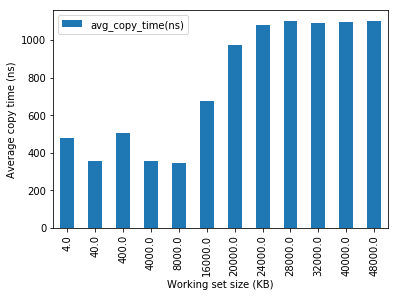

In [252]:
import matplotlib.ticker as ticker  
data_lines = ['rec_cnt=1,copying_ticks=1553080,time=0.000647,avg_copy_ticks=1516,avg_copy_time(ns)=631.949870,total_copy_cnt=1024',
'rec_cnt=10,copying_ticks=9301275,time=0.003876,avg_copy_ticks=908,avg_copy_time(ns)=378.469849,total_copy_cnt=10240',
'rec_cnt=100,copying_ticks=127846605,time=0.053269,avg_copy_ticks=1248,avg_copy_time(ns)=520.209167,total_copy_cnt=102400',
'rec_cnt=1000,copying_ticks=847274880,time=0.353031,avg_copy_ticks=827,avg_copy_time(ns)=344.757031,total_copy_cnt=1024000',
'rec_cnt=2000,copying_ticks=1745370971,time=0.727238,avg_copy_ticks=852,avg_copy_time(ns)=355.096633,total_copy_cnt=2048000',
'rec_cnt=4000,copying_ticks=6707359252,time=2.794733,avg_copy_ticks=1637,avg_copy_time(ns)=682.307867,total_copy_cnt=4096000',
'rec_cnt=5000,copying_ticks=11793020615,time=4.913759,avg_copy_ticks=2303,avg_copy_time(ns)=959.718475,total_copy_cnt=5120000',
'rec_cnt=6000,copying_ticks=15996888215,time=6.665370,avg_copy_ticks=2603,avg_copy_time(ns)=1084.858413,total_copy_cnt=6144000',
'rec_cnt=7000,copying_ticks=19060506178,time=7.941878,avg_copy_ticks=2659,avg_copy_time(ns)=1107.962831,total_copy_cnt=7168000',
'rec_cnt=8000,copying_ticks=21475100589,time=8.947959,avg_copy_ticks=2621,avg_copy_time(ns)=1092.280100,total_copy_cnt=8192000',
'rec_cnt=10000,copying_ticks=27059990173,time=11.274996,avg_copy_ticks=2642,avg_copy_time(ns)=1101.073819,total_copy_cnt=10240000',
'rec_cnt=12000,copying_ticks=32765831992,time=13.652430,avg_copy_ticks=2666,avg_copy_time(ns)=1111.037597,total_copy_cnt=12288000',
'rec_cnt=1,copying_ticks=927333,time=0.000386,avg_copy_ticks=905,avg_copy_time(ns)=377.332764,total_copy_cnt=1024',
'rec_cnt=10,copying_ticks=8489494,time=0.003537,avg_copy_ticks=829,avg_copy_time(ns)=345.438395,total_copy_cnt=10240',
'rec_cnt=100,copying_ticks=112206411,time=0.046753,avg_copy_ticks=1095,avg_copy_time(ns)=456.569055,total_copy_cnt=102400',
'rec_cnt=1000,copying_ticks=827637642,time=0.344849,avg_copy_ticks=808,avg_copy_time(ns)=336.766619,total_copy_cnt=1024000',
'rec_cnt=2000,copying_ticks=1614659507,time=0.672775,avg_copy_ticks=788,avg_copy_time(ns)=328.503318,total_copy_cnt=2048000',
'rec_cnt=4000,copying_ticks=6357585649,time=2.648994,avg_copy_ticks=1552,avg_copy_time(ns)=646.727056,total_copy_cnt=4096000',
'rec_cnt=5000,copying_ticks=11958322108,time=4.982634,avg_copy_ticks=2335,avg_copy_time(ns)=973.170744,total_copy_cnt=5120000',
'rec_cnt=6000,copying_ticks=15812399459,time=6.588500,avg_copy_ticks=2573,avg_copy_time(ns)=1072.346969,total_copy_cnt=6144000',
'rec_cnt=7000,copying_ticks=18795729298,time=7.831554,avg_copy_ticks=2622,avg_copy_time(ns)=1092.571690,total_copy_cnt=7168000',
'rec_cnt=8000,copying_ticks=21278297223,time=8.865957,avg_copy_ticks=2597,avg_copy_time(ns)=1082.270163,total_copy_cnt=8192000',
'rec_cnt=10000,copying_ticks=26861932232,time=11.192472,avg_copy_ticks=2623,avg_copy_time(ns)=1093.014821,total_copy_cnt=10240000',
'rec_cnt=12000,copying_ticks=32589764206,time=13.579068,avg_copy_ticks=2652,avg_copy_time(ns)=1105.067417,total_copy_cnt=12288000',
'rec_cnt=1,copying_ticks=1041072,time=0.000434,avg_copy_ticks=1016,avg_copy_time(ns)=423.613281,total_copy_cnt=1024',
'rec_cnt=10,copying_ticks=8586882,time=0.003578,avg_copy_ticks=838,avg_copy_time(ns)=349.401123,total_copy_cnt=10240',
'rec_cnt=100,copying_ticks=132695593,time=0.055290,avg_copy_ticks=1295,avg_copy_time(ns)=539.939750,total_copy_cnt=102400',
'rec_cnt=1000,copying_ticks=938330153,time=0.390971,avg_copy_ticks=916,avg_copy_time(ns)=381.807517,total_copy_cnt=1024000',
'rec_cnt=2000,copying_ticks=1698881109,time=0.707867,avg_copy_ticks=829,avg_copy_time(ns)=345.638246,total_copy_cnt=2048000',
'rec_cnt=4000,copying_ticks=6783066985,time=2.826278,avg_copy_ticks=1656,avg_copy_time(ns)=690.009255,total_copy_cnt=4096000',
'rec_cnt=5000,copying_ticks=12228834643,time=5.095348,avg_copy_ticks=2388,avg_copy_time(ns)=995.185111,total_copy_cnt=5120000',
'rec_cnt=6000,copying_ticks=15896978889,time=6.623741,avg_copy_ticks=2587,avg_copy_time(ns)=1078.082878,total_copy_cnt=6144000',
'rec_cnt=7000,copying_ticks=18946633549,time=7.894431,avg_copy_ticks=2643,avg_copy_time(ns)=1101.343561,total_copy_cnt=7168000',
'rec_cnt=8000,copying_ticks=21455748408,time=8.939895,avg_copy_ticks=2619,avg_copy_time(ns)=1091.295797,total_copy_cnt=8192000',
'rec_cnt=10000,copying_ticks=27000256021,time=11.250107,avg_copy_ticks=2636,avg_copy_time(ns)=1098.643230,total_copy_cnt=10240000',
'rec_cnt=12000,copying_ticks=32246762762,time=13.436151,avg_copy_ticks=2624,avg_copy_time(ns)=1093.436780,total_copy_cnt=12288000']


data = {'rec_cnt':[],
        'copying_ticks':[],
        'time':[],
        'avg_copy_ticks':[],
        'avg_copy_time(ns)':[],
        'copying_ticks':[],
        'total_copy_cnt':[]
       }
for l in data_lines:
    for pair in l.split(','):
        a = pair.split('=')
        if a[0] == 'rec_cnt':
            data[a[0]].append(int(a[1]))
        else:        
            data[a[0]].append(float(a[1]))
df = pd.DataFrame(data)
df['working_set_size'] = (df['rec_cnt']*4096)/1024
df['working_set_size'].apply(int)
df  = df.groupby('working_set_size').agg({'avg_copy_time(ns)':'mean'})
# df.plot.bar(x='rec_cnt',y='avg_copy_time(ns)')
ax = df.plot(kind='bar')
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%dK'))
ax.set_xlabel("Working set size (KB)")
ax.set_ylabel("Average copy time (ns)")
df

,,avg_copy_time(ns)
working_set_size_all_threads,rec_cnt,
"4,000.00",100,392.63


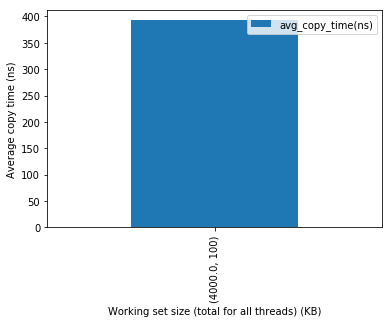

In [264]:
data_lines = [
'thd_id=0,rec_cnt=1,copying_ticks=1081866,time=0.000451,avg_copy_ticks=1056,avg_copy_time(ns)=440.212402,total_copy_cnt=1024',
'thd_id=0,rec_cnt=10,copying_ticks=8660580,time=0.003609,avg_copy_ticks=845,avg_copy_time(ns)=352.399902,total_copy_cnt=10240',
'thd_id=0,rec_cnt=100,copying_ticks=144243338,time=0.060101,avg_copy_ticks=1408,avg_copy_time(ns)=586.927645,total_copy_cnt=102400',
'thd_id=0,rec_cnt=200,copying_ticks=206931930,time=0.086222,avg_copy_ticks=1010,avg_copy_time(ns)=421.004089,total_copy_cnt=204800',
'thd_id=0,rec_cnt=400,copying_ticks=1017572887,time=0.423989,avg_copy_ticks=2484,avg_copy_time(ns)=1035.128669,total_copy_cnt=409600',
'thd_id=0,rec_cnt=500,copying_ticks=2100333768,time=0.875139,avg_copy_ticks=4102,avg_copy_time(ns)=1709.255996,total_copy_cnt=512000',
'thd_id=0,rec_cnt=600,copying_ticks=4638984192,time=1.932910,avg_copy_ticks=7550,avg_copy_time(ns)=3146.012500,total_copy_cnt=614400',
'thd_id=0,rec_cnt=700,copying_ticks=8782977305,time=3.659574,avg_copy_ticks=12253,avg_copy_time(ns)=5105.432306,total_copy_cnt=716800',
'thd_id=0,rec_cnt=800,copying_ticks=10141547965,time=4.225645,avg_copy_ticks=12379,avg_copy_time(ns)=5158.258039,total_copy_cnt=819200',
'thd_id=0,rec_cnt=1000,copying_ticks=12942746090,time=5.392811,avg_copy_ticks=12639,avg_copy_time(ns)=5266.416866,total_copy_cnt=1024000',
'thd_id=0,rec_cnt=2000,copying_ticks=24244988766,time=10.102079,avg_copy_ticks=11838,avg_copy_time(ns)=4932.655592,total_copy_cnt=2048000',
'thd_id=0,rec_cnt=4000,copying_ticks=47571632025,time=19.821513,avg_copy_ticks=11614,avg_copy_time(ns)=4839.236656,total_copy_cnt=4096000',
'thd_id=0,rec_cnt=8000,copying_ticks=97823198098,time=40.759666,avg_copy_ticks=11941,avg_copy_time(ns)=4975.545151,total_copy_cnt=8192000',
'thd_id=0,rec_cnt=12000,copying_ticks=156163856967,time=65.068274,avg_copy_ticks=12708,avg_copy_time(ns)=5295.269673,total_copy_cnt=12288000',
'thd_id=1,rec_cnt=1,copying_ticks=1094283,time=0.000456,avg_copy_ticks=1068,avg_copy_time(ns)=445.264893,total_copy_cnt=1024',
'thd_id=1,rec_cnt=10,copying_ticks=5373327,time=0.002239,avg_copy_ticks=524,avg_copy_time(ns)=218.641235,total_copy_cnt=10240',
'thd_id=1,rec_cnt=100,copying_ticks=135039163,time=0.056266,avg_copy_ticks=1318,avg_copy_time(ns)=549.475761,total_copy_cnt=102400',
'thd_id=1,rec_cnt=200,copying_ticks=203265740,time=0.084694,avg_copy_ticks=992,avg_copy_time(ns)=413.545207,total_copy_cnt=204800',
'thd_id=1,rec_cnt=400,copying_ticks=529097693,time=0.220457,avg_copy_ticks=1291,avg_copy_time(ns)=538.226006,total_copy_cnt=409600',
'thd_id=1,rec_cnt=500,copying_ticks=1223088210,time=0.509620,avg_copy_ticks=2388,avg_copy_time(ns)=995.351733,total_copy_cnt=512000',
'thd_id=1,rec_cnt=600,copying_ticks=2504709408,time=1.043629,avg_copy_ticks=4076,avg_copy_time(ns)=1698.614779,total_copy_cnt=614400',
'thd_id=1,rec_cnt=700,copying_ticks=8416832404,time=3.507014,avg_copy_ticks=11742,avg_copy_time(ns)=4892.596961,total_copy_cnt=716800',
'thd_id=1,rec_cnt=800,copying_ticks=9448103721,time=3.936710,avg_copy_ticks=11533,avg_copy_time(ns)=4805.554057,total_copy_cnt=819200',
'thd_id=1,rec_cnt=1000,copying_ticks=13146028519,time=5.477512,avg_copy_ticks=12837,avg_copy_time(ns)=5349.132698,total_copy_cnt=1024000',
'thd_id=1,rec_cnt=2000,copying_ticks=24363146411,time=10.151311,avg_copy_ticks=11896,avg_copy_time(ns)=4956.694826,total_copy_cnt=2048000',
'thd_id=1,rec_cnt=4000,copying_ticks=47540179488,time=19.808408,avg_copy_ticks=11606,avg_copy_time(ns)=4836.037139,total_copy_cnt=4096000',
'thd_id=1,rec_cnt=8000,copying_ticks=95344684661,time=39.726952,avg_copy_ticks=11638,avg_copy_time(ns)=4849.481438,total_copy_cnt=8192000',
'thd_id=1,rec_cnt=12000,copying_ticks=159545947614,time=66.477478,avg_copy_ticks=12983,avg_copy_time(ns)=5409.951023,total_copy_cnt=12288000',
'thd_id=2,rec_cnt=1,copying_ticks=1082190,time=0.000451,avg_copy_ticks=1056,avg_copy_time(ns)=440.344238,total_copy_cnt=1024',
'thd_id=2,rec_cnt=10,copying_ticks=8721378,time=0.003634,avg_copy_ticks=851,avg_copy_time(ns)=354.873779,total_copy_cnt=10240',
'thd_id=2,rec_cnt=100,copying_ticks=144929671,time=0.060387,avg_copy_ticks=1415,avg_copy_time(ns)=589.720341,total_copy_cnt=102400',
'thd_id=2,rec_cnt=200,copying_ticks=210671587,time=0.087780,avg_copy_ticks=1028,avg_copy_time(ns)=428.612441,total_copy_cnt=204800',
'thd_id=2,rec_cnt=400,copying_ticks=776676428,time=0.323615,avg_copy_ticks=1896,avg_copy_time(ns)=790.076119,total_copy_cnt=409600',
'thd_id=2,rec_cnt=500,copying_ticks=2024499072,time=0.843541,avg_copy_ticks=3954,avg_copy_time(ns)=1647.541563,total_copy_cnt=512000',
'thd_id=2,rec_cnt=600,copying_ticks=3611420092,time=1.504758,avg_copy_ticks=5877,avg_copy_time(ns)=2449.150996,total_copy_cnt=614400',
'thd_id=2,rec_cnt=700,copying_ticks=8267034824,time=3.444598,avg_copy_ticks=11533,avg_copy_time(ns)=4805.521545,total_copy_cnt=716800',
'thd_id=2,rec_cnt=800,copying_ticks=10181206066,time=4.242169,avg_copy_ticks=12428,avg_copy_time(ns)=5178.429192,total_copy_cnt=819200',
'thd_id=2,rec_cnt=1000,copying_ticks=11940178560,time=4.975074,avg_copy_ticks=11660,avg_copy_time(ns)=4858.471094,total_copy_cnt=1024000',
'thd_id=2,rec_cnt=2000,copying_ticks=23474429345,time=9.781012,avg_copy_ticks=11462,avg_copy_time(ns)=4775.884877,total_copy_cnt=2048000',
'thd_id=2,rec_cnt=4000,copying_ticks=48159859350,time=20.066608,avg_copy_ticks=11757,avg_copy_time(ns)=4899.074234,total_copy_cnt=4096000',
'thd_id=2,rec_cnt=8000,copying_ticks=95588847378,time=39.828686,avg_copy_ticks=11668,avg_copy_time(ns)=4861.900196,total_copy_cnt=8192000',
'thd_id=2,rec_cnt=12000,copying_ticks=159155557366,time=66.314816,avg_copy_ticks=12952,avg_copy_time(ns)=5396.713507,total_copy_cnt=12288000',
'thd_id=3,rec_cnt=1,copying_ticks=1216684,time=0.000507,avg_copy_ticks=1188,avg_copy_time(ns)=495.069987,total_copy_cnt=1024',
'thd_id=3,rec_cnt=10,copying_ticks=10184692,time=0.004244,avg_copy_ticks=994,avg_copy_time(ns)=414.416178,total_copy_cnt=10240',
'thd_id=3,rec_cnt=100,copying_ticks=141475782,time=0.058948,avg_copy_ticks=1381,avg_copy_time(ns)=575.666431,total_copy_cnt=102400',
'thd_id=3,rec_cnt=200,copying_ticks=202432947,time=0.084347,avg_copy_ticks=988,avg_copy_time(ns)=411.850885,total_copy_cnt=204800',
'thd_id=3,rec_cnt=400,copying_ticks=480257585,time=0.200107,avg_copy_ticks=1172,avg_copy_time(ns)=488.543279,total_copy_cnt=409600',
'thd_id=3,rec_cnt=500,copying_ticks=1785101065,time=0.743792,avg_copy_ticks=3486,avg_copy_time(ns)=1452.718966,total_copy_cnt=512000',
'thd_id=3,rec_cnt=600,copying_ticks=3803953953,time=1.584981,avg_copy_ticks=6191,avg_copy_time(ns)=2579.721377,total_copy_cnt=614400',
'thd_id=3,rec_cnt=700,copying_ticks=7910131630,time=3.295888,avg_copy_ticks=11035,avg_copy_time(ns)=4598.058286,total_copy_cnt=716800',
'thd_id=3,rec_cnt=800,copying_ticks=10329002801,time=4.303751,avg_copy_ticks=12608,avg_copy_time(ns)=5253.602499,total_copy_cnt=819200',
'thd_id=3,rec_cnt=1000,copying_ticks=12646619094,time=5.269425,avg_copy_ticks=12350,avg_copy_time(ns)=5145.922483,total_copy_cnt=1024000',
'thd_id=3,rec_cnt=2000,copying_ticks=23377385141,time=9.740577,avg_copy_ticks=11414,avg_copy_time(ns)=4756.141183,total_copy_cnt=2048000',
'thd_id=3,rec_cnt=4000,copying_ticks=42727373950,time=17.803072,avg_copy_ticks=10431,avg_copy_time(ns)=4346.453242,total_copy_cnt=4096000',
'thd_id=3,rec_cnt=8000,copying_ticks=95384433714,time=39.743514,avg_copy_ticks=11643,avg_copy_time(ns)=4851.503180,total_copy_cnt=8192000',
'thd_id=3,rec_cnt=12000,copying_ticks=159646638363,time=66.519433,avg_copy_ticks=12992,avg_copy_time(ns)=5413.365287,total_copy_cnt=12288000',
'thd_id=4,rec_cnt=1,copying_ticks=1081956,time=0.000451,avg_copy_ticks=1056,avg_copy_time(ns)=440.249023,total_copy_cnt=1024',
'thd_id=4,rec_cnt=10,copying_ticks=9250179,time=0.003854,avg_copy_ticks=903,avg_copy_time(ns)=376.390747,total_copy_cnt=10240',
'thd_id=4,rec_cnt=100,copying_ticks=138744173,time=0.057810,avg_copy_ticks=1354,avg_copy_time(ns)=564.551485,total_copy_cnt=102400',
'thd_id=4,rec_cnt=200,copying_ticks=209410633,time=0.087254,avg_copy_ticks=1022,avg_copy_time(ns)=426.047024,total_copy_cnt=204800',
'thd_id=4,rec_cnt=400,copying_ticks=469858757,time=0.195774,avg_copy_ticks=1147,avg_copy_time(ns)=477.965044,total_copy_cnt=409600',
'thd_id=4,rec_cnt=500,copying_ticks=1708883509,time=0.712035,avg_copy_ticks=3337,avg_copy_time(ns)=1390.692960,total_copy_cnt=512000',
'thd_id=4,rec_cnt=600,copying_ticks=5689135745,time=2.370473,avg_copy_ticks=9259,avg_copy_time(ns)=3858.192101,total_copy_cnt=614400',
'thd_id=4,rec_cnt=700,copying_ticks=8775419715,time=3.656425,avg_copy_ticks=12242,avg_copy_time(ns)=5101.039176,total_copy_cnt=716800',
'thd_id=4,rec_cnt=800,copying_ticks=10417510031,time=4.340629,avg_copy_ticks=12716,avg_copy_time(ns)=5298.619604,total_copy_cnt=819200',
'thd_id=4,rec_cnt=1000,copying_ticks=12888722637,time=5.370301,avg_copy_ticks=12586,avg_copy_time(ns)=5244.434667,total_copy_cnt=1024000',
'thd_id=4,rec_cnt=2000,copying_ticks=23556553944,time=9.815231,avg_copy_ticks=11502,avg_copy_time(ns)=4792.593169,total_copy_cnt=2048000',
'thd_id=4,rec_cnt=4000,copying_ticks=47056642433,time=19.606934,avg_copy_ticks=11488,avg_copy_time(ns)=4786.849206,total_copy_cnt=4096000',
'thd_id=4,rec_cnt=8000,copying_ticks=91557684621,time=38.149035,avg_copy_ticks=11176,avg_copy_time(ns)=4656.864656,total_copy_cnt=8192000',
'thd_id=4,rec_cnt=12000,copying_ticks=160020794265,time=66.675331,avg_copy_ticks=13022,avg_copy_time(ns)=5426.052323,total_copy_cnt=12288000',
'thd_id=5,rec_cnt=1,copying_ticks=1081509,time=0.000451,avg_copy_ticks=1056,avg_copy_time(ns)=440.067139,total_copy_cnt=1024',
'thd_id=5,rec_cnt=10,copying_ticks=9559044,time=0.003983,avg_copy_ticks=933,avg_copy_time(ns)=388.958496,total_copy_cnt=10240',
'thd_id=5,rec_cnt=100,copying_ticks=144055029,time=0.060023,avg_copy_ticks=1406,avg_copy_time(ns)=586.161414,total_copy_cnt=102400',
'thd_id=5,rec_cnt=200,copying_ticks=217702367,time=0.090709,avg_copy_ticks=1062,avg_copy_time(ns)=442.916600,total_copy_cnt=204800',
'thd_id=5,rec_cnt=400,copying_ticks=818974765,time=0.341239,avg_copy_ticks=1999,avg_copy_time(ns)=833.104212,total_copy_cnt=409600',
'thd_id=5,rec_cnt=500,copying_ticks=2690385884,time=1.120994,avg_copy_ticks=5254,avg_copy_time(ns)=2189.441637,total_copy_cnt=512000',
'thd_id=5,rec_cnt=600,copying_ticks=3939937218,time=1.641641,avg_copy_ticks=6412,avg_copy_time(ns)=2671.940930,total_copy_cnt=614400',
'thd_id=5,rec_cnt=700,copying_ticks=7983966363,time=3.326653,avg_copy_ticks=11138,avg_copy_time(ns)=4640.977471,total_copy_cnt=716800',
'thd_id=5,rec_cnt=800,copying_ticks=10040188800,time=4.183412,avg_copy_ticks=12256,avg_copy_time(ns)=5106.704102,total_copy_cnt=819200',
'thd_id=5,rec_cnt=1000,copying_ticks=12928688604,time=5.386954,avg_copy_ticks=12625,avg_copy_time(ns)=5260.696860,total_copy_cnt=1024000',
'thd_id=5,rec_cnt=2000,copying_ticks=24327031955,time=10.136263,avg_copy_ticks=11878,avg_copy_time(ns)=4949.347322,total_copy_cnt=2048000',
'thd_id=5,rec_cnt=4000,copying_ticks=47348857930,time=19.728691,avg_copy_ticks=11559,avg_copy_time(ns)=4816.574903,total_copy_cnt=4096000',
'thd_id=5,rec_cnt=8000,copying_ticks=95390229726,time=39.745929,avg_copy_ticks=11644,avg_copy_time(ns)=4851.797980,total_copy_cnt=8192000',
'thd_id=5,rec_cnt=12000,copying_ticks=158468977858,time=66.028741,avg_copy_ticks=12896,avg_copy_time(ns)=5373.432680,total_copy_cnt=12288000',
'thd_id=6,rec_cnt=1,copying_ticks=1679196,time=0.000700,avg_copy_ticks=1639,avg_copy_time(ns)=683.266602,total_copy_cnt=1024',
'thd_id=6,rec_cnt=10,copying_ticks=9955752,time=0.004148,avg_copy_ticks=972,avg_copy_time(ns)=405.100586,total_copy_cnt=10240',
'thd_id=6,rec_cnt=100,copying_ticks=136631478,time=0.056930,avg_copy_ticks=1334,avg_copy_time(ns)=555.954907,total_copy_cnt=102400',
'thd_id=6,rec_cnt=200,copying_ticks=200960244,time=0.083733,avg_copy_ticks=981,avg_copy_time(ns)=408.854663,total_copy_cnt=204800',
'thd_id=6,rec_cnt=400,copying_ticks=1162064527,time=0.484194,avg_copy_ticks=2837,avg_copy_time(ns)=1182.113166,total_copy_cnt=409600',
'thd_id=6,rec_cnt=500,copying_ticks=2392938974,time=0.997058,avg_copy_ticks=4673,avg_copy_time(ns)=1947.378722,total_copy_cnt=512000',
'thd_id=6,rec_cnt=600,copying_ticks=4664010239,time=1.943338,avg_copy_ticks=7591,avg_copy_time(ns)=3162.984374,total_copy_cnt=614400',
'thd_id=6,rec_cnt=700,copying_ticks=8585106676,time=3.577128,avg_copy_ticks=11976,avg_copy_time(ns)=4990.412642,total_copy_cnt=716800',
'thd_id=6,rec_cnt=800,copying_ticks=10247205675,time=4.269669,avg_copy_ticks=12508,avg_copy_time(ns)=5211.998329,total_copy_cnt=819200',
'thd_id=6,rec_cnt=1000,copying_ticks=12801436539,time=5.333932,avg_copy_ticks=12501,avg_copy_time(ns)=5208.917863,total_copy_cnt=1024000',
'thd_id=6,rec_cnt=2000,copying_ticks=25473048591,time=10.613770,avg_copy_ticks=12438,avg_copy_time(ns)=5182.505003,total_copy_cnt=2048000',
'thd_id=6,rec_cnt=4000,copying_ticks=47770167145,time=19.904236,avg_copy_ticks=11662,avg_copy_time(ns)=4859.432693,total_copy_cnt=4096000',
'thd_id=6,rec_cnt=8000,copying_ticks=101663426258,time=42.359761,avg_copy_ticks=12410,avg_copy_time(ns)=5170.869255,total_copy_cnt=8192000',
'thd_id=6,rec_cnt=12000,copying_ticks=151648099663,time=63.186708,avg_copy_ticks=12341,avg_copy_time(ns)=5142.147477,total_copy_cnt=12288000',
'thd_id=7,rec_cnt=1,copying_ticks=1211912,time=0.000505,avg_copy_ticks=1183,avg_copy_time(ns)=493.128255,total_copy_cnt=1024',
'thd_id=7,rec_cnt=10,copying_ticks=9816332,time=0.004090,avg_copy_ticks=958,avg_copy_time(ns)=399.427572,total_copy_cnt=10240',
'thd_id=7,rec_cnt=100,copying_ticks=137776420,time=0.057407,avg_copy_ticks=1345,avg_copy_time(ns)=560.613688,total_copy_cnt=102400',
'thd_id=7,rec_cnt=200,copying_ticks=214807034,time=0.089503,avg_copy_ticks=1048,avg_copy_time(ns)=437.026029,total_copy_cnt=204800',
'thd_id=7,rec_cnt=400,copying_ticks=944645208,time=0.393602,avg_copy_ticks=2306,avg_copy_time(ns)=960.942798,total_copy_cnt=409600',
'thd_id=7,rec_cnt=500,copying_ticks=1123098809,time=0.467958,avg_copy_ticks=2193,avg_copy_time(ns)=913.980151,total_copy_cnt=512000',
'thd_id=7,rec_cnt=600,copying_ticks=6145719144,time=2.560716,avg_copy_ticks=10002,avg_copy_time(ns)=4167.832536,total_copy_cnt=614400',
'thd_id=7,rec_cnt=700,copying_ticks=4896514660,time=2.040214,avg_copy_ticks=6831,avg_copy_time(ns)=2846.281308,total_copy_cnt=716800',
'thd_id=7,rec_cnt=800,copying_ticks=9749263077,time=4.062193,avg_copy_ticks=11900,avg_copy_time(ns)=4958.731627,total_copy_cnt=819200',
'thd_id=7,rec_cnt=1000,copying_ticks=13067442831,time=5.444768,avg_copy_ticks=12761,avg_copy_time(ns)=5317.156100,total_copy_cnt=1024000',
'thd_id=7,rec_cnt=2000,copying_ticks=25403769879,time=10.584904,avg_copy_ticks=12404,avg_copy_time(ns)=5168.410213,total_copy_cnt=2048000',
'thd_id=7,rec_cnt=4000,copying_ticks=46849725328,time=19.520719,avg_copy_ticks=11437,avg_copy_time(ns)=4765.800509,total_copy_cnt=4096000',
'thd_id=7,rec_cnt=8000,copying_ticks=96021884822,time=40.009119,avg_copy_ticks=11721,avg_copy_time(ns)=4883.925620,total_copy_cnt=8192000',
'thd_id=7,rec_cnt=12000,copying_ticks=159796277222,time=66.581782,avg_copy_ticks=13004,avg_copy_time(ns)=5418.439305,total_copy_cnt=12288000',
'thd_id=8,rec_cnt=1,copying_ticks=1216716,time=0.000507,avg_copy_ticks=1188,avg_copy_time(ns)=495.083008,total_copy_cnt=1024',
'thd_id=8,rec_cnt=10,copying_ticks=9948504,time=0.004145,avg_copy_ticks=971,avg_copy_time(ns)=404.805664,total_copy_cnt=10240',
'thd_id=8,rec_cnt=100,copying_ticks=130866564,time=0.054528,avg_copy_ticks=1277,avg_copy_time(ns)=532.497412,total_copy_cnt=102400',
'thd_id=8,rec_cnt=200,copying_ticks=202756612,time=0.084482,avg_copy_ticks=990,avg_copy_time(ns)=412.509383,total_copy_cnt=204800',
'thd_id=8,rec_cnt=400,copying_ticks=1152988779,time=0.480412,avg_copy_ticks=2814,avg_copy_time(ns)=1172.880838,total_copy_cnt=409600',
'thd_id=8,rec_cnt=500,copying_ticks=1572853064,time=0.655355,avg_copy_ticks=3071,avg_copy_time(ns)=1279.991100,total_copy_cnt=512000',
'thd_id=8,rec_cnt=600,copying_ticks=6331891606,time=2.638288,avg_copy_ticks=10305,avg_copy_time(ns)=4294.088817,total_copy_cnt=614400',
'thd_id=8,rec_cnt=700,copying_ticks=8643635592,time=3.601515,avg_copy_ticks=12058,avg_copy_time(ns)=5024.434752,total_copy_cnt=716800',
'thd_id=8,rec_cnt=800,copying_ticks=10052754933,time=4.188648,avg_copy_ticks=12271,avg_copy_time(ns)=5113.095567,total_copy_cnt=819200',
'thd_id=8,rec_cnt=1000,copying_ticks=12836142990,time=5.348393,avg_copy_ticks=12535,avg_copy_time(ns)=5223.039954,total_copy_cnt=1024000',
'thd_id=8,rec_cnt=2000,copying_ticks=23985020868,time=9.993759,avg_copy_ticks=11711,avg_copy_time(ns)=4879.764988,total_copy_cnt=2048000',
'thd_id=8,rec_cnt=4000,copying_ticks=46039453854,time=19.183106,avg_copy_ticks=11240,avg_copy_time(ns)=4683.375433,total_copy_cnt=4096000',
'thd_id=8,rec_cnt=8000,copying_ticks=95559933071,time=39.816639,avg_copy_ticks=11665,avg_copy_time(ns)=4860.429539,total_copy_cnt=8192000',
'thd_id=8,rec_cnt=12000,copying_ticks=157999630695,time=65.833179,avg_copy_ticks=12858,avg_copy_time(ns)=5357.517859,total_copy_cnt=12288000',
'thd_id=9,rec_cnt=1,copying_ticks=1081698,time=0.000451,avg_copy_ticks=1056,avg_copy_time(ns)=440.144043,total_copy_cnt=1024',
'thd_id=9,rec_cnt=10,copying_ticks=9925467,time=0.004136,avg_copy_ticks=969,avg_copy_time(ns)=403.868286,total_copy_cnt=10240',
'thd_id=9,rec_cnt=100,copying_ticks=141472936,time=0.058947,avg_copy_ticks=1381,avg_copy_time(ns)=575.654850,total_copy_cnt=102400',
'thd_id=9,rec_cnt=200,copying_ticks=200911608,time=0.083713,avg_copy_ticks=981,avg_copy_time(ns)=408.755713,total_copy_cnt=204800',
'thd_id=9,rec_cnt=400,copying_ticks=944279762,time=0.393450,avg_copy_ticks=2305,avg_copy_time(ns)=960.571047,total_copy_cnt=409600',
'thd_id=9,rec_cnt=500,copying_ticks=1589277039,time=0.662199,avg_copy_ticks=3104,avg_copy_time(ns)=1293.356965,total_copy_cnt=512000',
'thd_id=9,rec_cnt=600,copying_ticks=6379974753,time=2.658323,avg_copy_ticks=10384,avg_copy_time(ns)=4326.697288,total_copy_cnt=614400',
'thd_id=9,rec_cnt=700,copying_ticks=8413330728,time=3.505554,avg_copy_ticks=11737,avg_copy_time(ns)=4890.561482,total_copy_cnt=716800',
'thd_id=9,rec_cnt=800,copying_ticks=9948392519,time=4.145164,avg_copy_ticks=12144,avg_copy_time(ns)=5060.014099,total_copy_cnt=819200',
'thd_id=9,rec_cnt=1000,copying_ticks=12873672686,time=5.364030,avg_copy_ticks=12571,avg_copy_time(ns)=5238.310826,total_copy_cnt=1024000',
'thd_id=9,rec_cnt=2000,copying_ticks=22988926235,time=9.578719,avg_copy_ticks=11225,avg_copy_time(ns)=4677.109016,total_copy_cnt=2048000',
'thd_id=9,rec_cnt=4000,copying_ticks=46212641724,time=19.255267,avg_copy_ticks=11282,avg_copy_time(ns)=4700.993014,total_copy_cnt=4096000',
'thd_id=9,rec_cnt=8000,copying_ticks=96321906988,time=40.134128,avg_copy_ticks=11758,avg_copy_time(ns)=4899.185536,total_copy_cnt=8192000',
'thd_id=9,rec_cnt=12000,copying_ticks=158674354614,time=66.114314,avg_copy_ticks=12912,avg_copy_time(ns)=5380.396682,total_copy_cnt=12288000',
'thd_id=0,rec_cnt=1,copying_ticks=1080423,time=0.000450,avg_copy_ticks=1055,avg_copy_time(ns)=439.625244,total_copy_cnt=1024',
'thd_id=0,rec_cnt=10,copying_ticks=8834487,time=0.003681,avg_copy_ticks=862,avg_copy_time(ns)=359.476196,total_copy_cnt=10240',
'thd_id=0,rec_cnt=100,copying_ticks=134802070,time=0.056168,avg_copy_ticks=1316,avg_copy_time(ns)=548.511027,total_copy_cnt=102400',
'thd_id=0,rec_cnt=200,copying_ticks=235405500,time=0.098086,avg_copy_ticks=1149,avg_copy_time(ns)=478.933716,total_copy_cnt=204800',
'thd_id=0,rec_cnt=400,copying_ticks=652222419,time=0.271759,avg_copy_ticks=1592,avg_copy_time(ns)=663.474954,total_copy_cnt=409600',
'thd_id=0,rec_cnt=500,copying_ticks=2450409425,time=1.021004,avg_copy_ticks=4785,avg_copy_time(ns)=1994.148295,total_copy_cnt=512000',
'thd_id=0,rec_cnt=600,copying_ticks=5166151252,time=2.152563,avg_copy_ticks=8408,avg_copy_time(ns)=3503.520543,total_copy_cnt=614400',
'thd_id=0,rec_cnt=700,copying_ticks=7181721023,time=2.992384,avg_copy_ticks=10019,avg_copy_time(ns)=4174.642522,total_copy_cnt=716800',
'thd_id=0,rec_cnt=800,copying_ticks=10457085361,time=4.357119,avg_copy_ticks=12764,avg_copy_time(ns)=5318.748658,total_copy_cnt=819200',
'thd_id=0,rec_cnt=1000,copying_ticks=13202344206,time=5.500977,avg_copy_ticks=12892,avg_copy_time(ns)=5372.047610,total_copy_cnt=1024000',
'thd_id=0,rec_cnt=2000,copying_ticks=24631078056,time=10.262949,avg_copy_ticks=12026,avg_copy_time(ns)=5011.205659,total_copy_cnt=2048000',
'thd_id=0,rec_cnt=4000,copying_ticks=47278786839,time=19.699495,avg_copy_ticks=11542,avg_copy_time(ns)=4809.446903,total_copy_cnt=4096000',
'thd_id=0,rec_cnt=8000,copying_ticks=92735881032,time=38.639950,avg_copy_ticks=11320,avg_copy_time(ns)=4716.790824,total_copy_cnt=8192000',
'thd_id=0,rec_cnt=12000,copying_ticks=159198237760,time=66.332599,avg_copy_ticks=12955,avg_copy_time(ns)=5398.160731,total_copy_cnt=12288000',
'thd_id=1,rec_cnt=1,copying_ticks=1217444,time=0.000507,avg_copy_ticks=1188,avg_copy_time(ns)=495.379232,total_copy_cnt=1024',
'thd_id=1,rec_cnt=10,copying_ticks=9912149,time=0.004130,avg_copy_ticks=967,avg_copy_time(ns)=403.326375,total_copy_cnt=10240',
'thd_id=1,rec_cnt=100,copying_ticks=136894639,time=0.057039,avg_copy_ticks=1336,avg_copy_time(ns)=557.025712,total_copy_cnt=102400',
'thd_id=1,rec_cnt=200,copying_ticks=202155591,time=0.084231,avg_copy_ticks=987,avg_copy_time(ns)=411.286603,total_copy_cnt=204800',
'thd_id=1,rec_cnt=400,copying_ticks=1142185533,time=0.475911,avg_copy_ticks=2788,avg_copy_time(ns)=1161.891208,total_copy_cnt=409600',
'thd_id=1,rec_cnt=500,copying_ticks=2444287413,time=1.018453,avg_copy_ticks=4773,avg_copy_time(ns)=1989.166189,total_copy_cnt=512000',
'thd_id=1,rec_cnt=600,copying_ticks=6150670110,time=2.562779,avg_copy_ticks=10010,avg_copy_time(ns)=4171.190125,total_copy_cnt=614400',
'thd_id=1,rec_cnt=700,copying_ticks=8798555854,time=3.666065,avg_copy_ticks=12274,avg_copy_time(ns)=5114.487917,total_copy_cnt=716800',
'thd_id=1,rec_cnt=800,copying_ticks=10563551017,time=4.401480,avg_copy_ticks=12894,avg_copy_time(ns)=5372.899891,total_copy_cnt=819200',
'thd_id=1,rec_cnt=1000,copying_ticks=13175188641,time=5.489662,avg_copy_ticks=12866,avg_copy_time(ns)=5360.997982,total_copy_cnt=1024000',
'thd_id=1,rec_cnt=2000,copying_ticks=24820629601,time=10.341929,avg_copy_ticks=12119,avg_copy_time(ns)=5049.770020,total_copy_cnt=2048000',
'thd_id=1,rec_cnt=4000,copying_ticks=46857189444,time=19.523829,avg_copy_ticks=11439,avg_copy_time(ns)=4766.559799,total_copy_cnt=4096000',
'thd_id=1,rec_cnt=8000,copying_ticks=96882604937,time=40.367752,avg_copy_ticks=11826,avg_copy_time(ns)=4927.704109,total_copy_cnt=8192000',
'thd_id=1,rec_cnt=12000,copying_ticks=155560484358,time=64.816868,avg_copy_ticks=12659,avg_copy_time(ns)=5274.810261,total_copy_cnt=12288000',
'thd_id=2,rec_cnt=1,copying_ticks=1095108,time=0.000456,avg_copy_ticks=1069,avg_copy_time(ns)=445.600586,total_copy_cnt=1024',
'thd_id=2,rec_cnt=10,copying_ticks=5436837,time=0.002265,avg_copy_ticks=530,avg_copy_time(ns)=221.225464,total_copy_cnt=10240',
'thd_id=2,rec_cnt=100,copying_ticks=130376496,time=0.054324,avg_copy_ticks=1273,avg_copy_time(ns)=530.503320,total_copy_cnt=102400',
'thd_id=2,rec_cnt=200,copying_ticks=204660089,time=0.085275,avg_copy_ticks=999,avg_copy_time(ns)=416.382017,total_copy_cnt=204800',
'thd_id=2,rec_cnt=400,copying_ticks=754050413,time=0.314188,avg_copy_ticks=1840,avg_copy_time(ns)=767.059746,total_copy_cnt=409600',
'thd_id=2,rec_cnt=500,copying_ticks=2143594308,time=0.893164,avg_copy_ticks=4186,avg_copy_time(ns)=1744.461514,total_copy_cnt=512000',
'thd_id=2,rec_cnt=600,copying_ticks=6182682414,time=2.576118,avg_copy_ticks=10062,avg_copy_time(ns)=4192.899858,total_copy_cnt=614400',
'thd_id=2,rec_cnt=700,copying_ticks=8818701786,time=3.674459,avg_copy_ticks=12302,avg_copy_time(ns)=5126.198490,total_copy_cnt=716800',
'thd_id=2,rec_cnt=800,copying_ticks=10296728235,time=4.290303,avg_copy_ticks=12569,avg_copy_time(ns)=5237.186806,total_copy_cnt=819200',
'thd_id=2,rec_cnt=1000,copying_ticks=13129211177,time=5.470505,avg_copy_ticks=12821,avg_copy_time(ns)=5342.289704,total_copy_cnt=1024000',
'thd_id=2,rec_cnt=2000,copying_ticks=25633591219,time=10.680663,avg_copy_ticks=12516,avg_copy_time(ns)=5215.167484,total_copy_cnt=2048000',
'thd_id=2,rec_cnt=4000,copying_ticks=47383006560,time=19.742919,avg_copy_ticks=11568,avg_copy_time(ns)=4820.048682,total_copy_cnt=4096000',
'thd_id=2,rec_cnt=8000,copying_ticks=97400382186,time=40.583493,avg_copy_ticks=11889,avg_copy_time(ns)=4954.039621,total_copy_cnt=8192000',
'thd_id=2,rec_cnt=12000,copying_ticks=154879612546,time=64.533172,avg_copy_ticks=12604,avg_copy_time(ns)=5251.722973,total_copy_cnt=12288000',
'thd_id=3,rec_cnt=1,copying_ticks=1355688,time=0.000565,avg_copy_ticks=1323,avg_copy_time(ns)=551.630859,total_copy_cnt=1024',
'thd_id=3,rec_cnt=10,copying_ticks=10745189,time=0.004477,avg_copy_ticks=1049,avg_copy_time(ns)=437.222860,total_copy_cnt=10240',
'thd_id=3,rec_cnt=100,copying_ticks=142650573,time=0.059438,avg_copy_ticks=1393,avg_copy_time(ns)=580.446667,total_copy_cnt=102400',
'thd_id=3,rec_cnt=200,copying_ticks=202319763,time=0.084300,avg_copy_ticks=987,avg_copy_time(ns)=411.620612,total_copy_cnt=204800',
'thd_id=3,rec_cnt=400,copying_ticks=531272320,time=0.221363,avg_copy_ticks=1297,avg_copy_time(ns)=540.438151,total_copy_cnt=409600',
'thd_id=3,rec_cnt=500,copying_ticks=1087352346,time=0.453063,avg_copy_ticks=2123,avg_copy_time(ns)=884.889604,total_copy_cnt=512000',
'thd_id=3,rec_cnt=600,copying_ticks=4450733351,time=1.854472,avg_copy_ticks=7244,avg_copy_time(ns)=3018.346728,total_copy_cnt=614400',
'thd_id=3,rec_cnt=700,copying_ticks=7813335572,time=3.255556,avg_copy_ticks=10900,avg_copy_time(ns)=4541.791976,total_copy_cnt=716800',
'thd_id=3,rec_cnt=800,copying_ticks=10462292131,time=4.359288,avg_copy_ticks=12771,avg_copy_time(ns)=5321.396958,total_copy_cnt=819200',
'thd_id=3,rec_cnt=1000,copying_ticks=13120250016,time=5.466771,avg_copy_ticks=12812,avg_copy_time(ns)=5338.643398,total_copy_cnt=1024000',
'thd_id=3,rec_cnt=2000,copying_ticks=24696557334,time=10.290232,avg_copy_ticks=12058,avg_copy_time(ns)=5024.527452,total_copy_cnt=2048000',
'thd_id=3,rec_cnt=4000,copying_ticks=47155200593,time=19.648000,avg_copy_ticks=11512,avg_copy_time(ns)=4796.875060,total_copy_cnt=4096000',
'thd_id=3,rec_cnt=8000,copying_ticks=95104871825,time=39.627030,avg_copy_ticks=11609,avg_copy_time(ns)=4837.283927,total_copy_cnt=8192000',
'thd_id=3,rec_cnt=12000,copying_ticks=159071031019,time=66.279596,avg_copy_ticks=12945,avg_copy_time(ns)=5393.847352,total_copy_cnt=12288000',
'thd_id=4,rec_cnt=1,copying_ticks=1197915,time=0.000499,avg_copy_ticks=1169,avg_copy_time(ns)=487.432861,total_copy_cnt=1024',
'thd_id=4,rec_cnt=10,copying_ticks=9213702,time=0.003839,avg_copy_ticks=899,avg_copy_time(ns)=374.906494,total_copy_cnt=10240',
'thd_id=4,rec_cnt=100,copying_ticks=130238918,time=0.054266,avg_copy_ticks=1271,avg_copy_time(ns)=529.943514,total_copy_cnt=102400',
'thd_id=4,rec_cnt=200,copying_ticks=221916112,time=0.092465,avg_copy_ticks=1083,avg_copy_time(ns)=451.489486,total_copy_cnt=204800',
'thd_id=4,rec_cnt=400,copying_ticks=810732379,time=0.337805,avg_copy_ticks=1979,avg_copy_time(ns)=824.719624,total_copy_cnt=409600',
'thd_id=4,rec_cnt=500,copying_ticks=2539566888,time=1.058153,avg_copy_ticks=4960,avg_copy_time(ns)=2066.704824,total_copy_cnt=512000',
'thd_id=4,rec_cnt=600,copying_ticks=4104898116,time=1.710374,avg_copy_ticks=6681,avg_copy_time(ns)=2783.812199,total_copy_cnt=614400',
'thd_id=4,rec_cnt=700,copying_ticks=8071038870,time=3.362933,avg_copy_ticks=11259,avg_copy_time(ns)=4691.591605,total_copy_cnt=716800',
'thd_id=4,rec_cnt=800,copying_ticks=10189466291,time=4.245611,avg_copy_ticks=12438,avg_copy_time(ns)=5182.630560,total_copy_cnt=819200',
'thd_id=4,rec_cnt=1000,copying_ticks=13328299342,time=5.553458,avg_copy_ticks=13015,avg_copy_time(ns)=5423.298886,total_copy_cnt=1024000',
'thd_id=4,rec_cnt=2000,copying_ticks=23705371458,time=9.877238,avg_copy_ticks=11574,avg_copy_time(ns)=4822.870170,total_copy_cnt=2048000',
'thd_id=4,rec_cnt=4000,copying_ticks=45463130658,time=18.942971,avg_copy_ticks=11099,avg_copy_time(ns)=4624.748806,total_copy_cnt=4096000',
'thd_id=4,rec_cnt=8000,copying_ticks=94873139221,time=39.530475,avg_copy_ticks=11581,avg_copy_time(ns)=4825.497397,total_copy_cnt=8192000',
'thd_id=4,rec_cnt=12000,copying_ticks=160819544977,time=67.008144,avg_copy_ticks=13087,avg_copy_time(ns)=5453.136698,total_copy_cnt=12288000',
'thd_id=5,rec_cnt=1,copying_ticks=1081635,time=0.000451,avg_copy_ticks=1056,avg_copy_time(ns)=440.118408,total_copy_cnt=1024',
'thd_id=5,rec_cnt=10,copying_ticks=8804403,time=0.003669,avg_copy_ticks=859,avg_copy_time(ns)=358.252075,total_copy_cnt=10240',
'thd_id=5,rec_cnt=100,copying_ticks=135216583,time=0.056340,avg_copy_ticks=1320,avg_copy_time(ns)=550.197685,total_copy_cnt=102400',
'thd_id=5,rec_cnt=200,copying_ticks=202075131,time=0.084198,avg_copy_ticks=986,avg_copy_time(ns)=411.122906,total_copy_cnt=204800',
'thd_id=5,rec_cnt=400,copying_ticks=933890140,time=0.389121,avg_copy_ticks=2280,avg_copy_time(ns)=950.002177,total_copy_cnt=409600',
'thd_id=5,rec_cnt=500,copying_ticks=2383260636,time=0.993025,avg_copy_ticks=4654,avg_copy_time(ns)=1939.502471,total_copy_cnt=512000',
'thd_id=5,rec_cnt=600,copying_ticks=3879866066,time=1.616611,avg_copy_ticks=6314,avg_copy_time(ns)=2631.202573,total_copy_cnt=614400',
'thd_id=5,rec_cnt=700,copying_ticks=8070537850,time=3.362724,avg_copy_ticks=11259,avg_copy_time(ns)=4691.300369,total_copy_cnt=716800',
'thd_id=5,rec_cnt=800,copying_ticks=10483291732,time=4.368038,avg_copy_ticks=12796,avg_copy_time(ns)=5332.077907,total_copy_cnt=819200',
'thd_id=5,rec_cnt=1000,copying_ticks=12806792492,time=5.336164,avg_copy_ticks=12506,avg_copy_time(ns)=5211.097205,total_copy_cnt=1024000',
'thd_id=5,rec_cnt=2000,copying_ticks=25066948168,time=10.444562,avg_copy_ticks=12239,avg_copy_time(ns)=5099.883660,total_copy_cnt=2048000',
'thd_id=5,rec_cnt=4000,copying_ticks=46572515082,time=19.405215,avg_copy_ticks=11370,avg_copy_time(ns)=4737.601225,total_copy_cnt=4096000',
'thd_id=5,rec_cnt=8000,copying_ticks=95644436775,time=39.851849,avg_copy_ticks=11675,avg_copy_time(ns)=4864.727619,total_copy_cnt=8192000',
'thd_id=5,rec_cnt=12000,copying_ticks=159777265188,time=66.573860,avg_copy_ticks=13002,avg_copy_time(ns)=5417.794637,total_copy_cnt=12288000',
'thd_id=6,rec_cnt=1,copying_ticks=1079451,time=0.000450,avg_copy_ticks=1054,avg_copy_time(ns)=439.229736,total_copy_cnt=1024',
'thd_id=6,rec_cnt=10,copying_ticks=9075004,time=0.003781,avg_copy_ticks=886,avg_copy_time(ns)=369.262858,total_copy_cnt=10240',
'thd_id=6,rec_cnt=100,copying_ticks=140001024,time=0.058334,avg_copy_ticks=1367,avg_copy_time(ns)=569.665625,total_copy_cnt=102400',
'thd_id=6,rec_cnt=200,copying_ticks=221952348,time=0.092480,avg_copy_ticks=1083,avg_copy_time(ns)=451.563208,total_copy_cnt=204800',
'thd_id=6,rec_cnt=400,copying_ticks=1038528024,time=0.432720,avg_copy_ticks=2535,avg_copy_time(ns)=1056.445337,total_copy_cnt=409600',
'thd_id=6,rec_cnt=500,copying_ticks=1280480802,time=0.533534,avg_copy_ticks=2500,avg_copy_time(ns)=1042.057944,total_copy_cnt=512000',
'thd_id=6,rec_cnt=600,copying_ticks=5551194093,time=2.312998,avg_copy_ticks=9035,avg_copy_time(ns)=3764.644432,total_copy_cnt=614400',
'thd_id=6,rec_cnt=700,copying_ticks=8764126647,time=3.651719,avg_copy_ticks=12226,avg_copy_time(ns)=5094.474660,total_copy_cnt=716800',
'thd_id=6,rec_cnt=800,copying_ticks=10675243989,time=4.448018,avg_copy_ticks=13031,avg_copy_time(ns)=5429.709874,total_copy_cnt=819200',
'thd_id=6,rec_cnt=1000,copying_ticks=13211949959,time=5.504979,avg_copy_ticks=12902,avg_copy_time(ns)=5375.956201,total_copy_cnt=1024000',
'thd_id=6,rec_cnt=2000,copying_ticks=23692799851,time=9.872000,avg_copy_ticks=11568,avg_copy_time(ns)=4820.312470,total_copy_cnt=2048000',
'thd_id=6,rec_cnt=4000,copying_ticks=46973712492,time=19.572380,avg_copy_ticks=11468,avg_copy_time(ns)=4778.413136,total_copy_cnt=4096000',
'thd_id=6,rec_cnt=8000,copying_ticks=94867062897,time=39.527943,avg_copy_ticks=11580,avg_copy_time(ns)=4825.188339,total_copy_cnt=8192000',
'thd_id=6,rec_cnt=12000,copying_ticks=158478938724,time=66.032891,avg_copy_ticks=12897,avg_copy_time(ns)=5373.770437,total_copy_cnt=12288000',
'thd_id=7,rec_cnt=1,copying_ticks=2183533,time=0.000910,avg_copy_ticks=2132,avg_copy_time(ns)=888.481852,total_copy_cnt=1024',
'thd_id=7,rec_cnt=10,copying_ticks=10048644,time=0.004187,avg_copy_ticks=981,avg_copy_time(ns)=408.880371,total_copy_cnt=10240',
'thd_id=7,rec_cnt=100,copying_ticks=130818969,time=0.054508,avg_copy_ticks=1277,avg_copy_time(ns)=532.303748,total_copy_cnt=102400',
'thd_id=7,rec_cnt=200,copying_ticks=202949409,time=0.084562,avg_copy_ticks=990,avg_copy_time(ns)=412.901630,total_copy_cnt=204800',
'thd_id=7,rec_cnt=400,copying_ticks=812603507,time=0.338585,avg_copy_ticks=1983,avg_copy_time(ns)=826.623034,total_copy_cnt=409600',
'thd_id=7,rec_cnt=500,copying_ticks=2381228436,time=0.992179,avg_copy_ticks=4650,avg_copy_time(ns)=1937.848662,total_copy_cnt=512000',
'thd_id=7,rec_cnt=600,copying_ticks=4220672247,time=1.758613,avg_copy_ticks=6869,avg_copy_time(ns)=2862.326556,total_copy_cnt=614400',
'thd_id=7,rec_cnt=700,copying_ticks=7862545017,time=3.276060,avg_copy_ticks=10968,avg_copy_time(ns)=4570.396797,total_copy_cnt=716800',
'thd_id=7,rec_cnt=800,copying_ticks=10180089358,time=4.241704,avg_copy_ticks=12426,avg_copy_time(ns)=5177.861205,total_copy_cnt=819200',
'thd_id=7,rec_cnt=1000,copying_ticks=13067421589,time=5.444759,avg_copy_ticks=12761,avg_copy_time(ns)=5317.147456,total_copy_cnt=1024000',
'thd_id=7,rec_cnt=2000,copying_ticks=25354118851,time=10.564216,avg_copy_ticks=12379,avg_copy_time(ns)=5158.308686,total_copy_cnt=2048000',
'thd_id=7,rec_cnt=4000,copying_ticks=47090431012,time=19.621013,avg_copy_ticks=11496,avg_copy_time(ns)=4790.286358,total_copy_cnt=4096000',
'thd_id=7,rec_cnt=8000,copying_ticks=94699362736,time=39.458068,avg_copy_ticks=11559,avg_copy_time(ns)=4816.658668,total_copy_cnt=8192000',
'thd_id=7,rec_cnt=12000,copying_ticks=158217280968,time=65.923867,avg_copy_ticks=12875,avg_copy_time(ns)=5364.898036,total_copy_cnt=12288000',
'thd_id=8,rec_cnt=1,copying_ticks=1215848,time=0.000507,avg_copy_ticks=1187,avg_copy_time(ns)=494.729818,total_copy_cnt=1024',
'thd_id=8,rec_cnt=10,copying_ticks=9803100,time=0.004085,avg_copy_ticks=957,avg_copy_time(ns)=398.889160,total_copy_cnt=10240',
'thd_id=8,rec_cnt=100,copying_ticks=137612601,time=0.057339,avg_copy_ticks=1343,avg_copy_time(ns)=559.947107,total_copy_cnt=102400',
'thd_id=8,rec_cnt=200,copying_ticks=205932012,time=0.085805,avg_copy_ticks=1005,avg_copy_time(ns)=418.969751,total_copy_cnt=204800',
'thd_id=8,rec_cnt=400,copying_ticks=1055151942,time=0.439647,avg_copy_ticks=2576,avg_copy_time(ns)=1073.356061,total_copy_cnt=409600',
'thd_id=8,rec_cnt=500,copying_ticks=2875253937,time=1.198022,avg_copy_ticks=5615,avg_copy_time(ns)=2339.887644,total_copy_cnt=512000',
'thd_id=8,rec_cnt=600,copying_ticks=1319025269,time=0.549594,avg_copy_ticks=2146,avg_copy_time(ns)=894.521260,total_copy_cnt=614400',
'thd_id=8,rec_cnt=700,copying_ticks=7809143833,time=3.253810,avg_copy_ticks=10894,avg_copy_time(ns)=4539.355372,total_copy_cnt=716800',
'thd_id=8,rec_cnt=800,copying_ticks=9835293533,time=4.098039,avg_copy_ticks=12005,avg_copy_time(ns)=5002.488980,total_copy_cnt=819200',
'thd_id=8,rec_cnt=1000,copying_ticks=13371325648,time=5.571386,avg_copy_ticks=13057,avg_copy_time(ns)=5440.806335,total_copy_cnt=1024000',
'thd_id=8,rec_cnt=2000,copying_ticks=24170005122,time=10.070835,avg_copy_ticks=11801,avg_copy_time(ns)=4917.400131,total_copy_cnt=2048000',
'thd_id=8,rec_cnt=4000,copying_ticks=46961980073,time=19.567492,avg_copy_ticks=11465,avg_copy_time(ns)=4777.219653,total_copy_cnt=4096000',
'thd_id=8,rec_cnt=8000,copying_ticks=94968453501,time=39.570189,avg_copy_ticks=11592,avg_copy_time(ns)=4830.345332,total_copy_cnt=8192000',
'thd_id=8,rec_cnt=12000,copying_ticks=160769288784,time=66.987204,avg_copy_ticks=13083,avg_copy_time(ns)=5451.432590,total_copy_cnt=12288000',
'thd_id=9,rec_cnt=1,copying_ticks=1266124,time=0.000528,avg_copy_ticks=1236,avg_copy_time(ns)=515.187174,total_copy_cnt=1024',
'thd_id=9,rec_cnt=10,copying_ticks=9556550,time=0.003982,avg_copy_ticks=933,avg_copy_time(ns)=388.857015,total_copy_cnt=10240',
'thd_id=9,rec_cnt=100,copying_ticks=153710562,time=0.064046,avg_copy_ticks=1501,avg_copy_time(ns)=625.449878,total_copy_cnt=102400',
'thd_id=9,rec_cnt=200,copying_ticks=199908435,time=0.083295,avg_copy_ticks=976,avg_copy_time(ns)=406.714752,total_copy_cnt=204800',
'thd_id=9,rec_cnt=400,copying_ticks=1120252189,time=0.466772,avg_copy_ticks=2734,avg_copy_time(ns)=1139.579457,total_copy_cnt=409600',
'thd_id=9,rec_cnt=500,copying_ticks=2541135468,time=1.058806,avg_copy_ticks=4963,avg_copy_time(ns)=2067.981338,total_copy_cnt=512000',
'thd_id=9,rec_cnt=600,copying_ticks=4527013072,time=1.886255,avg_copy_ticks=7368,avg_copy_time(ns)=3070.077224,total_copy_cnt=614400',
'thd_id=9,rec_cnt=700,copying_ticks=8046475382,time=3.352698,avg_copy_ticks=11225,avg_copy_time(ns)=4677.313164,total_copy_cnt=716800',
'thd_id=9,rec_cnt=800,copying_ticks=10315986128,time=4.298328,avg_copy_ticks=12592,avg_copy_time(ns)=5246.981877,total_copy_cnt=819200',
'thd_id=9,rec_cnt=1000,copying_ticks=12954474587,time=5.397698,avg_copy_ticks=12650,avg_copy_time(ns)=5271.189204,total_copy_cnt=1024000',
'thd_id=9,rec_cnt=2000,copying_ticks=25617471184,time=10.673946,avg_copy_ticks=12508,avg_copy_time(ns)=5211.887855,total_copy_cnt=2048000',
'thd_id=9,rec_cnt=4000,copying_ticks=45440280256,time=18.933450,avg_copy_ticks=11093,avg_copy_time(ns)=4622.424342,total_copy_cnt=4096000',
'thd_id=9,rec_cnt=8000,copying_ticks=94859564674,time=39.524819,avg_copy_ticks=11579,avg_copy_time(ns)=4824.806960,total_copy_cnt=8192000',
'thd_id=9,rec_cnt=12000,copying_ticks=159490535612,time=66.454390,avg_copy_ticks=12979,avg_copy_time(ns)=5408.072090,total_copy_cnt=12288000'
]

data_lines =[
    'thd_id=0,rec_cnt=100,copying_ticks=124472958,time=0.051864,avg_copy_ticks=1215,avg_copy_time(ns)=506.481763,total_copy_cnt=102400',
'thd_id=0,rec_cnt=100,copying_ticks=103837684,time=0.043266,avg_copy_ticks=1014,avg_copy_time(ns)=422.516618,total_copy_cnt=102400',
'thd_id=0,rec_cnt=100,copying_ticks=89668935,time=0.037362,avg_copy_ticks=875,avg_copy_time(ns)=364.863831,total_copy_cnt=102400',
'thd_id=0,rec_cnt=100,copying_ticks=88797515,time=0.036999,avg_copy_ticks=867,avg_copy_time(ns)=361.318014,total_copy_cnt=102400',
'thd_id=0,rec_cnt=100,copying_ticks=88111100,time=0.036713,avg_copy_ticks=860,avg_copy_time(ns)=358.524984,total_copy_cnt=102400',
'thd_id=1,rec_cnt=100,copying_ticks=112565418,time=0.046902,avg_copy_ticks=1099,avg_copy_time(ns)=458.029858,total_copy_cnt=102400',
'thd_id=1,rec_cnt=100,copying_ticks=94750959,time=0.039480,avg_copy_ticks=925,avg_copy_time(ns)=385.542639,total_copy_cnt=102400',
'thd_id=1,rec_cnt=100,copying_ticks=93177414,time=0.038824,avg_copy_ticks=909,avg_copy_time(ns)=379.139868,total_copy_cnt=102400',
'thd_id=1,rec_cnt=100,copying_ticks=79948593,time=0.033312,avg_copy_ticks=780,avg_copy_time(ns)=325.311658,total_copy_cnt=102400',
'thd_id=1,rec_cnt=100,copying_ticks=79155186,time=0.032981,avg_copy_ticks=772,avg_copy_time(ns)=322.083276,total_copy_cnt=102400',
'thd_id=2,rec_cnt=100,copying_ticks=118560615,time=0.049400,avg_copy_ticks=1157,avg_copy_time(ns)=482.424377,total_copy_cnt=102400',
'thd_id=2,rec_cnt=100,copying_ticks=116493521,time=0.048539,avg_copy_ticks=1137,avg_copy_time(ns)=474.013350,total_copy_cnt=102400',
'thd_id=2,rec_cnt=100,copying_ticks=92431376,time=0.038513,avg_copy_ticks=902,avg_copy_time(ns)=376.104232,total_copy_cnt=102400',
'thd_id=2,rec_cnt=100,copying_ticks=86336244,time=0.035973,avg_copy_ticks=843,avg_copy_time(ns)=351.303076,total_copy_cnt=102400',
'thd_id=2,rec_cnt=100,copying_ticks=82999559,time=0.034583,avg_copy_ticks=810,avg_copy_time(ns)=337.726070,total_copy_cnt=102400',
'thd_id=3,rec_cnt=100,copying_ticks=119723324,time=0.049885,avg_copy_ticks=1169,avg_copy_time(ns)=487.155452,total_copy_cnt=102400',
'thd_id=3,rec_cnt=100,copying_ticks=104858224,time=0.043691,avg_copy_ticks=1024,avg_copy_time(ns)=426.669206,total_copy_cnt=102400',
'thd_id=3,rec_cnt=100,copying_ticks=101410700,time=0.042254,avg_copy_ticks=990,avg_copy_time(ns)=412.641195,total_copy_cnt=102400',
'thd_id=3,rec_cnt=100,copying_ticks=81568515,time=0.033987,avg_copy_ticks=796,avg_copy_time(ns)=331.903137,total_copy_cnt=102400',
'thd_id=3,rec_cnt=100,copying_ticks=82079109,time=0.034200,avg_copy_ticks=801,avg_copy_time(ns)=333.980750,total_copy_cnt=102400',
'thd_id=4,rec_cnt=100,copying_ticks=119901632,time=0.049959,avg_copy_ticks=1170,avg_copy_time(ns)=487.880990,total_copy_cnt=102400',
'thd_id=4,rec_cnt=100,copying_ticks=108940089,time=0.045392,avg_copy_ticks=1063,avg_copy_time(ns)=443.278357,total_copy_cnt=102400',
'thd_id=4,rec_cnt=100,copying_ticks=94212981,time=0.039255,avg_copy_ticks=920,avg_copy_time(ns)=383.353601,total_copy_cnt=102400',
'thd_id=4,rec_cnt=100,copying_ticks=81161283,time=0.033817,avg_copy_ticks=792,avg_copy_time(ns)=330.246106,total_copy_cnt=102400',
'thd_id=4,rec_cnt=100,copying_ticks=82186668,time=0.034244,avg_copy_ticks=802,avg_copy_time(ns)=334.418408,total_copy_cnt=102400',
'thd_id=5,rec_cnt=100,copying_ticks=112531361,time=0.046888,avg_copy_ticks=1098,avg_copy_time(ns)=457.891280,total_copy_cnt=102400',
'thd_id=5,rec_cnt=100,copying_ticks=96616748,time=0.040257,avg_copy_ticks=943,avg_copy_time(ns)=393.134554,total_copy_cnt=102400',
'thd_id=5,rec_cnt=100,copying_ticks=88238732,time=0.036766,avg_copy_ticks=861,avg_copy_time(ns)=359.044320,total_copy_cnt=102400',
'thd_id=5,rec_cnt=100,copying_ticks=87036080,time=0.036265,avg_copy_ticks=849,avg_copy_time(ns)=354.150716,total_copy_cnt=102400',
'thd_id=5,rec_cnt=100,copying_ticks=88015788,time=0.036673,avg_copy_ticks=859,avg_copy_time(ns)=358.137158,total_copy_cnt=102400',
'thd_id=6,rec_cnt=100,copying_ticks=120159192,time=0.050066,avg_copy_ticks=1173,avg_copy_time(ns)=488.929004,total_copy_cnt=102400',
'thd_id=6,rec_cnt=100,copying_ticks=99441476,time=0.041434,avg_copy_ticks=971,avg_copy_time(ns)=404.628402,total_copy_cnt=102400',
'thd_id=6,rec_cnt=100,copying_ticks=90738712,time=0.037808,avg_copy_ticks=886,avg_copy_time(ns)=369.216764,total_copy_cnt=102400',
'thd_id=6,rec_cnt=100,copying_ticks=83411287,time=0.034755,avg_copy_ticks=814,avg_copy_time(ns)=339.401396,total_copy_cnt=102400',
'thd_id=6,rec_cnt=100,copying_ticks=82120668,time=0.034217,avg_copy_ticks=801,avg_copy_time(ns)=334.149854,total_copy_cnt=102400',
'thd_id=7,rec_cnt=100,copying_ticks=115944084,time=0.048310,avg_copy_ticks=1132,avg_copy_time(ns)=471.777686,total_copy_cnt=102400',
'thd_id=7,rec_cnt=100,copying_ticks=98605044,time=0.041085,avg_copy_ticks=962,avg_copy_time(ns)=401.224951,total_copy_cnt=102400',
'thd_id=7,rec_cnt=100,copying_ticks=89805580,time=0.037419,avg_copy_ticks=877,avg_copy_time(ns)=365.419840,total_copy_cnt=102400',
'thd_id=7,rec_cnt=100,copying_ticks=85884092,time=0.035785,avg_copy_ticks=838,avg_copy_time(ns)=349.463265,total_copy_cnt=102400',
'thd_id=7,rec_cnt=100,copying_ticks=85472652,time=0.035614,avg_copy_ticks=834,avg_copy_time(ns)=347.789111,total_copy_cnt=102400',
'thd_id=8,rec_cnt=100,copying_ticks=113595992,time=0.047332,avg_copy_ticks=1109,avg_copy_time(ns)=462.223275,total_copy_cnt=102400',
'thd_id=8,rec_cnt=100,copying_ticks=99537232,time=0.041474,avg_copy_ticks=972,avg_copy_time(ns)=405.018034,total_copy_cnt=102400',
'thd_id=8,rec_cnt=100,copying_ticks=88843100,time=0.037018,avg_copy_ticks=867,avg_copy_time(ns)=361.503499,total_copy_cnt=102400',
'thd_id=8,rec_cnt=100,copying_ticks=86798132,time=0.036166,avg_copy_ticks=847,avg_copy_time(ns)=353.182503,total_copy_cnt=102400',
'thd_id=8,rec_cnt=100,copying_ticks=86829128,time=0.036179,avg_copy_ticks=847,avg_copy_time(ns)=353.308626,total_copy_cnt=102400',
'thd_id=9,rec_cnt=100,copying_ticks=119708052,time=0.049878,avg_copy_ticks=1169,avg_copy_time(ns)=487.093311,total_copy_cnt=102400',
'thd_id=9,rec_cnt=100,copying_ticks=108626170,time=0.045261,avg_copy_ticks=1060,avg_copy_time(ns)=442.001017,total_copy_cnt=102400',
'thd_id=9,rec_cnt=100,copying_ticks=94182621,time=0.039243,avg_copy_ticks=919,avg_copy_time(ns)=383.230066,total_copy_cnt=102400',
'thd_id=9,rec_cnt=100,copying_ticks=87324252,time=0.036385,avg_copy_ticks=852,avg_copy_time(ns)=355.323291,total_copy_cnt=102400',
'thd_id=9,rec_cnt=100,copying_ticks=87777556,time=0.036574,avg_copy_ticks=857,avg_copy_time(ns)=357.167790,total_copy_cnt=102400',
]
data = {'thd_id':[],
        'rec_cnt':[],
        'copying_ticks':[],
        'time':[],
        'avg_copy_ticks':[],
        'avg_copy_time(ns)':[],
        'copying_ticks':[],
        'total_copy_cnt':[]
       }
for l in data_lines:
    for pair in l.split(','):
        a = pair.split('=')
        if a[0] == 'rec_cnt' or a[0] == 'thd_id':
            data[a[0]].append(int(a[1]))
        else:        
            data[a[0]].append(float(a[1]))
df = pd.DataFrame(data)
df['working_set_size_all_threads'] = (df['rec_cnt']*4096*10)/1024
# df  = df.groupby(['thd_id','working_set_size']).agg({'avg_copy_time(ns)':'mean'})
df  = df.groupby(['working_set_size_all_threads','rec_cnt']).agg({'avg_copy_time(ns)':'mean'})
ax = df.plot(kind='bar')
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%dK'))
ax.set_xlabel("Working set size (total for all threads) (KB)")
ax.set_ylabel("Average copy time (ns)")
df